In [1]:
import os
import tensorflow as tf

# Set TensorFlow to use CPU only
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Directory containing the CelebA dataset images
celeba_path = '/Users/anichougule/Downloads/processed_celeba_small/celeba/'
batch_size = 64
epochs = 1000

# Function to load and preprocess images
def preprocess_image(image):
    image = tf.image.resize(image, (32, 32))  # Resize image to 64x64
    image = (image- 127.5) /127.5  # Normalize image to [-1, 1]
    return image

def load_celeba_dataset(celeba_path):
    image_paths = [os.path.join(celeba_path, filename) for filename in os.listdir(celeba_path) if filename.endswith('.jpg')]
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)

    def load_image(image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        return preprocess_image(image)

    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Load and preprocess the dataset
dataset = load_celeba_dataset(celeba_path)
dataset = dataset.shuffle(buffer_size=1000)
limited_dataset = dataset.take(3200)

# Batch and repeat the dataset for training
augmented_dataset = limited_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Print a sample batch shape for verification
for batch in augmented_dataset.take(1):  # Only take one batch for inspection
    print("Batch shape:", batch.shape)


Batch shape: (64, 32, 32, 3)


2024-11-17 14:55:33.324902: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-11-17 14:55:33.324947: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-17 14:55:33.324955: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-17 14:55:33.324985: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-17 14:55:33.325005: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-11-17 14:55:33.486587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


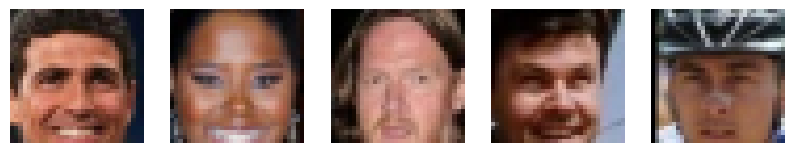

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images from the dataset in batches
def show_images_from_dataset(dataset, num_images=500, images_per_row=20):
    total_batches = num_images // images_per_row
    dataset_iter = iter(dataset.take(num_images))  

    for batch in range(total_batches):
        plt.figure(figsize=(10, 50))  
        for i in range(images_per_row):
                image = next(dataset_iter)

                image = image.numpy()
                # Ensure image is in (64, 64, 3) format
                if image.shape == (32, 32, 3):
                    image = (image * 127.5 + 127.5).astype(np.uint8) 
                else:
                    raise ValueError(f"Unexpected image shape for display: {image.shape}")

                plt.subplot(1, images_per_row, i + 1)
                plt.imshow(image)
                plt.axis('off')

        plt.show()

# display dataset images.
show_images_from_dataset(dataset, num_images=5, images_per_row=5)


In [3]:
from tensorflow.keras import layers, models
# Generator architecture defined
def build_simplified_generator(input_dim=100):
    model = models.Sequential()
    
    # Fully connected layer to project and reshape input
    model.add(layers.Dense(4 * 4 * 128, input_dim=input_dim))
    model.add(layers.Reshape((4, 4, 128)))
    model.add(layers.ReLU())  # Activation function
    
    # First Transposed Convolutional Block (8x8 -> 16x16)
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.ReLU())
    
    # Second Transposed Convolutional Block (16x16 -> 32x32)
    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(layers.ReLU())
    
    # Third Transposed Convolutional Block (32x32 -> 64x64)
    model.add(layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same'))
    model.add(layers.ReLU())
    
    # Final Conv2D Layer to produce a 64x64 RGB image
    model.add(layers.Conv2D(3, kernel_size=3, padding='same', activation='tanh'))
    
    return model

# Instantiate and print the summary of the modified generator
generator = build_simplified_generator()
generator.summary()



/Users/anichougule/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2048)           │       206,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 633,923 (2.42 MB)

 Trainable params: 633,923 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
from tensorflow.keras import layers, models
# Discriminator architecture defined
def build_simplified_discriminator(input_shape=(32, 32, 3)):
    model = models.Sequential()
    
    # Initial Convolutional Block to downsample from 64x64 to 32x32
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Existing Convolutional Blocks
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Flatten and output layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

# Instantiate and print the summary of the updated discriminator
discriminator = build_simplified_discriminator()
discriminator.summary()


/Users/anichougule/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/anichougule/myenv/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 662,977 (2.53 MB)

 Trainable params: 662,977 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
#Both model loaded and complied
generator = build_simplified_generator()  
discriminator = build_simplified_discriminator()  


discriminator.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.5,beta_2=0.99),
    loss='binary_crossentropy'
)

# Create the combined GAN model
discriminator.trainable = False  # Ensure the discriminator is not trainable when training the GAN
gan_input = tf.keras.Input(shape=(100,))  # Input shape should match the noise vector size
generated_image = generator(gan_input)  # Pass the noise vector to the generator
gan_output = discriminator(generated_image)  # Pass the generated image to the discriminator

# Build the GAN model
gan_model = tf.keras.Model(gan_input, gan_output)

# Compile the GAN model
gan_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5,beta_2=0.99),
    loss='binary_crossentropy'
)


In [17]:
## Loaded Brown Corpus from nltk and converted sentences in binary format and saved in file.
# we have to use the same file while extractor training.
import nltk
import numpy as np

# Download the Brown corpus if not already available
nltk.download('brown')
from nltk.corpus import brown

# Function to convert a sentence to binary
def text_to_binary(text):
    binary_string = ''.join(format(ord(char), '08b') for char in text)
    return binary_string

# Load sentences from the Brown corpus (use a subset or all sentences as needed)
corpus_sentences = brown.sents()[:epochs]  # Limit to the first 100 sentences for demonstration
binary_sentences = [text_to_binary(' '.join(sentence)) for sentence in corpus_sentences]

# Save the binary representation of each sentence to a file for later use
with open('/Users/anichougule/Downloads/corpus_sentences_binary.txt', 'w') as file:
    for binary_sentence in binary_sentences:
        file.write(binary_sentence + '\n')

print("Binary representations of sentences saved to '/Users/anichougule/Downloads/corpus_sentences_binary.txt'.")


Binary representations of sentences saved to '/Users/anichougule/Downloads/corpus_sentences_binary.txt'.


[nltk_data] Downloading package brown to
[nltk_data]     /Users/anichougule/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [15]:
# Binary string mapping with noise to create noise vector.
import numpy as np
import tensorflow as tf

# Function to map binary data to a noise vector
def map_binary_to_noise(binary_string, target_dim=100, sigma=3):
    noise_vector = []
    for i in range(0, len(binary_string), sigma):
        bit_group = binary_string[i:i + sigma]
        if len(bit_group) < sigma:
            bit_group = bit_group.ljust(sigma, '0')  # Pad with zeros if the last group is smaller
        
        m = int(bit_group, 2)
        noise_value = (m / (2**sigma - 1)) * 2 - 1  # Scale to the range [-1, 1]
        noise_vector.append(noise_value)

    if len(noise_vector) < target_dim:
        repeat_count = (target_dim - len(noise_vector)) // len(noise_vector)
        remainder = (target_dim - len(noise_vector)) % len(noise_vector)
        noise_vector = np.concatenate([noise_vector] * (repeat_count + 2))[:target_dim]
    else:
        noise_vector = np.array(noise_vector[:target_dim])
    return noise_vector

# Load the binary sentences from the file
with open('corpus_sentences_binary.txt', 'r') as file:
    binary_sentences = file.read().splitlines()

# Example: Convert the first binary sentence to a noise vector
noise_vectors = [map_binary_to_noise(binary_sentence, target_dim=100, sigma=3) for binary_sentence in binary_sentences]
noise_tensors = tf.convert_to_tensor(noise_vectors, dtype=tf.float32)

print(len(noise_tensors)) 

1000


In [16]:
## Main block of code where we are training GAN model using generator and discriminator one by one to create realistic image.
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random

# Define optimizers
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.5,beta_2=0.99)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5,beta_2=0.99)

# Loss function reused for efficiency
bce_loss = tf.keras.losses.BinaryCrossentropy()

# Output directory for generated images
output_dir = '/Users/anichougule/Downloads/generated_image_2/'
os.makedirs(output_dir, exist_ok=True)

# Training loop
save_interval = 5  # Save images every N epochs

for epoch in range(epochs):
    print(f"Starting epoch {epoch + 1}/{epochs}")
    total_disc_loss = 0  # Track total discriminator loss for the epoch
    total_gen_loss = 0   # Track total generator loss for the epoch
    num_batches = 0      # Count the number of batches processed

    for step, real_images in enumerate(augmented_dataset):
        current_batch_size = real_images.shape[0]
        num_batches += 1

        # ---------------------
        # Train the Discriminator
        # ---------------------
        discriminator.trainable = True
        disc_loss_total = 0  # Accumulate discriminator loss over the two steps

        for _ in range(1):  # Train discriminator twice
            with tf.GradientTape() as disc_tape:
                # Generate fake images
                noise = tf.expand_dims(noise_tensors[epoch], axis=0) 
                fake_images = generator(noise, training=True)

                # Get discriminator outputs
                real_output = discriminator(real_images, training=True)
                fake_output = discriminator(fake_images, training=True)

                # Label smoothing for real images
                real_labels = tf.ones_like(real_output) * 0.9  # Smoothed real labels
                fake_labels = tf.zeros_like(fake_output) + 0.1  # Fake labels

                # Compute discriminator loss
                real_loss = bce_loss(real_labels, real_output)
                fake_loss = bce_loss(fake_labels, fake_output)
                disc_loss = (real_loss + fake_loss) / 2

            # Apply gradients to the discriminator
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

            disc_loss_total += disc_loss  # Accumulate for averaging

        # Average discriminator loss over the two updates
        avg_disc_loss_per_step = disc_loss_total / 2
        total_disc_loss += avg_disc_loss_per_step  # Accumulate batch loss

        print(f"Average Discriminator Loss (2 updates): {avg_disc_loss_per_step:.4f}")

        # ---------------------
        # Train the Generator
        # ---------------------
        discriminator.trainable = False

        with tf.GradientTape() as gen_tape:
            # Generate fake images
            noise = tf.expand_dims(noise_tensors[epoch], axis=0)
            fake_images = generator(noise, training=True)

            # Get output from the discriminator for the fake images
            fake_output = discriminator(fake_images, training=True)

            # Compute generator loss
            gen_loss = bce_loss(tf.ones_like(fake_output), fake_output)

        # Apply gradients to the generator
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        print(f"Generator Loss: {gen_loss:.4f}")
        total_gen_loss += gen_loss  # Accumulate batch loss

    # Calculate average losses for the epoch
    avg_disc_loss = total_disc_loss / num_batches
    avg_gen_loss = total_gen_loss / num_batches

    # Print progress at the end of each epoch
    print(f"Epoch {epoch + 1}/{epochs}, Avg D Loss: {avg_disc_loss:.4f}, Avg G Loss: {avg_gen_loss:.4f}")

    # Save generated images at specified intervals
    if (epoch + 1) % save_interval == 0:
        # Generate and save an image
        sample_noise = random.randint(0, epochs)
        noise = tf.expand_dims(noise_tensors[sample_noise], axis=0)
        generated_image = generator(noise, training=False)
        generated_image = (generated_image * 127.5 + 127.5).numpy().astype(np.uint8)  # Rescale to [0, 255]

        # Save the image using matplotlib
        plt.imshow(generated_image[0])
        plt.axis('off')
        plt.title(f'Epoch {epoch + 1}')
        image_path = os.path.join(output_dir, f'generated_image_epoch_{epoch + 1}.png')
        plt.savefig(image_path)
        plt.close()
        print(f"Generated image saved to {image_path}")

print("Training complete.")
#save the trained generator and discriminator model for future use.
generator.save("/Users/anichougule/Masters/Code/Python/SEM3/Computer Vision/cs512-f24-aniket-chougule/Project/Data/generator_model_nlp_latest.h5")
discriminator.save("/Users/anichougule/Masters/Code/Python/SEM3/Computer Vision/cs512-f24-aniket-chougule/Project/Data/discriminator_model_nlp_latest.h5")


Starting epoch 1/1000
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6785
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6600
Average Discriminator Loss (2 updates): 0.3539
Generator Loss: 0.6239
Average Discriminator Loss (2 updates): 0.3670
Generator Loss: 0.5672
Average Discriminator Loss (2 updates): 0.3837
Generator Loss: 0.5125
Average Discriminator Loss (2 updates): 0.4007
Generator Loss: 0.4626
Average Discriminator Loss (2 updates): 0.4179
Generator Loss: 0.4207
Average Discriminator Loss (2 updates): 0.4374
Generator Loss: 0.3762
Average Discriminator Loss (2 updates): 0.4517
Generator Loss: 0.3496
Average Discriminator Loss (2 updates): 0.4709
Generator Loss: 0.3203
Average Discriminator Loss (2 updates): 0.4896
Generator Loss: 0.2889
Average Discriminator Loss (2 updates): 0.5055
Generator Loss: 0.268

2024-11-17 15:07:36.319555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3971
Generator Loss: 0.5026
Average Discriminator Loss (2 updates): 0.4007
Generator Loss: 0.4877
Average Discriminator Loss (2 updates): 0.4159
Generator Loss: 0.4507
Average Discriminator Loss (2 updates): 0.4210
Generator Loss: 0.4392
Average Discriminator Loss (2 updates): 0.4208
Generator Loss: 0.4353
Average Discriminator Loss (2 updates): 0.4222
Generator Loss: 0.4361
Average Discriminator Loss (2 updates): 0.4240
Generator Loss: 0.4299
Average Discriminator Loss (2 updates): 0.4287
Generator Loss: 0.4237
Average Discriminator Loss (2 updates): 0.4285
Generator Loss: 0.4233
Average Discriminator Loss (2 updates): 0.4268
Generator Loss: 0.4274
Average Discriminator Loss (2 updates): 0.4261
Generator Loss: 0.4312
Average Discriminator Loss (2 updates): 0.4230
Generator Loss: 0.4371
Average Discriminator Loss (2 updates): 0.4151
Generator Loss: 0.4518
Average Discriminator Loss (2 updates): 0.4155
Generator Loss: 0.4535
Average Discriminato

2024-11-17 15:07:41.738794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3749
Generator Loss: 0.5897
Average Discriminator Loss (2 updates): 0.3749
Generator Loss: 0.5865
Average Discriminator Loss (2 updates): 0.3749
Generator Loss: 0.5800
Average Discriminator Loss (2 updates): 0.3781
Generator Loss: 0.5749
Average Discriminator Loss (2 updates): 0.3757
Generator Loss: 0.5775
Average Discriminator Loss (2 updates): 0.3748
Generator Loss: 0.5836
Average Discriminator Loss (2 updates): 0.3738
Generator Loss: 0.5925
Average Discriminator Loss (2 updates): 0.3732
Generator Loss: 0.5941
Average Discriminator Loss (2 updates): 0.3723
Generator Loss: 0.5970
Average Discriminator Loss (2 updates): 0.3737
Generator Loss: 0.5947
Average Discriminator Loss (2 updates): 0.3718
Generator Loss: 0.5931
Average Discriminator Loss (2 updates): 0.3691
Generator Loss: 0.6046
Average Discriminator Loss (2 updates): 0.3697
Generator Loss: 0.5994
Average Discriminator Loss (2 updates): 0.3707
Generator Loss: 0.6039
Average Discriminato

2024-11-17 15:07:47.371917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3590
Generator Loss: 0.7105
Average Discriminator Loss (2 updates): 0.3634
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3690
Generator Loss: 0.6723
Average Discriminator Loss (2 updates): 0.3722
Generator Loss: 0.6643
Average Discriminator Loss (2 updates): 0.3719
Generator Loss: 0.6592
Average Discriminator Loss (2 updates): 0.3748
Generator Loss: 0.6540
Average Discriminator Loss (2 updates): 0.3752
Generator Loss: 0.6558
Average Discriminator Loss (2 updates): 0.3691
Generator Loss: 0.6657
Average Discriminator Loss (2 updates): 0.3728
Generator Loss: 0.6656
Average Discriminator Loss (2 updates): 0.3756
Generator Loss: 0.6581
Average Discriminator Loss (2 updates): 0.3735
Generator Loss: 0.6614
Average Discriminator Loss (2 updates): 0.3732
Generator Loss: 0.6597
Average Discriminator Loss (2 updates): 0.3738
Generator Loss: 0.6675
Average Discriminator Loss (2 updates): 0.3712
Generator Loss: 0.6708
Average Discriminato

2024-11-17 15:07:52.693950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3617
Generator Loss: 0.7459
Average Discriminator Loss (2 updates): 0.3666
Generator Loss: 0.7184
Average Discriminator Loss (2 updates): 0.3670
Generator Loss: 0.7088
Average Discriminator Loss (2 updates): 0.3679
Generator Loss: 0.7044
Average Discriminator Loss (2 updates): 0.3689
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3686
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3693
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3713
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3716
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3693
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3683
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3706
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3687
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3707
Generator Loss: 0.6940
Average Discriminato

2024-11-17 15:07:58.264364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_5.png
Starting epoch 6/1000
Average Discriminator Loss (2 updates): 0.3658
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3690
Generator Loss: 0.6825
Average Discriminator Loss (2 updates): 0.3697
Generator Loss: 0.6711
Average Discriminator Loss (2 updates): 0.3720
Generator Loss: 0.6623
Average Discriminator Loss (2 updates): 0.3727
Generator Loss: 0.6554
Average Discriminator Loss (2 updates): 0.3721
Generator Loss: 0.6498
Average Discriminator Loss (2 updates): 0.3726
Generator Loss: 0.6457
Average Discriminator Loss (2 updates): 0.3758
Generator Loss: 0.6420
Average Discriminator Loss (2 updates): 0.3745
Generator Loss: 0.6396
Average Discriminator Loss (2 updates): 0.3742
Generator Loss: 0.6405
Average Discriminator Loss (2 updates): 0.3737
Generator Loss: 0.6390
Average Discriminator Loss (2 updates): 0.3747
Generator Loss: 0.6388
Average Discriminator Loss (2 updates)

2024-11-17 15:08:03.649857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7604
Average Discriminator Loss (2 updates): 0.3643
Generator Loss: 0.7087
Average Discriminator Loss (2 updates): 0.3645
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3657
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3665
Generator Loss: 0.6843
Average Discriminator Loss (2 updates): 0.3668
Generator Loss: 0.6800
Average Discriminator Loss (2 updates): 0.3655
Generator Loss: 0.6802
Average Discriminator Loss (2 updates): 0.3661
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3654
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3645
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3651
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3648
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3640
Generator Loss: 0.6817
Average Discriminator Loss (2 updates): 0.3628
Generator Loss: 0.6816
Average Discriminator Loss (2 updates): 0.3633
Generator Loss: 0.68

2024-11-17 15:08:08.918818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3530
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3561
Generator Loss: 0.6813
Average Discriminator Loss (2 updates): 0.3604
Generator Loss: 0.6701
Average Discriminator Loss (2 updates): 0.3613
Generator Loss: 0.6609
Average Discriminator Loss (2 updates): 0.3633
Generator Loss: 0.6516
Average Discriminator Loss (2 updates): 0.3685
Generator Loss: 0.6467
Average Discriminator Loss (2 updates): 0.3692
Generator Loss: 0.6423
Average Discriminator Loss (2 updates): 0.3691
Generator Loss: 0.6436
Average Discriminator Loss (2 updates): 0.3661
Generator Loss: 0.6454
Average Discriminator Loss (2 updates): 0.3699
Generator Loss: 0.6480
Average Discriminator Loss (2 updates): 0.3709
Generator Loss: 0.6503
Average Discriminator Loss (2 updates): 0.3685
Generator Loss: 0.6523
Average Discriminator Loss (2 updates): 0.3666
Generator Loss: 0.6563
Average Discriminator Loss (2 updates): 0.3717
Generator Loss: 0.6496
Average Discriminato

2024-11-17 15:08:14.119643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.5735
Average Discriminator Loss (2 updates): 0.3852
Generator Loss: 0.6712
Average Discriminator Loss (2 updates): 0.3698
Generator Loss: 0.7385
Average Discriminator Loss (2 updates): 0.3596
Generator Loss: 0.7771
Average Discriminator Loss (2 updates): 0.3536
Generator Loss: 0.7994
Average Discriminator Loss (2 updates): 0.3544
Generator Loss: 0.7955
Average Discriminator Loss (2 updates): 0.3586
Generator Loss: 0.7816
Average Discriminator Loss (2 updates): 0.3629
Generator Loss: 0.7627
Average Discriminator Loss (2 updates): 0.3643
Generator Loss: 0.7435
Average Discriminator Loss (2 updates): 0.3596
Generator Loss: 0.7303
Average Discriminator Loss (2 updates): 0.3699
Generator Loss: 0.7205
Average Discriminator Loss (2 updates): 0.3757
Generator Loss: 0.7121
Average Discriminator Loss (2 updates): 0.3660
Generator Loss: 0.7055
Average Discriminator Loss (2 updates): 0.3688
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3670
Generator Loss: 0.69

2024-11-17 15:08:19.419286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3534
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3528
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3534
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3519
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3536
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6832
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3522
Generator Loss: 0.6790
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6764
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6739
Average Discriminato

2024-11-17 15:08:24.609427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3617
Generator Loss: 0.6813
Average Discriminator Loss (2 updates): 0.3651
Generator Loss: 0.6667
Average Discriminator Loss (2 updates): 0.3654
Generator Loss: 0.6636
Average Discriminator Loss (2 updates): 0.3655
Generator Loss: 0.6621
Average Discriminator Loss (2 updates): 0.3678
Generator Loss: 0.6617
Average Discriminator Loss (2 updates): 0.3661
Generator Loss: 0.6617
Average Discriminator Loss (2 updates): 0.3652
Generator Loss: 0.6642
Average Discriminator Loss (2 updates): 0.3644
Generator Loss: 0.6670
Average Discriminator Loss (2 updates): 0.3635
Generator Loss: 0.6671
Average Discriminator Loss (2 updates): 0.3639
Generator Loss: 0.6676
Average Discriminator Loss (2 updates): 0.3637
Generator Loss: 0.6683
Average Discriminator Loss (2 updates): 0.3637
Generator Loss: 0.6698
Average Discriminator Loss (2 updates): 0.3626
Generator Loss: 0.6711
Average Discriminator Loss (2 updates): 0.3622
Generator Loss: 0.6732
Average Discriminato

2024-11-17 15:08:30.012752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3599
Generator Loss: 0.6789
Average Discriminator Loss (2 updates): 0.3613
Generator Loss: 0.6764
Average Discriminator Loss (2 updates): 0.3612
Generator Loss: 0.6761
Average Discriminator Loss (2 updates): 0.3605
Generator Loss: 0.6772
Average Discriminator Loss (2 updates): 0.3607
Generator Loss: 0.6792
Average Discriminator Loss (2 updates): 0.3614
Generator Loss: 0.6810
Average Discriminator Loss (2 updates): 0.3607
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3601
Generator Loss: 0.6832
Average Discriminator Loss (2 updates): 0.3598
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3609
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3619
Generator Loss: 0.6861
Average Discriminator Loss (2 updates): 0.3611
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3603
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3603
Generator Loss: 0.6885
Average Discriminato

2024-11-17 15:08:35.180094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3537
Generator Loss: 0.6717
Average Discriminator Loss (2 updates): 0.3573
Generator Loss: 0.6519
Average Discriminator Loss (2 updates): 0.3608
Generator Loss: 0.6393
Average Discriminator Loss (2 updates): 0.3622
Generator Loss: 0.6308
Average Discriminator Loss (2 updates): 0.3645
Generator Loss: 0.6267
Average Discriminator Loss (2 updates): 0.3644
Generator Loss: 0.6280
Average Discriminator Loss (2 updates): 0.3623
Generator Loss: 0.6336
Average Discriminator Loss (2 updates): 0.3618
Generator Loss: 0.6423
Average Discriminator Loss (2 updates): 0.3585
Generator Loss: 0.6523
Average Discriminator Loss (2 updates): 0.3569
Generator Loss: 0.6624
Average Discriminator Loss (2 updates): 0.3544
Generator Loss: 0.6719
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6813
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6974
Average Discriminato

2024-11-17 15:08:40.477656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3598
Generator Loss: 0.6792
Average Discriminator Loss (2 updates): 0.3628
Generator Loss: 0.6733
Average Discriminator Loss (2 updates): 0.3657
Generator Loss: 0.6707
Average Discriminator Loss (2 updates): 0.3630
Generator Loss: 0.6695
Average Discriminator Loss (2 updates): 0.3663
Generator Loss: 0.6692
Average Discriminator Loss (2 updates): 0.3641
Generator Loss: 0.6694
Average Discriminator Loss (2 updates): 0.3645
Generator Loss: 0.6707
Average Discriminator Loss (2 updates): 0.3647
Generator Loss: 0.6731
Average Discriminator Loss (2 updates): 0.3650
Generator Loss: 0.6767
Average Discriminator Loss (2 updates): 0.3622
Generator Loss: 0.6789
Average Discriminator Loss (2 updates): 0.3619
Generator Loss: 0.6804
Average Discriminator Loss (2 updates): 0.3618
Generator Loss: 0.6813
Average Discriminator Loss (2 updates): 0.3618
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3607
Generator Loss: 0.68

2024-11-17 15:08:45.863935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3535
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3544
Generator Loss: 0.6828
Average Discriminator Loss (2 updates): 0.3545
Generator Loss: 0.6821
Average Discriminator Loss (2 updates): 0.3542
Generator Loss: 0.6817
Average Discriminator Loss (2 updates): 0.3549
Generator Loss: 0.6820
Average Discriminator Loss (2 updates): 0.3547
Generator Loss: 0.6830
Average Discriminator Loss (2 updates): 0.3544
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3553
Generator Loss: 0.6843
Average Discriminator Loss (2 updates): 0.3549
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3546
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3554
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3557
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3531
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3545
Generator Loss: 0.6883
Average Discriminato

2024-11-17 15:08:51.337542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 15/1000, Avg D Loss: 0.3552, Avg G Loss: 0.6850
Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_15.png
Starting epoch 16/1000
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3543
Generator Loss: 0.6720
Average Discriminator Loss (2 updates): 0.3545
Generator Loss: 0.6649
Average Discriminator Loss (2 updates): 0.3560
Generator Loss: 0.6595
Average Discriminator Loss (2 updates): 0.3571
Generator Loss: 0.6560
Average Discriminator Loss (2 updates): 0.3577
Generator Loss: 0.6525
Average Discriminator Loss (2 updates): 0.3587
Generator Loss: 0.6504
Average Discriminator Loss (2 updates): 0.3576
Generator Loss: 0.6498
Average Discriminator Loss (2 updates): 0.3577
Generator Loss: 0.6506
Average Discriminator Loss (2 updates): 0.3583
Generator Loss: 0.6532
Average Discriminator Loss (2 updates): 0.3578
Generator Loss: 0.6582
Average Discriminator Loss (2 updates): 0.3561
Gener

2024-11-17 15:08:56.849636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3588
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3575
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3603
Generator Loss: 0.6746
Average Discriminator Loss (2 updates): 0.3603
Generator Loss: 0.6661
Average Discriminator Loss (2 updates): 0.3620
Generator Loss: 0.6595
Average Discriminator Loss (2 updates): 0.3621
Generator Loss: 0.6536
Average Discriminator Loss (2 updates): 0.3630
Generator Loss: 0.6501
Average Discriminator Loss (2 updates): 0.3649
Generator Loss: 0.6475
Average Discriminator Loss (2 updates): 0.3649
Generator Loss: 0.6472
Average Discriminator Loss (2 updates): 0.3632
Generator Loss: 0.6487
Average Discriminator Loss (2 updates): 0.3623
Generator Loss: 0.6507
Average Discriminator Loss (2 updates): 0.3612
Generator Loss: 0.6541
Average Discriminator Loss (2 updates): 0.3616
Generator Loss: 0.6575
Average Discriminator Loss (2 updates): 0.3609
Generator Loss: 0.6612
Average Discriminato

2024-11-17 15:09:02.364406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3539
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3539
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3546
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3555
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3558
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3556
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3552
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3545
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3536
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3538
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3530
Generator Loss: 0.7055
Average Discriminator Loss (2 updates): 0.3529
Generator Loss: 0.7069
Average Discriminator Loss (2 updates): 0.3533
Generator Loss: 0.7063
Average Discriminator Loss (2 updates): 0.3528
Generator Loss: 0.7049
Average Discriminato

2024-11-17 15:09:08.058383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6755
Average Discriminator Loss (2 updates): 0.3570
Generator Loss: 0.6535
Average Discriminator Loss (2 updates): 0.3594
Generator Loss: 0.6408
Average Discriminator Loss (2 updates): 0.3602
Generator Loss: 0.6365
Average Discriminator Loss (2 updates): 0.3612
Generator Loss: 0.6384
Average Discriminator Loss (2 updates): 0.3612
Generator Loss: 0.6431
Average Discriminator Loss (2 updates): 0.3596
Generator Loss: 0.6490
Average Discriminator Loss (2 updates): 0.3589
Generator Loss: 0.6553
Average Discriminator Loss (2 updates): 0.3584
Generator Loss: 0.6594
Average Discriminator Loss (2 updates): 0.3582
Generator Loss: 0.6630
Average Discriminator Loss (2 updates): 0.3577
Generator Loss: 0.6669
Average Discriminator Loss (2 updates): 0.3567
Generator Loss: 0.6759
Average Discriminator Loss (2 updates): 0.3556
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3543
Generator Loss: 0.6977
Average Discriminato

2024-11-17 15:09:13.558615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3522
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3523
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3529
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3534
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3526
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3530
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3533
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3534
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3541
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3542
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3538
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3542
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3540
Generator Loss: 0.6833
Average Discriminato

2024-11-17 15:09:19.257056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_20.png
Starting epoch 21/1000
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3529
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3539
Generator Loss: 0.6832
Average Discriminator Loss (2 updates): 0.3552
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3551
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3544
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3544
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3538
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3535
Generator Loss: 0.7044
Average Discriminator Loss (2 updates): 0.3532
Generator Loss: 0.7075
Average Discriminator Loss (2 updates): 0.3533
Generator Loss: 0.7092
Average Discriminator Loss (2 update

2024-11-17 15:09:25.296216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6843
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6766
Average Discriminator Loss (2 updates): 0.3529
Generator Loss: 0.6667
Average Discriminator Loss (2 updates): 0.3542
Generator Loss: 0.6578
Average Discriminator Loss (2 updates): 0.3578
Generator Loss: 0.6512
Average Discriminator Loss (2 updates): 0.3584
Generator Loss: 0.6562
Average Discriminator Loss (2 updates): 0.3564
Generator Loss: 0.6709
Average Discriminator Loss (2 updates): 0.3545
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.7089
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.7072
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6980
Average Discriminato

2024-11-17 15:09:30.479578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7137
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7038
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6820
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6785
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6750
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6709
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6666
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6622
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6581
Average Discriminator Loss (2 updates): 0.3521
Generator Loss: 0.6539
Average Discriminator Loss (2 updates): 0.3538
Generator Loss: 0.65

2024-11-17 15:09:35.667821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3577
Generator Loss: 0.6660
Average Discriminator Loss (2 updates): 0.3586
Generator Loss: 0.6668
Average Discriminator Loss (2 updates): 0.3573
Generator Loss: 0.6764
Average Discriminator Loss (2 updates): 0.3552
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3539
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.7067
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.7131
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.7178
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.7197
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.7187
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.7161
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.7119
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.7066
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6996
Average Discriminato

2024-11-17 15:09:40.932124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.7117
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.7031
Average Discriminator Loss (2 updates): 0.3520
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6831
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6802
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6772
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6740
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6709
Average Discriminato

2024-11-17 15:09:46.508060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7148
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7036
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6827
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6805
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6799
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6796
Average Discriminato

2024-11-17 15:09:52.177250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6832
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6825
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6830
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6829
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6789
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6782
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6789
Average Discriminato

2024-11-17 15:09:57.717344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3640
Generator Loss: 0.6563
Average Discriminator Loss (2 updates): 0.3681
Generator Loss: 0.6476
Average Discriminator Loss (2 updates): 0.3627
Generator Loss: 0.6672
Average Discriminator Loss (2 updates): 0.3565
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.7112
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7315
Average Discriminator Loss (2 updates): 0.3411
Generator Loss: 0.7522
Average Discriminator Loss (2 updates): 0.3375
Generator Loss: 0.7730
Average Discriminator Loss (2 updates): 0.3335
Generator Loss: 0.7925
Average Discriminator Loss (2 updates): 0.3303
Generator Loss: 0.8088
Average Discriminator Loss (2 updates): 0.3279
Generator Loss: 0.8191
Average Discriminator Loss (2 updates): 0.3262
Generator Loss: 0.8214
Average Discriminator Loss (2 updates): 0.3314
Generator Loss: 0.7938
Average Discriminator Loss (2 updates): 0.3374
Generator Loss: 0.73

2024-11-17 15:10:03.113769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7212
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.7077
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6888
Average Discriminato

2024-11-17 15:10:08.797215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6815
Average Discriminator Loss (2 updates): 0.3520
Generator Loss: 0.6789
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6769
Average Discriminator Loss (2 updates): 0.3518
Generator Loss: 0.6754
Average Discriminator Loss (2 updates): 0.3524
Generator Loss: 0.6751
Average Discriminator Loss (2 updates): 0.3528
Generator Loss: 0.6757
Average Discriminator Loss (2 updates): 0.3524
Generator Loss: 0.6774
Average Discriminator Loss (2 updates): 0.3523
Generator Loss: 0.6799
Average Discriminator Loss (2 updates): 0.3522
Generator Loss: 0.6831
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.69

2024-11-17 15:10:14.248729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7132
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7157
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7171
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7161
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7125
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7071
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3519
Generator Loss: 0.6779
Average Discriminator Loss (2 updates): 0.3525
Generator Loss: 0.6719
Average Discriminator Loss (2 updates): 0.3539
Generator Loss: 0.6693
Average Discriminator Loss (2 updates): 0.3530
Generator Loss: 0.6683
Average Discriminator Loss (2 updates): 0.3541
Generator Loss: 0.6683
Average Discriminato

2024-11-17 15:10:19.626907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7084
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6827
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6812
Average Discriminato

2024-11-17 15:10:24.964042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.7027
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6820
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6797
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6776
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6760
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6749
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6747
Average Discriminato

2024-11-17 15:10:30.354584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6824
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6809
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6795
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6783
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6778
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6779
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6790
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6806
Average Discriminato

2024-11-17 15:10:35.611957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7080
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6805
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6775
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6743
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6715
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6694
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6700
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6744
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6806
Average Discriminato

2024-11-17 15:10:40.987752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7034
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7031
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7003
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3434
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3426
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3438
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.6829
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.6765
Average Discriminato

2024-11-17 15:10:46.380130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6891
Average Discriminato

2024-11-17 15:10:51.734923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6827
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6785
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6783
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6787
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6803
Average Discriminato

2024-11-17 15:10:57.269484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7017
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7026
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.69

2024-11-17 15:11:02.746078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3424
Generator Loss: 0.7109
Average Discriminator Loss (2 updates): 0.3432
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3438
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6791
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6743
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6701
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6664
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6616
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.6592
Average Discriminator Loss (2 updates): 0.3522
Generator Loss: 0.6625
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6728
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6913
Average Discriminato

2024-11-17 15:11:08.168771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_40.png
Starting epoch 41/1000
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7050
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7059
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7053
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7028
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6906
Average Discriminator Loss (2 update

2024-11-17 15:11:13.637866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7111
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7008
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6821
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6824
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6829
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6839
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.69

2024-11-17 15:11:19.102749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6821
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6809
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6800
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6795
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6795
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6798
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6807
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6824
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.68

2024-11-17 15:11:24.443150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6806
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6805
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6808
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6821
Average Discriminato

2024-11-17 15:11:30.122463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3431
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6656
Average Discriminator Loss (2 updates): 0.3521
Generator Loss: 0.6436
Average Discriminator Loss (2 updates): 0.3549
Generator Loss: 0.6371
Average Discriminator Loss (2 updates): 0.3543
Generator Loss: 0.6450
Average Discriminator Loss (2 updates): 0.3539
Generator Loss: 0.6545
Average Discriminator Loss (2 updates): 0.3532
Generator Loss: 0.6614
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6705
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6794
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6926
Average Discriminato

2024-11-17 15:11:35.800369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.69

2024-11-17 15:11:41.386247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.70

2024-11-17 15:11:46.664704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6804
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6760
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6724
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6722
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.6745
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6794
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.69

2024-11-17 15:11:52.079538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7042
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6813
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6789
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6787
Average Discriminato

2024-11-17 15:11:57.603216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7270
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7333
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7332
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7297
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7233
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7163
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.7114
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.7081
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.7056
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.7036
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.7018
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.69

2024-11-17 15:12:03.008590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6867
Average Discriminato

2024-11-17 15:12:08.455153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6936
Average Discriminato

2024-11-17 15:12:13.923540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6810
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6785
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6761
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6738
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6723
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6723
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6736
Average Discriminato

2024-11-17 15:12:19.348960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7054
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7093
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7100
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7077
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7042
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6855
Average Discriminato

2024-11-17 15:12:24.719456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6870
Average Discriminato

2024-11-17 15:12:30.190520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7026
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6996
Average Discriminato

2024-11-17 15:12:35.823079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6843
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6880
Average Discriminato

2024-11-17 15:12:41.336063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6831
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6832
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6864
Average Discriminato

2024-11-17 15:12:46.646054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7072
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7092
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7082
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7053
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6859
Average Discriminato

2024-11-17 15:12:52.076830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6816
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6799
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6790
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6790
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6812
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6846
Average Discriminato

2024-11-17 15:12:57.632806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6847
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6921
Average Discriminato

2024-11-17 15:13:03.022150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7000
Average Discriminato

2024-11-17 15:13:08.360717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6860
Average Discriminato

2024-11-17 15:13:13.768408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6843
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6778
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6737
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6703
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6705
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6767
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7034
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7072
Average Discriminato

2024-11-17 15:13:19.050194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6965
Average Discriminato

2024-11-17 15:13:24.412503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6816
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6799
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6802
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6825
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.70

2024-11-17 15:13:29.762432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.7302
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7250
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7155
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.7051
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6847
Average Discriminato

2024-11-17 15:13:35.163607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6889
Average Discriminato

2024-11-17 15:13:40.563542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6920
Average Discriminato

2024-11-17 15:13:45.899777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6853
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6839
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6827
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6820
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6882
Average Discriminato

2024-11-17 15:13:51.276748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6732
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6651
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6659
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6755
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7100
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7143
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7137
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7102
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7065
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7043
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7024
Average Discriminato

2024-11-17 15:13:56.709720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7177
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7076
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6893
Average Discriminato

2024-11-17 15:14:02.129085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6878
Average Discriminato

2024-11-17 15:14:07.459108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6969
Average Discriminato

2024-11-17 15:14:12.824714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7043
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7072
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7101
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7111
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7095
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7070
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7041
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6933
Average Discriminato

2024-11-17 15:14:18.122478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6884
Average Discriminato

2024-11-17 15:14:23.549582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6985
Average Discriminato

2024-11-17 15:14:28.996892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6822
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6802
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6783
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6773
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6774
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6782
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6798
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6817
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6915
Average Discriminato

2024-11-17 15:14:34.378133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.68

2024-11-17 15:14:39.683691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6929
Average Discriminato

2024-11-17 15:14:45.251783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_80.png
Starting epoch 81/1000
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6909
Average Discriminator Loss (2 update

2024-11-17 15:14:50.698004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6804
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6758
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6754
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6771
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6794
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6820
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.69

2024-11-17 15:14:56.317344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6983
Average Discriminato

2024-11-17 15:15:03.164455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6898
Average Discriminato

2024-11-17 15:15:08.939767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6797
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6787
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6830
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7027
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7080
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7115
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7138
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7149
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7142
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7122
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7095
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7057
Average Discriminato

2024-11-17 15:15:14.658878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6963
Average Discriminato

2024-11-17 15:15:20.366267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6963
Average Discriminato

2024-11-17 15:15:26.190389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.69

2024-11-17 15:15:32.050313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 88/1000, Avg D Loss: 0.3468, Avg G Loss: 0.6938
Starting epoch 89/1000
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7042
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6860
Average Discr

2024-11-17 15:15:38.058503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7180
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7098
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7042
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6903
Average Discriminato

2024-11-17 15:15:43.588151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6912
Average Discriminato

2024-11-17 15:15:49.674376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7005
Average Discriminato

2024-11-17 15:15:55.388458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6891
Average Discriminato

2024-11-17 15:16:01.195128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6832
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6824
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6805
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6796
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6793
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6799
Average Discriminato

2024-11-17 15:16:07.034291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6839
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6798
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6775
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6792
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6909
Average Discriminato

2024-11-17 15:16:13.325991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6966
Average Discriminato

2024-11-17 15:16:19.002444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6939
Average Discriminato

2024-11-17 15:16:24.564069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6889
Average Discriminato

2024-11-17 15:16:29.992425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6909
Average Discriminato

2024-11-17 15:16:35.488890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6878
Average Discriminato

2024-11-17 15:16:40.832447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6802
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6780
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6776
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6790
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6813
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6904
Average Discriminato

2024-11-17 15:16:46.295072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6841
Average Discriminato

2024-11-17 15:16:51.691141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6772
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6710
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6664
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6668
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6703
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6765
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7001
Average Discriminato

2024-11-17 15:16:57.170730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6976
Average Discriminato

2024-11-17 15:17:02.573729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6902
Average Discriminato

2024-11-17 15:17:08.090443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_105.png
Starting epoch 106/1000
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6853
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6822
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6821
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6977
Average Discriminator Loss (2 upda

2024-11-17 15:17:14.133560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3518
Generator Loss: 0.6790
Average Discriminator Loss (2 updates): 0.3554
Generator Loss: 0.6696
Average Discriminator Loss (2 updates): 0.3597
Generator Loss: 0.6583
Average Discriminator Loss (2 updates): 0.3680
Generator Loss: 0.6388
Average Discriminator Loss (2 updates): 0.3746
Generator Loss: 0.6302
Average Discriminator Loss (2 updates): 0.3721
Generator Loss: 0.6459
Average Discriminator Loss (2 updates): 0.3640
Generator Loss: 0.6707
Average Discriminator Loss (2 updates): 0.3564
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.7100
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7131
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7121
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.7096
Average Discriminato

2024-11-17 15:17:20.164141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7105
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7051
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6967
Average Discriminato

2024-11-17 15:17:25.820770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6915
Average Discriminato

2024-11-17 15:17:31.530582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6914
Average Discriminato

2024-11-17 15:17:37.379682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6853
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6839
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6832
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6843
Average Discriminato

2024-11-17 15:17:43.038572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6974
Average Discriminato

2024-11-17 15:17:48.666572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6988
Average Discriminato

2024-11-17 15:17:54.151794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7248
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7165
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7086
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.7036
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6911
Average Discriminato

2024-11-17 15:17:59.541837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.69

2024-11-17 15:18:05.057275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6918
Average Discriminato

2024-11-17 15:18:10.425043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6879
Average Discriminato

2024-11-17 15:18:15.780426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6825
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6805
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6808
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.68

2024-11-17 15:18:21.127636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6935
Average Discriminato

2024-11-17 15:18:26.472049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6832
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6802
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6735
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6678
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6684
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6707
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6754
Average Discriminato

2024-11-17 15:18:31.796053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6946
Average Discriminato

2024-11-17 15:18:37.196179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6901
Average Discriminato

2024-11-17 15:18:42.584277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6822
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6809
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6791
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6769
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6745
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6729
Average Discriminato

2024-11-17 15:18:47.951527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6843
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6898
Average Discriminato

2024-11-17 15:18:53.272546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6991
Average Discriminato

2024-11-17 15:18:58.758952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6893
Average Discriminato

2024-11-17 15:19:04.241608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6921
Average Discriminato

2024-11-17 15:19:09.557726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6853
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6900
Average Discriminato

2024-11-17 15:19:14.967258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6969
Average Discriminato

2024-11-17 15:19:20.314421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6967
Average Discriminato

2024-11-17 15:19:25.661857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7040
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7043
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7039
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6976
Average Discriminato

2024-11-17 15:19:31.002189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6911
Average Discriminato

2024-11-17 15:19:36.555307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6816
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6829
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.70

2024-11-17 15:19:42.089937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6990
Average Discriminato

2024-11-17 15:19:47.566261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.69

2024-11-17 15:19:53.201235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6847
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6829
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6825
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6827
Average Discriminato

2024-11-17 15:19:58.719401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6740
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6664
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6619
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6622
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6655
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6698
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6739
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6780
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6920
Average Discriminato

2024-11-17 15:20:04.221483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6975
Average Discriminato

2024-11-17 15:20:09.859592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3581
Generator Loss: 0.6654
Average Discriminator Loss (2 updates): 0.3655
Generator Loss: 0.6523
Average Discriminator Loss (2 updates): 0.3661
Generator Loss: 0.6734
Average Discriminator Loss (2 updates): 0.3602
Generator Loss: 0.7152
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.7508
Average Discriminator Loss (2 updates): 0.3413
Generator Loss: 0.7678
Average Discriminator Loss (2 updates): 0.3382
Generator Loss: 0.7659
Average Discriminator Loss (2 updates): 0.3403
Generator Loss: 0.7358
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.7100
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6944
Average Discriminato

2024-11-17 15:20:15.291301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7124
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7082
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7057
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7044
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6961
Average Discriminato

2024-11-17 15:20:20.795391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6902
Average Discriminato

2024-11-17 15:20:26.385346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6880
Average Discriminato

2024-11-17 15:20:31.870571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6837
Average Discriminato

2024-11-17 15:20:37.355585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6922
Average Discriminato

2024-11-17 15:20:42.805408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6824
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6972
Average Discriminato

2024-11-17 15:20:48.473382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7046
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6939
Average Discriminato

2024-11-17 15:20:53.884493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6929
Average Discriminato

2024-11-17 15:20:59.231508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.69

2024-11-17 15:21:04.500394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.69

2024-11-17 15:21:09.869556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.69

2024-11-17 15:21:15.184814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6861
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6891
Average Discriminato

2024-11-17 15:21:20.432621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.69

2024-11-17 15:21:25.802893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7034
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7050
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7051
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7038
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.69

2024-11-17 15:21:30.922416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.68

2024-11-17 15:21:36.243623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6897
Average Discriminato

2024-11-17 15:21:41.484363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6839
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6827
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6820
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6813
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6813
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6831
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6847
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6895
Average Discriminato

2024-11-17 15:21:46.779981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6820
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.69

2024-11-17 15:21:52.083298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7003
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6994
Average Discriminato

2024-11-17 15:21:57.389125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6816
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6812
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6813
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6899
Average Discriminato

2024-11-17 15:22:02.552236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6946
Average Discriminato

2024-11-17 15:22:07.907620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6915
Average Discriminato

2024-11-17 15:22:13.262160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7102
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7044
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.7015
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6910
Average Discriminato

2024-11-17 15:22:18.511672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.68

2024-11-17 15:22:23.672226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6812
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6797
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6813
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6883
Average Discriminato

2024-11-17 15:22:28.886831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6897
Average Discriminato

2024-11-17 15:22:34.160831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.69

2024-11-17 15:22:39.505177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6752
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6708
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6715
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6755
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6808
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7059
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7075
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7082
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7082
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.70

2024-11-17 15:22:44.714797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6994
Average Discriminato

2024-11-17 15:22:49.996167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6907
Average Discriminato

2024-11-17 15:22:55.235688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6935
Average Discriminato

2024-11-17 15:23:00.518109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6876
Average Discriminato

2024-11-17 15:23:05.803239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6839
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6830
Average Discriminato

2024-11-17 15:23:11.196405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6924
Average Discriminato

2024-11-17 15:23:16.419043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6989
Average Discriminato

2024-11-17 15:23:21.615733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7055
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6947
Average Discriminato

2024-11-17 15:23:26.859576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6925
Average Discriminato

2024-11-17 15:23:32.048900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6880
Average Discriminato

2024-11-17 15:23:37.359808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.68

2024-11-17 15:23:42.559975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7002
Average Discriminato

2024-11-17 15:23:47.902246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6914
Average Discriminato

2024-11-17 15:23:53.211365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.7064
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6800
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6785
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6776
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6772
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6778
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6793
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6818
Average Discriminato

2024-11-17 15:23:58.934598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6958
Average Discriminato

2024-11-17 15:24:04.308030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6991
Average Discriminato

2024-11-17 15:24:09.669226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6843
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.70

2024-11-17 15:24:14.909359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6843
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6832
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6830
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6979
Average Discriminato

2024-11-17 15:24:20.237016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7004
Average Discriminato

2024-11-17 15:24:25.556608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7054
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7077
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7093
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7099
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7094
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7082
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7064
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.70

2024-11-17 15:24:30.856961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6996
Average Discriminato

2024-11-17 15:24:36.166217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6874
Average Discriminato

2024-11-17 15:24:41.589521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7036
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7015
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.69

2024-11-17 15:24:46.805171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6925
Average Discriminato

2024-11-17 15:24:52.161334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6887
Average Discriminato

2024-11-17 15:24:57.592531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.68

2024-11-17 15:25:02.863577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6859
Average Discriminato

2024-11-17 15:25:08.227051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6938
Average Discriminato

2024-11-17 15:25:13.815578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6974
Average Discriminato

2024-11-17 15:25:19.239716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6888
Average Discriminato

2024-11-17 15:25:24.727716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6962
Average Discriminato

2024-11-17 15:25:29.976930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6935
Average Discriminato

2024-11-17 15:25:35.450428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6832
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6999
Average Discriminato

2024-11-17 15:25:40.736207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6832
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6816
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6812
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6822
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7012
Average Discriminato

2024-11-17 15:25:46.053707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6914
Average Discriminato

2024-11-17 15:25:51.353426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.69

2024-11-17 15:25:56.821391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.69

2024-11-17 15:26:02.092774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6998
Average Discriminato

2024-11-17 15:26:07.391581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6933
Average Discriminato

2024-11-17 15:26:12.807670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7149
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7108
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7074
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7038
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6920
Average Discriminato

2024-11-17 15:26:18.076338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6923
Average Discriminato

2024-11-17 15:26:23.422996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6787
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6750
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6709
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6673
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6640
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.6608
Average Discriminator Loss (2 updates): 0.3519
Generator Loss: 0.6589
Average Discriminator Loss (2 updates): 0.3525
Generator Loss: 0.6587
Average Discriminator Loss (2 updates): 0.3522
Generator Loss: 0.6598
Average Discriminator Loss (2 updates): 0.3527
Generator Loss: 0.6621
Average Discriminator Loss (2 updates): 0.3519
Generator Loss: 0.6649
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.6682
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.6716
Average Discriminato

2024-11-17 15:26:28.774536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7088
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7072
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7059
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7050
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7042
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7036
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7017
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6989
Average Discriminato

2024-11-17 15:26:34.013327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7037
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6943
Average Discriminato

2024-11-17 15:26:39.407614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.69

2024-11-17 15:26:44.657650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6956
Average Discriminato

2024-11-17 15:26:49.965095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6896
Average Discriminato

2024-11-17 15:26:55.201074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6914
Average Discriminato

2024-11-17 15:27:00.683855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6843
Average Discriminato

2024-11-17 15:27:06.449213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.69

2024-11-17 15:27:12.000605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6839
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6927
Average Discriminato

2024-11-17 15:27:17.403251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6802
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6796
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6816
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7028
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7055
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7076
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7090
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7096
Average Discriminato

2024-11-17 15:27:22.715559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6997
Average Discriminato

2024-11-17 15:27:27.993399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6972
Average Discriminato

2024-11-17 15:27:33.336170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6900
Average Discriminato

2024-11-17 15:27:38.729310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6945
Average Discriminato

2024-11-17 15:27:44.001165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6964
Average Discriminato

2024-11-17 15:27:49.347979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6888
Average Discriminato

2024-11-17 15:27:54.684833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7015
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7015
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7005
Average Discriminato

2024-11-17 15:28:00.158577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7071
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7046
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.69

2024-11-17 15:28:05.402110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6968
Average Discriminato

2024-11-17 15:28:10.881836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6825
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6821
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6831
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6840
Average Discriminato

2024-11-17 15:28:16.210684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6832
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6821
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6822
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6825
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6831
Average Discriminato

2024-11-17 15:28:21.501749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6978
Average Discriminato

2024-11-17 15:28:26.789620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7003
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7034
Average Discriminato

2024-11-17 15:28:32.128843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6996
Average Discriminato

2024-11-17 15:28:37.376786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.69

2024-11-17 15:28:42.675672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.69

2024-11-17 15:28:47.936526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7059
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7044
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7033
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6864
Average Discriminato

2024-11-17 15:28:53.239719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6807
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6780
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6763
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6750
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6733
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6712
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6710
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6715
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6716
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6722
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.67

2024-11-17 15:28:58.643852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7104
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7083
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7071
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7061
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7052
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7045
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7041
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7037
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7034
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7026
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7015
Average Discriminato

2024-11-17 15:29:03.983240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6991
Average Discriminato

2024-11-17 15:29:09.253395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6965
Average Discriminato

2024-11-17 15:29:14.697679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6941
Average Discriminato

2024-11-17 15:29:20.209670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6917
Average Discriminato

2024-11-17 15:29:25.802711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6906
Average Discriminato

2024-11-17 15:29:31.251874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7060
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7017
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6946
Average Discriminato

2024-11-17 15:29:36.741263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6890
Average Discriminato

2024-11-17 15:29:42.475485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6822
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6863
Average Discriminato

2024-11-17 15:29:47.921776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6923
Average Discriminato

2024-11-17 15:29:53.293894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.69

2024-11-17 15:29:58.767141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6904
Average Discriminato

2024-11-17 15:30:04.192580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7034
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7033
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7036
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7037
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7037
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7038
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7037
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7037
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7028
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7023
Average Discriminato

2024-11-17 15:30:09.456507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6994
Average Discriminato

2024-11-17 15:30:14.979175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6980
Average Discriminato

2024-11-17 15:30:20.644446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7015
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7031
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7031
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6986
Average Discriminato

2024-11-17 15:30:26.247059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3433
Generator Loss: 0.7143
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7052
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6829
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6807
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6804
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6798
Average Discriminato

2024-11-17 15:30:31.734977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7033
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.69

2024-11-17 15:30:37.381520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6913
Average Discriminato

2024-11-17 15:30:42.958826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6922
Average Discriminato

2024-11-17 15:30:48.454448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6917
Average Discriminato

2024-11-17 15:30:54.029716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6798
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6746
Average Discriminator Loss (2 updates): 0.3523
Generator Loss: 0.6695
Average Discriminator Loss (2 updates): 0.3552
Generator Loss: 0.6646
Average Discriminator Loss (2 updates): 0.3551
Generator Loss: 0.6760
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7090
Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.7111
Average Discriminator Loss (2 updates): 0.3424
Generator Loss: 0.7123
Average Discriminator Loss (2 updates): 0.3425
Generator Loss: 0.7092
Average Discriminato

2024-11-17 15:30:59.586635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6908
Average Discriminato

2024-11-17 15:31:04.901519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6922
Average Discriminato

2024-11-17 15:31:10.213736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6899
Average Discriminato

2024-11-17 15:31:15.597547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.69

2024-11-17 15:31:20.868352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 263/1000, Avg D Loss: 0.3463, Avg G Loss: 0.6924
Starting epoch 264/1000
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6803
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6788
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6784
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6794
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6839
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6948
Average Dis

2024-11-17 15:31:26.187470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6807
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6810
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6825
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7009
Average Discriminato

2024-11-17 15:31:31.528221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6853
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6847
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6879
Average Discriminato

2024-11-17 15:31:36.795655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.69

2024-11-17 15:31:42.146302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6861
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6794
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6780
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6778
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6781
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6791
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6805
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6822
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.69

2024-11-17 15:31:47.340253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6998
Average Discriminato

2024-11-17 15:31:52.636669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.69

2024-11-17 15:31:58.016613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6940
Average Discriminato

2024-11-17 15:32:03.314739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6865
Average Discriminato

2024-11-17 15:32:08.518682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.69

2024-11-17 15:32:13.962472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7083
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7067
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7055
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7044
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7026
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7018
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.69

2024-11-17 15:32:19.194465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6788
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6758
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6734
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6719
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6721
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6735
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6760
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6795
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.70

2024-11-17 15:32:24.481766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6962
Average Discriminato

2024-11-17 15:32:29.821358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6952
Average Discriminato

2024-11-17 15:32:35.171248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7004
Average Discriminato

2024-11-17 15:32:40.559556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6853
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6921
Average Discriminato

2024-11-17 15:32:45.892967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.69

2024-11-17 15:32:51.114820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6975
Average Discriminato

2024-11-17 15:32:56.582829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6821
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6813
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6808
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6832
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6948
Average Discriminato

2024-11-17 15:33:01.814549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6967
Average Discriminato

2024-11-17 15:33:07.095985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6925
Average Discriminato

2024-11-17 15:33:12.546524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.69

2024-11-17 15:33:17.899273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.69

2024-11-17 15:33:23.279360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.69

2024-11-17 15:33:28.483128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.69

2024-11-17 15:33:33.853709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6853
Average Discriminato

2024-11-17 15:33:39.163550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6901
Average Discriminato

2024-11-17 15:33:44.508589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7202
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3541
Generator Loss: 0.6829
Average Discriminator Loss (2 updates): 0.3557
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.7196
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7250
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.7135
Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6866
Average Discriminato

2024-11-17 15:33:49.850753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6953
Average Discriminato

2024-11-17 15:33:55.222224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6949
Average Discriminato

2024-11-17 15:34:00.683297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7031
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3530
Generator Loss: 0.6776
Average Discriminator Loss (2 updates): 0.3587
Generator Loss: 0.6675
Average Discriminator Loss (2 updates): 0.3609
Generator Loss: 0.6720
Average Discriminator Loss (2 updates): 0.3546
Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7245
Average Discriminator Loss (2 updates): 0.3431
Generator Loss: 0.7259
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.7105
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6875
Average Discriminato

2024-11-17 15:34:06.025330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7078
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7048
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6950
Average Discriminato

2024-11-17 15:34:11.269495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6928
Average Discriminato

2024-11-17 15:34:16.758149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6930
Average Discriminato

2024-11-17 15:34:22.061769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7045
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6794
Average Discriminator Loss (2 updates): 0.3528
Generator Loss: 0.6769
Average Discriminator Loss (2 updates): 0.3553
Generator Loss: 0.6743
Average Discriminator Loss (2 updates): 0.3571
Generator Loss: 0.6763
Average Discriminator Loss (2 updates): 0.3557
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3550
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.7170
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7344
Average Discriminator Loss (2 updates): 0.3431
Generator Loss: 0.7286
Average Discriminator Loss (2 updates): 0.3434
Generator Loss: 0.7121
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.69

2024-11-17 15:34:27.508997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7041
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7015
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6955
Average Discriminato

2024-11-17 15:34:32.874568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6957
Average Discriminato

2024-11-17 15:34:38.330256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6928
Average Discriminato

2024-11-17 15:34:44.038565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6861
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6851
Average Discriminato

2024-11-17 15:34:49.507884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7052
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7018
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.69

2024-11-17 15:34:54.883255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6908
Average Discriminato

2024-11-17 15:35:00.250782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6895
Average Discriminato

2024-11-17 15:35:05.801570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_305.png
Starting epoch 306/1000
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6816
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6764
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6734
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6716
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6713
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6719
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6733
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6752
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6775
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6799
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6824
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6851
Average Discriminator Loss (2 upda

2024-11-17 15:35:11.724375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7065
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6977
Average Discriminato

2024-11-17 15:35:17.887204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6900
Average Discriminato

2024-11-17 15:35:23.359369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6786
Average Discriminator Loss (2 updates): 0.3561
Generator Loss: 0.6687
Average Discriminator Loss (2 updates): 0.3597
Generator Loss: 0.6685
Average Discriminator Loss (2 updates): 0.3562
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.7149
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7143
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7052
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6837
Average Discriminato

2024-11-17 15:35:28.982101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7050
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7003
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6971
Average Discriminato

2024-11-17 15:35:34.578511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_310.png
Starting epoch 311/1000
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7066
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7046
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7018
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6990
Average Discriminator Loss (2 upda

2024-11-17 15:35:40.186413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7037
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6976
Average Discriminato

2024-11-17 15:35:46.363629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6916
Average Discriminato

2024-11-17 15:35:51.838597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6964
Average Discriminato

2024-11-17 15:35:57.392177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6806
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6778
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6769
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6776
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6792
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6812
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.69

2024-11-17 15:36:02.700062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7003
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.70

2024-11-17 15:36:08.106834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.69

2024-11-17 15:36:13.426781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6839
Average Discriminator Loss (2 updates): 0.3527
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7028
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6970
Average Discriminato

2024-11-17 15:36:18.772793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.69

2024-11-17 15:36:24.172534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6805
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6783
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6774
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6773
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6781
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6795
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6812
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6832
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6924
Average Discriminato

2024-11-17 15:36:29.533756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7086
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7058
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7038
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6968
Average Discriminato

2024-11-17 15:36:34.926415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6911
Average Discriminato

2024-11-17 15:36:40.272575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6935
Average Discriminato

2024-11-17 15:36:45.666785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6922
Average Discriminato

2024-11-17 15:36:51.075031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6928
Average Discriminato

2024-11-17 15:36:56.533494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6950
Average Discriminato

2024-11-17 15:37:01.924083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6901
Average Discriminato

2024-11-17 15:37:07.463783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6847
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6820
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6829
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6943
Average Discriminato

2024-11-17 15:37:12.848613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3519
Generator Loss: 0.6768
Average Discriminator Loss (2 updates): 0.3539
Generator Loss: 0.6760
Average Discriminator Loss (2 updates): 0.3544
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.7008
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7151
Average Discriminator Loss (2 updates): 0.3429
Generator Loss: 0.7239
Average Discriminator Loss (2 updates): 0.3411
Generator Loss: 0.7288
Average Discriminator Loss (2 updates): 0.3402
Generator Loss: 0.7280
Average Discriminato

2024-11-17 15:37:18.229873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7084
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6907
Average Discriminato

2024-11-17 15:37:23.527750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6984
Average Discriminato

2024-11-17 15:37:29.134728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6984
Average Discriminato

2024-11-17 15:37:34.713091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7031
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7046
Average Discriminato

2024-11-17 15:37:40.305127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6794
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6764
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6743
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6729
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6718
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6714
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6712
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6712
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6713
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6715
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6716
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6718
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6723
Average Discriminato

2024-11-17 15:37:46.386075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7074
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7056
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7043
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7026
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6980
Average Discriminato

2024-11-17 15:37:52.039060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.69

2024-11-17 15:37:57.734705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7045
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6912
Average Discriminato

2024-11-17 15:38:03.083791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6942
Average Discriminato

2024-11-17 15:38:08.651009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6927
Average Discriminato

2024-11-17 15:38:14.424572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6854
Average Discriminato

2024-11-17 15:38:19.905832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7058
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7036
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7017
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6935
Average Discriminato

2024-11-17 15:38:25.208316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7017
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.69

2024-11-17 15:38:30.739600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6861
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6861
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6861
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6866
Average Discriminato

2024-11-17 15:38:36.042622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7044
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7017
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6954
Average Discriminato

2024-11-17 15:38:41.382863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6841
Average Discriminato

2024-11-17 15:38:46.778492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6921
Average Discriminato

2024-11-17 15:38:52.081154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6900
Average Discriminato

2024-11-17 15:38:57.617528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6806
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6803
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6813
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6843
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6714
Average Discriminator Loss (2 updates): 0.3552
Generator Loss: 0.6674
Average Discriminato

2024-11-17 15:39:02.939368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6930
Average Discriminato

2024-11-17 15:39:08.221125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6971
Average Discriminato

2024-11-17 15:39:13.540671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6926
Average Discriminato

2024-11-17 15:39:19.381135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6906
Average Discriminato

2024-11-17 15:39:24.668363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7018
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6951
Average Discriminato

2024-11-17 15:39:30.029957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6929
Average Discriminato

2024-11-17 15:39:35.315150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7003
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6896
Average Discriminato

2024-11-17 15:39:40.644782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6743
Average Discriminator Loss (2 updates): 0.3520
Generator Loss: 0.6681
Average Discriminator Loss (2 updates): 0.3529
Generator Loss: 0.6628
Average Discriminator Loss (2 updates): 0.3542
Generator Loss: 0.6614
Average Discriminator Loss (2 updates): 0.3533
Generator Loss: 0.6642
Average Discriminator Loss (2 updates): 0.3525
Generator Loss: 0.6688
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6739
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6792
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7030
Average Discriminato

2024-11-17 15:39:45.980450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7040
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6990
Average Discriminato

2024-11-17 15:39:51.379536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7031
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6946
Average Discriminato

2024-11-17 15:39:56.881328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6945
Average Discriminato

2024-11-17 15:40:02.251966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6820
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6772
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6737
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6721
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6717
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6723
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6736
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6755
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6776
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6798
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6820
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6873
Average Discriminato

2024-11-17 15:40:07.705244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7038
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6919
Average Discriminato

2024-11-17 15:40:13.024734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7091
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7067
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7051
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7040
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7033
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7027
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7017
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7008
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7003
Average Discriminato

2024-11-17 15:40:18.838283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6944
Average Discriminato

2024-11-17 15:40:24.465018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.69

2024-11-17 15:40:30.177576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6904
Average Discriminato

2024-11-17 15:40:35.606612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.68

2024-11-17 15:40:41.160880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7065
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6822
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6802
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6780
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6765
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6752
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6744
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6732
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6718
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6709
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6701
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6698
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.67

2024-11-17 15:40:46.540825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7056
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6999
Average Discriminato

2024-11-17 15:40:51.855153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6924
Average Discriminato

2024-11-17 15:40:57.425221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7060
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.69

2024-11-17 15:41:02.881838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7038
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.70

2024-11-17 15:41:08.259016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3425
Generator Loss: 0.7088
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6817
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6807
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6803
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6800
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6799
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6798
Average Discriminato

2024-11-17 15:41:13.513341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7101
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7079
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7062
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7052
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7043
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7036
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7017
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6999
Average Discriminato

2024-11-17 15:41:18.838761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7002
Average Discriminato

2024-11-17 15:41:24.025303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6791
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.6780
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.6799
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6799
Average Discriminato

2024-11-17 15:41:29.308549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6855
Average Discriminato

2024-11-17 15:41:34.547893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7072
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7038
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7007
Average Discriminato

2024-11-17 15:41:39.909961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6987
Average Discriminato

2024-11-17 15:41:45.116634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3429
Generator Loss: 0.7093
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6972
Average Discriminato

2024-11-17 15:41:50.384965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7034
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6887
Average Discriminato

2024-11-17 15:41:55.783863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_380.png
Starting epoch 381/1000
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7040
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6997
Average Discriminator Loss (2 upda

2024-11-17 15:42:01.208860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7018
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.69

2024-11-17 15:42:06.564997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3421
Generator Loss: 0.7178
Average Discriminator Loss (2 updates): 0.3428
Generator Loss: 0.7122
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.7076
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6822
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6773
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6724
Average Discriminator Loss (2 updates): 0.3518
Generator Loss: 0.6664
Average Discriminator Loss (2 updates): 0.3544
Generator Loss: 0.6600
Average Discriminator Loss (2 updates): 0.3551
Generator Loss: 0.6595
Average Discriminator Loss (2 updates): 0.3559
Generator Loss: 0.6617
Average Discriminato

2024-11-17 15:42:11.886057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7040
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7003
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7017
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.7031
Average Discriminato

2024-11-17 15:42:17.183341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7076
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7050
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7026
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7008
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6988
Average Discriminato

2024-11-17 15:42:22.541016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7017
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.69

2024-11-17 15:42:27.889394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6904
Average Discriminato

2024-11-17 15:42:33.144772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7012
Average Discriminato

2024-11-17 15:42:38.501513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6768
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6739
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6746
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6771
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6805
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7060
Average Discriminato

2024-11-17 15:42:43.878165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6861
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6897
Average Discriminato

2024-11-17 15:42:49.302701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_390.png
Starting epoch 391/1000
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7026
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6937
Average Discriminator Loss (2 upda

2024-11-17 15:42:54.664029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.7044
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6847
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6843
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6844
Average Discriminato

2024-11-17 15:43:00.313825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6796
Average Discriminator Loss (2 updates): 0.3542
Generator Loss: 0.6688
Average Discriminator Loss (2 updates): 0.3594
Generator Loss: 0.6612
Average Discriminator Loss (2 updates): 0.3588
Generator Loss: 0.6827
Average Discriminator Loss (2 updates): 0.3521
Generator Loss: 0.7120
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7267
Average Discriminator Loss (2 updates): 0.3427
Generator Loss: 0.7248
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.7057
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.68

2024-11-17 15:43:05.519220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7110
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7067
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7039
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7008
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6970
Average Discriminato

2024-11-17 15:43:10.913114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7069
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7039
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7017
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6951
Average Discriminato

2024-11-17 15:43:16.231751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6860
Average Discriminato

2024-11-17 15:43:21.702503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6827
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6815
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6816
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6828
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6847
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.68

2024-11-17 15:43:27.005109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7068
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7039
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7015
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7008
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7003
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.69

2024-11-17 15:43:32.173561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6843
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6847
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6853
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.68

2024-11-17 15:43:37.475655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6938
Average Discriminato

2024-11-17 15:43:43.317767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7074
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6915
Average Discriminato

2024-11-17 15:43:49.123080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7045
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6928
Average Discriminato

2024-11-17 15:43:54.390865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7118
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7070
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7038
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6918
Average Discriminato

2024-11-17 15:43:59.871814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7003
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.69

2024-11-17 15:44:05.079263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.69

2024-11-17 15:44:10.377716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6911
Average Discriminato

2024-11-17 15:44:15.996488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7060
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7036
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.68

2024-11-17 15:44:21.321016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6816
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6815
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6831
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6836
Average Discriminato

2024-11-17 15:44:26.578263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7092
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7054
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6961
Average Discriminato

2024-11-17 15:44:31.829099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 409/1000, Avg D Loss: 0.3465, Avg G Loss: 0.6969
Starting epoch 410/1000
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6873
Average Dis

2024-11-17 15:44:37.014741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7067
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7037
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7018
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7003
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6781
Average Discriminato

2024-11-17 15:44:42.309873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.7195
Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.7158
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7095
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3520
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3547
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3580
Generator Loss: 0.6784
Average Discriminator Loss (2 updates): 0.3626
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3603
Generator Loss: 0.7122
Average Discriminator Loss (2 updates): 0.3551
Generator Loss: 0.7339
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.7428
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.7154
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7073
Average Discriminato

2024-11-17 15:44:47.550259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6795
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6733
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6693
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6666
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6642
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6624
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6611
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6600
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6592
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6588
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6586
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6586
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.6593
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6604
Average Discriminato

2024-11-17 15:44:52.817645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7135
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7101
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7082
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7069
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7060
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7053
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7049
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7045
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7042
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7038
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.70

2024-11-17 15:44:58.218037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7078
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7051
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7036
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7026
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7018
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6981
Average Discriminato

2024-11-17 15:45:03.866848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_415.png
Starting epoch 416/1000
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7028
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6921
Average Discriminator Loss (2 upda

2024-11-17 15:45:09.645828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6827
Average Discriminator Loss (2 updates): 0.3545
Generator Loss: 0.6704
Average Discriminator Loss (2 updates): 0.3578
Generator Loss: 0.6657
Average Discriminator Loss (2 updates): 0.3565
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7136
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.7186
Average Discriminator Loss (2 updates): 0.3438
Generator Loss: 0.7158
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.7093
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7044
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6957
Average Discriminato

2024-11-17 15:45:15.065352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7095
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7066
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7047
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7017
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6995
Average Discriminato

2024-11-17 15:45:20.637798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7155
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7112
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7081
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7055
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7036
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6919
Average Discriminato

2024-11-17 15:45:25.960830: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6962
Average Discriminato

2024-11-17 15:45:31.311265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.69

2024-11-17 15:45:36.647732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6936
Average Discriminato

2024-11-17 15:45:42.076790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6895
Average Discriminato

2024-11-17 15:45:47.353030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3386
Generator Loss: 0.7438
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6828
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6825
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6821
Average Discriminato

2024-11-17 15:45:52.690943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6738
Average Discriminator Loss (2 updates): 0.3519
Generator Loss: 0.6672
Average Discriminator Loss (2 updates): 0.3531
Generator Loss: 0.6678
Average Discriminator Loss (2 updates): 0.3532
Generator Loss: 0.6711
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6786
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6778
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6761
Average Discriminato

2024-11-17 15:45:58.027146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7127
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7097
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7078
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7064
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7053
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7045
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7039
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7034
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7027
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7016
Average Discriminato

2024-11-17 15:46:03.334459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7132
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7119
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7108
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7101
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7096
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7091
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7086
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7081
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7077
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7072
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7068
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7063
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7059
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7055
Average Discriminato

2024-11-17 15:46:08.625102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7027
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3555
Generator Loss: 0.6636
Average Discriminator Loss (2 updates): 0.3668
Generator Loss: 0.6315
Average Discriminator Loss (2 updates): 0.3757
Generator Loss: 0.6177
Average Discriminator Loss (2 updates): 0.3746
Generator Loss: 0.6395
Average Discriminator Loss (2 updates): 0.3676
Generator Loss: 0.6889
Average Discriminato

2024-11-17 15:46:13.940012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3529
Generator Loss: 0.6657
Average Discriminator Loss (2 updates): 0.3557
Generator Loss: 0.6579
Average Discriminator Loss (2 updates): 0.3556
Generator Loss: 0.6613
Average Discriminator Loss (2 updates): 0.3538
Generator Loss: 0.6707
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6791
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6806
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6792
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6794
Average Discriminato

2024-11-17 15:46:19.239225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7203
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7155
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7119
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7093
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7075
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7063
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7052
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7043
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7037
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7028
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7015
Average Discriminato

2024-11-17 15:46:24.566396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7096
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7060
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7039
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6976
Average Discriminato

2024-11-17 15:46:29.894274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7041
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6948
Average Discriminato

2024-11-17 15:46:35.146295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7008
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7038
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7039
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7033
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.70

2024-11-17 15:46:40.413075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6771
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6712
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6679
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.6704
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6755
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6817
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7031
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7051
Average Discriminato

2024-11-17 15:46:45.686650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6861
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6824
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6831
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.69

2024-11-17 15:46:51.114131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7120
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7077
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7054
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7033
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7018
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6955
Average Discriminato

2024-11-17 15:46:57.080891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6809
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6764
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6737
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6717
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6701
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6697
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6699
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6713
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6738
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6764
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6800
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.69

2024-11-17 15:47:02.487184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7098
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7057
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7027
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7008
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6967
Average Discriminato

2024-11-17 15:47:07.754294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6898
Average Discriminato

2024-11-17 15:47:13.068768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6829
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6943
Average Discriminato

2024-11-17 15:47:18.255149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6783
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6775
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6774
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6779
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6784
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6789
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6796
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6808
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6828
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6866
Average Discriminato

2024-11-17 15:47:23.638226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7159
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7120
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7095
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7080
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7068
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7059
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7052
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7045
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7039
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7033
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7012
Average Discriminato

2024-11-17 15:47:28.956071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7043
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6985
Average Discriminato

2024-11-17 15:47:34.355030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6977
Average Discriminato

2024-11-17 15:47:39.684701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6813
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6789
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6774
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6765
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6765
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6767
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6772
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6784
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6798
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6812
Average Discriminato

2024-11-17 15:47:44.991376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6884
Average Discriminato

2024-11-17 15:47:50.239602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3419
Generator Loss: 0.7109
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6800
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6786
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6778
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6773
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6770
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6768
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6768
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6769
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6769
Average Discriminato

2024-11-17 15:47:55.661521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7130
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7089
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7067
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7053
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7041
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7033
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7015
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.69

2024-11-17 15:48:01.012909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6812
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6812
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6817
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6822
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6830
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6868
Average Discriminato

2024-11-17 15:48:06.390530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7039
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6878
Average Discriminato

2024-11-17 15:48:11.735199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6880
Average Discriminato

2024-11-17 15:48:17.030449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6879
Average Discriminato

2024-11-17 15:48:22.335260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7059
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7037
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7008
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6936
Average Discriminato

2024-11-17 15:48:27.542708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6853
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6787
Average Discriminator Loss (2 updates): 0.3530
Generator Loss: 0.6793
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7076
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7079
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7022
Average Discriminato

2024-11-17 15:48:32.862316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7124
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7086
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7066
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7049
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7038
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.69

2024-11-17 15:48:38.148990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6772
Average Discriminator Loss (2 updates): 0.3537
Generator Loss: 0.6681
Average Discriminator Loss (2 updates): 0.3573
Generator Loss: 0.6657
Average Discriminator Loss (2 updates): 0.3536
Generator Loss: 0.6795
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7018
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.69

2024-11-17 15:48:43.491697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7064
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3532
Generator Loss: 0.6794
Average Discriminator Loss (2 updates): 0.3573
Generator Loss: 0.6691
Average Discriminator Loss (2 updates): 0.3631
Generator Loss: 0.6616
Average Discriminator Loss (2 updates): 0.3644
Generator Loss: 0.6691
Average Discriminator Loss (2 updates): 0.3600
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3533
Generator Loss: 0.7331
Average Discriminato

2024-11-17 15:48:48.744396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6843
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6805
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6787
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6782
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6788
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6797
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6809
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6825
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6931
Average Discriminato

2024-11-17 15:48:54.074231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7048
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7015
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6951
Average Discriminato

2024-11-17 15:48:59.544136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6853
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6822
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6812
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6812
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6867
Average Discriminato

2024-11-17 15:49:04.931084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7088
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7055
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7036
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.69

2024-11-17 15:49:10.302383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6882
Average Discriminato

2024-11-17 15:49:15.603660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7054
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7061
Average Discriminato

2024-11-17 15:49:20.919933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6847
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6861
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6886
Average Discriminato

2024-11-17 15:49:26.244020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.7120
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7086
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7062
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7045
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6962
Average Discriminato

2024-11-17 15:49:31.487357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6843
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6876
Average Discriminato

2024-11-17 15:49:36.776455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.69

2024-11-17 15:49:42.012758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3438
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6782
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6740
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6716
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6704
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6700
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6699
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6700
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6701
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6702
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6704
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6705
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6704
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6705
Average Discriminato

2024-11-17 15:49:47.297227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7166
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7131
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7107
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7091
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7077
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7067
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7058
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7050
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7044
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7037
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7013
Average Discriminato

2024-11-17 15:49:52.758261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7077
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7033
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6993
Average Discriminato

2024-11-17 15:49:58.447363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7043
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6883
Average Discriminato

2024-11-17 15:50:03.826043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.68

2024-11-17 15:50:09.047055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7103
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7068
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7044
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7028
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7015
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.69

2024-11-17 15:50:14.409426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6843
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.68

2024-11-17 15:50:19.614948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.7049
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6855
Average Discriminato

2024-11-17 15:50:24.941113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7063
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7047
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7034
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7026
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7017
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7008
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7006
Average Discriminato

2024-11-17 15:50:30.259709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6749
Average Discriminator Loss (2 updates): 0.3546
Generator Loss: 0.6669
Average Discriminator Loss (2 updates): 0.3565
Generator Loss: 0.6708
Average Discriminator Loss (2 updates): 0.3539
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.6914
Average Discriminato

2024-11-17 15:50:35.639943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.69

2024-11-17 15:50:40.973531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7065
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7040
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7015
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7008
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7003
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6993
Average Discriminato

2024-11-17 15:50:46.262141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.68

2024-11-17 15:50:51.601735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7134
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7091
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7048
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3524
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7018
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.70

2024-11-17 15:50:57.172553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.70

2024-11-17 15:51:03.109717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7057
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6962
Average Discriminato

2024-11-17 15:51:08.644986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7016
Average Discriminato

2024-11-17 15:51:14.031708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6946
Average Discriminato

2024-11-17 15:51:19.243859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6702
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6651
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6620
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6599
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6588
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6587
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6589
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6594
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6603
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6615
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6630
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6650
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6671
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6695
Average Discriminato

2024-11-17 15:51:24.529783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7230
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7185
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7155
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7137
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7124
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7115
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7107
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7100
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7092
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7084
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7076
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7069
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7063
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7058
Average Discriminato

2024-11-17 15:51:29.729723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7065
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7041
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6977
Average Discriminato

2024-11-17 15:51:35.059691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6847
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.68

2024-11-17 15:51:40.380681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6839
Average Discriminator Loss (2 updates): 0.3525
Generator Loss: 0.6662
Average Discriminator Loss (2 updates): 0.3590
Generator Loss: 0.6429
Average Discriminator Loss (2 updates): 0.3648
Generator Loss: 0.6291
Average Discriminator Loss (2 updates): 0.3647
Generator Loss: 0.6342
Average Discriminator Loss (2 updates): 0.3604
Generator Loss: 0.6487
Average Discriminator Loss (2 updates): 0.3558
Generator Loss: 0.6617
Average Discriminator Loss (2 updates): 0.3528
Generator Loss: 0.6712
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6791
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6930
Average Discriminato

2024-11-17 15:51:45.693632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7101
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7054
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7026
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.69

2024-11-17 15:51:50.912014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7109
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7072
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7053
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6965
Average Discriminato

2024-11-17 15:51:56.400474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6783
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6729
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6703
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6695
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6692
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6696
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6704
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6717
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6730
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6741
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6752
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6764
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6776
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6788
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.68

2024-11-17 15:52:01.624953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7178
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7122
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7093
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7065
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7041
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.69

2024-11-17 15:52:06.933838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6894
Average Discriminato

2024-11-17 15:52:12.159754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6950
Average Discriminato

2024-11-17 15:52:17.470155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6900
Average Discriminato

2024-11-17 15:52:23.188011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6797
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6745
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6704
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6674
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6661
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6659
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6670
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6703
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6752
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6797
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6831
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6861
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6889
Average Discriminato

2024-11-17 15:52:28.506975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.7058
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6828
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6817
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6829
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6864
Average Discriminato

2024-11-17 15:52:33.766678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7168
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7128
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7105
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7084
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7066
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7045
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7017
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3549
Generator Loss: 0.6799
Average Discriminator Loss (2 updates): 0.3630
Generator Loss: 0.6602
Average Discriminator Loss (2 updates): 0.3694
Generator Loss: 0.6663
Average Discriminator Loss (2 updates): 0.3658
Generator Loss: 0.7115
Average Discriminator Loss (2 updates): 0.3521
Generator Loss: 0.7695
Average Discriminator Loss (2 updates): 0.3397
Generator Loss: 0.7886
Average Discriminato

2024-11-17 15:52:39.079464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6938
Average Discriminato

2024-11-17 15:52:44.438566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7150
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7106
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7078
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7056
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7040
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6978
Average Discriminato

2024-11-17 15:52:49.766814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7008
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6827
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6817
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6817
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6821
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6821
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6827
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6846
Average Discriminato

2024-11-17 15:52:55.106840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6861
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6861
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.68

2024-11-17 15:53:00.570790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.69

2024-11-17 15:53:05.756881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7119
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7068
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7039
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7008
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.68

2024-11-17 15:53:10.996710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6828
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6816
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6809
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6804
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6803
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6803
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6805
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6808
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6815
Average Discriminato

2024-11-17 15:53:16.266111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7054
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6979
Average Discriminato

2024-11-17 15:53:21.429946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6800
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6779
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6769
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6759
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6763
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6765
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6772
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6784
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6797
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6807
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6815
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.68

2024-11-17 15:53:26.730815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.7134
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7095
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7056
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6958
Average Discriminato

2024-11-17 15:53:31.914950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3428
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6784
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6719
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6691
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6687
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6696
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6712
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6733
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6754
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6768
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6781
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6790
Average Discriminato

2024-11-17 15:53:37.206459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7055
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.69

2024-11-17 15:53:42.904657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7230
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7174
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7133
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7104
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7076
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7055
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.7037
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7026
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7018
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7010
Average Discriminato

2024-11-17 15:53:48.755775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3438
Generator Loss: 0.7118
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7069
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6943
Average Discriminato

2024-11-17 15:53:54.770559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6779
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6776
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.7038
Average Discriminator Loss (2 updates): 0.3434
Generator Loss: 0.7048
Average Discriminator Loss (2 updates): 0.3423
Generator Loss: 0.7054
Average Discriminator Loss (2 updates): 0.3423
Generator Loss: 0.7045
Average Discriminato

2024-11-17 15:54:00.505433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7101
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7003
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7040
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7051
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7054
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7060
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.70

2024-11-17 15:54:06.151642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6901
Average Discriminato

2024-11-17 15:54:11.858952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6951
Average Discriminato

2024-11-17 15:54:17.348136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6824
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6805
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6805
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6820
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6832
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.68

2024-11-17 15:54:22.761072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6936
Average Discriminato

2024-11-17 15:54:28.208224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7096
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7057
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7001
Average Discriminato

2024-11-17 15:54:33.668640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3397
Generator Loss: 0.7150
Average Discriminator Loss (2 updates): 0.3427
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6824
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6803
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6786
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6775
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6762
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6749
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6732
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6709
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6684
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6646
Average Discriminato

2024-11-17 15:54:39.154517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.7282
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7191
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7154
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7130
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7117
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7108
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7104
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7102
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7101
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7102
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7102
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7101
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7101
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.7097
Average Discriminato

2024-11-17 15:54:44.565084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7119
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7073
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7043
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6962
Average Discriminato

2024-11-17 15:54:50.035917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3431
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6829
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6769
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6736
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6718
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6715
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6699
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6700
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6704
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6705
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6710
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6718
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6725
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6734
Average Discriminato

2024-11-17 15:54:55.458005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_525.png
Starting epoch 526/1000
Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7201
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7151
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7119
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7097
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7078
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7063
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7042
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7026
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6976
Average Discriminator Loss (2 upda

2024-11-17 15:55:00.822510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6876
Average Discriminato

2024-11-17 15:55:06.213287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7123
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7092
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7067
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7049
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7036
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7027
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6987
Average Discriminato

2024-11-17 15:55:11.489354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6931
Average Discriminato

2024-11-17 15:55:16.905821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.7053
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7026
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6979
Average Discriminato

2024-11-17 15:55:22.267300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7026
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7053
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7077
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7101
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7121
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7139
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7153
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7164
Average Discriminato

2024-11-17 15:55:27.704241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3401
Generator Loss: 0.7293
Average Discriminator Loss (2 updates): 0.3402
Generator Loss: 0.7257
Average Discriminator Loss (2 updates): 0.3420
Generator Loss: 0.7215
Average Discriminator Loss (2 updates): 0.3423
Generator Loss: 0.7150
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.7080
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6828
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6813
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6807
Average Discriminato

2024-11-17 15:55:33.067849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7072
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7003
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.69

2024-11-17 15:55:39.226504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7112
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7070
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7039
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6964
Average Discriminato

2024-11-17 15:55:44.537806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.68

2024-11-17 15:55:49.871554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7039
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6876
Average Discriminato

2024-11-17 15:55:55.475649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7062
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7031
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7028
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7028
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7017
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6986
Average Discriminato

2024-11-17 15:56:00.966952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6798
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6813
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6828
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.70

2024-11-17 15:56:06.303244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6828
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6820
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6816
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6817
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6824
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6881
Average Discriminato

2024-11-17 15:56:11.636541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6853
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6853
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6855
Average Discriminato

2024-11-17 15:56:17.039392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6981
Average Discriminato

2024-11-17 15:56:22.375927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6792
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6734
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6723
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6741
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6779
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6820
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6853
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6959
Average Discriminato

2024-11-17 15:56:27.798488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7042
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7062
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7077
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7091
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7100
Average Discriminato

2024-11-17 15:56:33.084563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6817
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6797
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6782
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6775
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6772
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6771
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6772
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6775
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6781
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6784
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6790
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.68

2024-11-17 15:56:38.511096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7116
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7091
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7073
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7060
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7049
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7040
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7033
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.69

2024-11-17 15:56:43.930621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.69

2024-11-17 15:56:49.354011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6828
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6769
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6732
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6720
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6726
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6745
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6763
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6784
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6805
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6889
Average Discriminato

2024-11-17 15:56:54.548993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7036
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.69

2024-11-17 15:57:00.031290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7053
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6992
Average Discriminato

2024-11-17 15:57:05.461902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7068
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6916
Average Discriminato

2024-11-17 15:57:10.941169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7070
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7017
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6992
Average Discriminato

2024-11-17 15:57:16.335263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6825
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6820
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6827
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6843
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6888
Average Discriminato

2024-11-17 15:57:21.699820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3393
Generator Loss: 0.7316
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6830
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6810
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6795
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6783
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6776
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6770
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6766
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6763
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6759
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6754
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6749
Average Discriminato

2024-11-17 15:57:27.110753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7112
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7046
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6903
Average Discriminato

2024-11-17 15:57:32.459377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6829
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6812
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6821
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6829
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6861
Average Discriminato

2024-11-17 15:57:37.888108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_555.png
Starting epoch 556/1000
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7017
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6958
Average Discriminator Loss (2 upda

2024-11-17 15:57:43.299957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7083
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7003
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3543
Generator Loss: 0.6739
Average Discriminator Loss (2 updates): 0.3675
Generator Loss: 0.6369
Average Discriminator Loss (2 updates): 0.3693
Generator Loss: 0.6503
Average Discriminator Loss (2 updates): 0.3585
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.7036
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6915
Average Discriminato

2024-11-17 15:57:48.684660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7076
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7041
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6957
Average Discriminato

2024-11-17 15:57:54.028774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7089
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7063
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7045
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7034
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7026
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7018
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6973
Average Discriminato

2024-11-17 15:57:59.463128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6807
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6802
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6810
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6822
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.70

2024-11-17 15:58:04.901393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7197
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7131
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7092
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7066
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.7054
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.7055
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.7060
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7074
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.7098
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7120
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7143
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7162
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7178
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7188
Average Discriminato

2024-11-17 15:58:10.309470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6825
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6771
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6745
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6732
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6723
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6718
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6717
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6720
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6725
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6732
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6742
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6754
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6769
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6784
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.68

2024-11-17 15:58:15.594853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7136
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7095
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7071
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7047
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6953
Average Discriminato

2024-11-17 15:58:20.998208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6804
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6762
Average Discriminator Loss (2 updates): 0.3523
Generator Loss: 0.6714
Average Discriminator Loss (2 updates): 0.3531
Generator Loss: 0.6704
Average Discriminator Loss (2 updates): 0.3521
Generator Loss: 0.6761
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6848
Average Discriminato

2024-11-17 15:58:26.303224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7052
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6976
Average Discriminato

2024-11-17 15:58:31.608735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.69

2024-11-17 15:58:36.934994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7044
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7061
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7075
Average Discriminato

2024-11-17 15:58:42.482857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6928
Average Discriminato

2024-11-17 15:58:47.839963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6928
Average Discriminato

2024-11-17 15:58:53.221843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7137
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7083
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7049
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6916
Average Discriminato

2024-11-17 15:58:58.608887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6920
Average Discriminato

2024-11-17 15:59:03.955358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7112
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7040
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6847
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6934
Average Discriminato

2024-11-17 15:59:09.348361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7251
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7215
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7194
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7167
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7138
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7105
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7071
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.7045
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.7018
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7047
Average Discriminato

2024-11-17 15:59:14.784618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6832
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6817
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6810
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6808
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6824
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6839
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6867
Average Discriminato

2024-11-17 15:59:20.110617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7098
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7064
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7037
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7018
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.69

2024-11-17 15:59:25.397239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6827
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6804
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6799
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6798
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6806
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6824
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.7016
Average Discriminato

2024-11-17 15:59:30.886844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7188
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7138
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7107
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7084
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7066
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7053
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7043
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7027
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6997
Average Discriminato

2024-11-17 15:59:36.195814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6771
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6718
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6696
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6682
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6680
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6682
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6685
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6691
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6699
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6707
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6717
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6727
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6737
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6746
Average Discriminato

2024-11-17 15:59:41.591089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7123
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7108
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7099
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7092
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7086
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7081
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7076
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7072
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7069
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7066
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7060
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7056
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7052
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7046
Average Discriminato

2024-11-17 15:59:46.870447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7073
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7034
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7006
Average Discriminato

2024-11-17 15:59:52.221340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6796
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6766
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6746
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6737
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6735
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6746
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6764
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6790
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6847
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6900
Average Discriminato

2024-11-17 15:59:57.606715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7115
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7081
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7059
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7041
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7025
Average Discriminato

2024-11-17 16:00:02.959783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6808
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6831
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6847
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.69

2024-11-17 16:00:08.253949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6944
Average Discriminato

2024-11-17 16:00:13.588345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7113
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7077
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7048
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6861
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.69

2024-11-17 16:00:19.007003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6791
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6755
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6743
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6738
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6738
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6741
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6749
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6758
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6770
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6782
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6795
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6809
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6827
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6843
Average Discriminato

2024-11-17 16:00:24.354840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7107
Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7066
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7037
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7017
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6952
Average Discriminato

2024-11-17 16:00:29.767723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6824
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6820
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6821
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6830
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6840
Average Discriminato

2024-11-17 16:00:35.051802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6843
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6839
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6832
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6829
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6829
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6832
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6834
Average Discriminato

2024-11-17 16:00:40.753253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7052
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3520
Generator Loss: 0.6767
Average Discriminator Loss (2 updates): 0.3519
Generator Loss: 0.6723
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6737
Average Discriminator Loss (2 updates): 0.3519
Generator Loss: 0.6744
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6769
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.67

2024-11-17 16:00:46.089956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7125
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7058
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.69

2024-11-17 16:00:51.454271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.7267
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7212
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7171
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7146
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7128
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7114
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7102
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7094
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7087
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7081
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7072
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7066
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7059
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7052
Average Discriminato

2024-11-17 16:00:57.057123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7212
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7115
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7041
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6790
Average Discriminator Loss (2 updates): 0.3531
Generator Loss: 0.6720
Average Discriminator Loss (2 updates): 0.3551
Generator Loss: 0.6649
Average Discriminator Loss (2 updates): 0.3549
Generator Loss: 0.6691
Average Discriminator Loss (2 updates): 0.3531
Generator Loss: 0.6735
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6804
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.69

2024-11-17 16:01:02.385628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7062
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6827
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6779
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6744
Average Discriminator Loss (2 updates): 0.3525
Generator Loss: 0.6723
Average Discriminator Loss (2 updates): 0.3531
Generator Loss: 0.6717
Average Discriminator Loss (2 updates): 0.3525
Generator Loss: 0.6715
Average Discriminator Loss (2 updates): 0.3528
Generator Loss: 0.6718
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.6726
Average Discriminator Loss (2 updates): 0.3523
Generator Loss: 0.6737
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6750
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6765
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6780
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.67

2024-11-17 16:01:07.823744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7246
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7187
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7153
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7141
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7137
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7139
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7142
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.7145
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7148
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7155
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7162
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7168
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7171
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7175
Average Discriminato

2024-11-17 16:01:13.223486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6847
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6896
Average Discriminato

2024-11-17 16:01:18.658687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3433
Generator Loss: 0.7068
Average Discriminator Loss (2 updates): 0.3432
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6716
Average Discriminator Loss (2 updates): 0.3662
Generator Loss: 0.6339
Average Discriminator Loss (2 updates): 0.3742
Generator Loss: 0.6230
Average Discriminator Loss (2 updates): 0.3657
Generator Loss: 0.6634
Average Discriminator Loss (2 updates): 0.3533
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7178
Average Discriminator Loss (2 updates): 0.3411
Generator Loss: 0.7296
Average Discriminator Loss (2 updates): 0.3386
Generator Loss: 0.7346
Average Discriminator Loss (2 updates): 0.3376
Generator Loss: 0.7278
Average Discriminato

2024-11-17 16:01:24.022629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6810
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6788
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6768
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6757
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6750
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6748
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6748
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6750
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6754
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6760
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6766
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.67

2024-11-17 16:01:29.373201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.7139
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7070
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.7008
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7027
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.7042
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3534
Generator Loss: 0.6822
Average Discriminato

2024-11-17 16:01:34.725498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 599/1000, Avg D Loss: 0.3486, Avg G Loss: 0.7040
Starting epoch 600/1000
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7179
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7119
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7070
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7034
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6959
Average Dis

2024-11-17 16:01:40.130390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7201
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7157
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7121
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7100
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7085
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7059
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7041
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7031
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6989
Average Discriminato

2024-11-17 16:01:45.584219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7104
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7075
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7060
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7054
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7051
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7053
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7056
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7058
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7061
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7064
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7060
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7057
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7053
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7046
Average Discriminato

2024-11-17 16:01:51.005612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6815
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6800
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6787
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6786
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6788
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6793
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6799
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6802
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6813
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6821
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6828
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.68

2024-11-17 16:01:56.349494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3426
Generator Loss: 0.7115
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7048
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6858
Average Discriminato

2024-11-17 16:02:01.679504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3344
Generator Loss: 0.7118
Average Discriminator Loss (2 updates): 0.3394
Generator Loss: 0.6815
Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.6624
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6492
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6423
Average Discriminator Loss (2 updates): 0.3524
Generator Loss: 0.6390
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6377
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6371
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6373
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6379
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6386
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6395
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6406
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6418
Average Discriminato

2024-11-17 16:02:06.970208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3433
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6808
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6770
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6748
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6732
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6720
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6714
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6707
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6701
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6699
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6694
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6693
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6695
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6700
Average Discriminato

2024-11-17 16:02:12.427300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7256
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7218
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7187
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7167
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7154
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7142
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7137
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7132
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7130
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7129
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7131
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7133
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7135
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7136
Average Discriminato

2024-11-17 16:02:17.736875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.7207
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7149
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7116
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7090
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7067
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7045
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6990
Average Discriminato

2024-11-17 16:02:23.155195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6824
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6806
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6800
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6805
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6822
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6830
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6841
Average Discriminato

2024-11-17 16:02:28.461482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.7244
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7188
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7139
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7094
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7050
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6976
Average Discriminato

2024-11-17 16:02:33.889585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7030
Average Discriminato

2024-11-17 16:02:39.304294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7099
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7034
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7085
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7130
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7165
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7194
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7207
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7207
Average Discriminato

2024-11-17 16:02:44.662465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6794
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6769
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6758
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6762
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6774
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6788
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6805
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6831
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.69

2024-11-17 16:02:49.954862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3429
Generator Loss: 0.7166
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7095
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7039
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7017
Average Discriminato

2024-11-17 16:02:55.316358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6815
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6730
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6691
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6670
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6659
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6657
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6663
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6673
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6688
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6703
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6722
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6741
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6762
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6780
Average Discriminato

2024-11-17 16:03:00.860635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7184
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7131
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7092
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7063
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7046
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6949
Average Discriminato

2024-11-17 16:03:06.191503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6828
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6813
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6806
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6802
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6805
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6810
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6817
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6861
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6873
Average Discriminato

2024-11-17 16:03:11.580586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7098
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7027
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6822
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6799
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6787
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6784
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.67

2024-11-17 16:03:16.891248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.7070
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6853
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6906
Average Discriminato

2024-11-17 16:03:22.339054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3433
Generator Loss: 0.7088
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7015
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7050
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7085
Average Discriminato

2024-11-17 16:03:27.863716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6791
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6740
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6710
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6698
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6693
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6705
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6725
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6748
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6763
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6785
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.68

2024-11-17 16:03:33.206068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7104
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7051
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7003
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6921
Average Discriminato

2024-11-17 16:03:38.477469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.69

2024-11-17 16:03:44.150942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6821
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6775
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6748
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6741
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6752
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6775
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6807
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.70

2024-11-17 16:03:49.874222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7033
Average Discriminato

2024-11-17 16:03:55.353510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_625.png
Starting epoch 626/1000
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6829
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6816
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6812
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6815
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6904
Average Discriminator Loss (2 upda

2024-11-17 16:04:00.859471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7064
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7018
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6898
Average Discriminato

2024-11-17 16:04:06.256412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.7026
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6886
Average Discriminato

2024-11-17 16:04:11.717427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6853
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6810
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6783
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6764
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6754
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6753
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6757
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6765
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6775
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6790
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6805
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6824
Average Discriminato

2024-11-17 16:04:16.974611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.7223
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7070
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6827
Average Discriminato

2024-11-17 16:04:22.373713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6903
Average Discriminato

2024-11-17 16:04:27.821504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.7081
Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7048
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7039
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7033
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7036
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7040
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7044
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7047
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7052
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7055
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7057
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7058
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7055
Average Discriminato

2024-11-17 16:04:33.257017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6843
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6802
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6770
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6748
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6732
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6719
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6708
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6700
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6695
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6690
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6686
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6689
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6693
Average Discriminato

2024-11-17 16:04:38.582934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3412
Generator Loss: 0.7208
Average Discriminator Loss (2 updates): 0.3423
Generator Loss: 0.7100
Average Discriminator Loss (2 updates): 0.3426
Generator Loss: 0.7028
Average Discriminator Loss (2 updates): 0.3434
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6783
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6743
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6721
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6706
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6704
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6711
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6724
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6742
Average Discriminato

2024-11-17 16:04:44.051436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7057
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3554
Generator Loss: 0.6683
Average Discriminator Loss (2 updates): 0.3551
Generator Loss: 0.6817
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7144
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7159
Average Discriminator Loss (2 updates): 0.3427
Generator Loss: 0.7093
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6905
Average Discriminato

2024-11-17 16:04:49.376814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.7190
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7100
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7063
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7028
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3532
Generator Loss: 0.6772
Average Discriminator Loss (2 updates): 0.3764
Generator Loss: 0.6044
Average Discriminator Loss (2 updates): 0.4213
Generator Loss: 0.5073
Average Discriminator Loss (2 updates): 0.4409
Generator Loss: 0.4988
Average Discriminato

2024-11-17 16:04:54.849900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6784
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6714
Average Discriminator Loss (2 updates): 0.3522
Generator Loss: 0.6686
Average Discriminator Loss (2 updates): 0.3526
Generator Loss: 0.6676
Average Discriminator Loss (2 updates): 0.3526
Generator Loss: 0.6683
Average Discriminator Loss (2 updates): 0.3524
Generator Loss: 0.6700
Average Discriminator Loss (2 updates): 0.3532
Generator Loss: 0.6725
Average Discriminator Loss (2 updates): 0.3528
Generator Loss: 0.6753
Average Discriminator Loss (2 updates): 0.3530
Generator Loss: 0.6782
Average Discriminator Loss (2 updates): 0.3518
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6917
Average Discriminato

2024-11-17 16:05:00.302620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3438
Generator Loss: 0.7422
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7324
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7252
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7213
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7193
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7182
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.7175
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.7169
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.7163
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.7155
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.7150
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.7143
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.7137
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.7130
Average Discriminato

2024-11-17 16:05:05.739157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6890
Average Discriminato

2024-11-17 16:05:11.118715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6921
Average Discriminato

2024-11-17 16:05:16.511242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3430
Generator Loss: 0.7123
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7045
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7008
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6810
Average Discriminato

2024-11-17 16:05:21.897061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7048
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6847
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6830
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6829
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6829
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6830
Average Discriminato

2024-11-17 16:05:27.326169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7195
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7136
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7094
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7041
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7008
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7018
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7020
Average Discriminato

2024-11-17 16:05:32.741875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.7041
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6830
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6800
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6785
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6781
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6789
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6802
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6813
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6829
Average Discriminato

2024-11-17 16:05:38.151267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.7262
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7216
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7186
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7156
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7128
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7109
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7085
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7067
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7054
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7039
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7027
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6994
Average Discriminato

2024-11-17 16:05:43.612319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.6827
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6710
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6637
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6584
Average Discriminator Loss (2 updates): 0.3522
Generator Loss: 0.6554
Average Discriminator Loss (2 updates): 0.3528
Generator Loss: 0.6540
Average Discriminator Loss (2 updates): 0.3535
Generator Loss: 0.6545
Average Discriminator Loss (2 updates): 0.3530
Generator Loss: 0.6566
Average Discriminator Loss (2 updates): 0.3533
Generator Loss: 0.6594
Average Discriminator Loss (2 updates): 0.3532
Generator Loss: 0.6627
Average Discriminator Loss (2 updates): 0.3531
Generator Loss: 0.6669
Average Discriminator Loss (2 updates): 0.3522
Generator Loss: 0.6714
Average Discriminator Loss (2 updates): 0.3518
Generator Loss: 0.6763
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6816
Average Discriminato

2024-11-17 16:05:48.974860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7214
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7148
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7103
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7065
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6855
Average Discriminato

2024-11-17 16:05:54.370738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6864
Average Discriminato

2024-11-17 16:05:59.778739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6861
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6839
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6820
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6808
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6800
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6792
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6783
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6778
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6772
Average Discriminato

2024-11-17 16:06:05.226044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7073
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.69

2024-11-17 16:06:10.554661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7036
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6976
Average Discriminato

2024-11-17 16:06:15.945700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7069
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7105
Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7142
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7168
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7187
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7197
Average Discriminato

2024-11-17 16:06:21.280436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6802
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6793
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6821
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3530
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3669
Generator Loss: 0.6715
Average Discriminator Loss (2 updates): 0.3922
Generator Loss: 0.6383
Average Discriminator Loss (2 updates): 0.4091
Generator Loss: 0.6441
Average Discriminato

2024-11-17 16:06:26.687655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6679
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6603
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6559
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6545
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6544
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6550
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6564
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6582
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6601
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6624
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6649
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6676
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6702
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6728
Average Discriminato

2024-11-17 16:06:32.042426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3433
Generator Loss: 0.7318
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7248
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7201
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7173
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7148
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7124
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7103
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7081
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7056
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7033
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6974
Average Discriminato

2024-11-17 16:06:37.443915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7094
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7037
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6955
Average Discriminato

2024-11-17 16:06:42.959151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6830
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6827
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6830
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6864
Average Discriminato

2024-11-17 16:06:48.941077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7017
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6987
Average Discriminato

2024-11-17 16:06:54.396008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.7058
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6898
Average Discriminato

2024-11-17 16:06:59.821600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7150
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7106
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7085
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7069
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7057
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7043
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6853
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.69

2024-11-17 16:07:05.378084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7018
Average Discriminato

2024-11-17 16:07:10.714455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7127
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7056
Average Discriminato

2024-11-17 16:07:16.115753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7028
Average Discriminato

2024-11-17 16:07:21.426948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.7003
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6918
Average Discriminato

2024-11-17 16:07:26.919324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.7038
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.7096
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7149
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7192
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7222
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7236
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7231
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7212
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7189
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7164
Average Discriminato

2024-11-17 16:07:32.232341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6757
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6674
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6612
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6575
Average Discriminator Loss (2 updates): 0.3518
Generator Loss: 0.6556
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6550
Average Discriminator Loss (2 updates): 0.3521
Generator Loss: 0.6553
Average Discriminator Loss (2 updates): 0.3525
Generator Loss: 0.6567
Average Discriminator Loss (2 updates): 0.3523
Generator Loss: 0.6586
Average Discriminator Loss (2 updates): 0.3524
Generator Loss: 0.6611
Average Discriminator Loss (2 updates): 0.3522
Generator Loss: 0.6642
Average Discriminator Loss (2 updates): 0.3520
Generator Loss: 0.6677
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6718
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6761
Average Discriminato

2024-11-17 16:07:37.694326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7281
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7212
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7155
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7111
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7078
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7059
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.7041
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6956
Average Discriminato

2024-11-17 16:07:43.163328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6817
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6795
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6784
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6782
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6786
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6791
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6794
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6803
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6813
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.68

2024-11-17 16:07:48.549883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7186
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7139
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7107
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7085
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7067
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7050
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7036
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.68

2024-11-17 16:07:53.967336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6784
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6759
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6737
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6729
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6724
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6727
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6732
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6739
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6747
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6757
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6771
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.67

2024-11-17 16:07:59.345063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7116
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7078
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7049
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6962
Average Discriminato

2024-11-17 16:08:04.737782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7104
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7069
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7041
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6831
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6796
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6787
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6786
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.67

2024-11-17 16:08:10.063556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7151
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7114
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7092
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7076
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7065
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7058
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7051
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7049
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7040
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7027
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.7007
Average Discriminato

2024-11-17 16:08:15.475598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.7230
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7165
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7113
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7056
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6960
Average Discriminato

2024-11-17 16:08:20.776008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3420
Generator Loss: 0.7154
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7027
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6896
Average Discriminato

2024-11-17 16:08:26.189427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3123
Generator Loss: 0.9363
Average Discriminator Loss (2 updates): 0.3253
Generator Loss: 0.8185
Average Discriminator Loss (2 updates): 0.3283
Generator Loss: 0.7929
Average Discriminator Loss (2 updates): 0.3287
Generator Loss: 0.7806
Average Discriminator Loss (2 updates): 0.3301
Generator Loss: 0.7707
Average Discriminator Loss (2 updates): 0.3305
Generator Loss: 0.7656
Average Discriminator Loss (2 updates): 0.3304
Generator Loss: 0.7583
Average Discriminator Loss (2 updates): 0.3314
Generator Loss: 0.7512
Average Discriminator Loss (2 updates): 0.3320
Generator Loss: 0.7434
Average Discriminator Loss (2 updates): 0.3335
Generator Loss: 0.7351
Average Discriminator Loss (2 updates): 0.3329
Generator Loss: 0.7251
Average Discriminator Loss (2 updates): 0.3366
Generator Loss: 0.7103
Average Discriminator Loss (2 updates): 0.3376
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3409
Generator Loss: 0.6829
Average Discriminato

2024-11-17 16:08:31.605393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3388
Generator Loss: 0.7373
Average Discriminator Loss (2 updates): 0.3430
Generator Loss: 0.7176
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.7058
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6879
Average Discriminato

2024-11-17 16:08:37.029396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7093
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7039
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6955
Average Discriminato

2024-11-17 16:08:42.413460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.7192
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7103
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7057
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6889
Average Discriminato

2024-11-17 16:08:47.831209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.70

2024-11-17 16:08:53.194699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6860
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6825
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6809
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6805
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6803
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6803
Average Discriminato

2024-11-17 16:08:58.604319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7109
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7037
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7028
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7041
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7046
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7052
Average Discriminato

2024-11-17 16:09:04.067455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3430
Generator Loss: 0.7302
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.7231
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7177
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7131
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7092
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7057
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7018
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6869
Average Discriminato

2024-11-17 16:09:09.444116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7072
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7046
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7067
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7080
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7095
Average Discriminato

2024-11-17 16:09:14.888566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3429
Generator Loss: 0.7249
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7138
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7063
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6839
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6756
Average Discriminator Loss (2 updates): 0.3552
Generator Loss: 0.6697
Average Discriminator Loss (2 updates): 0.3543
Generator Loss: 0.6749
Average Discriminator Loss (2 updates): 0.3522
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6962
Average Discriminato

2024-11-17 16:09:20.219440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7119
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7067
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7044
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7027
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7026
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7034
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7037
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7037
Average Discriminato

2024-11-17 16:09:25.641847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7017
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6861
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6792
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6753
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6773
Average Discriminator Loss (2 updates): 0.3630
Generator Loss: 0.6580
Average Discriminator Loss (2 updates): 0.3645
Generator Loss: 0.6717
Average Discriminator Loss (2 updates): 0.3579
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3521
Generator Loss: 0.7071
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7192
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7151
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.70

2024-11-17 16:09:30.961057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.7338
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7263
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7237
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7222
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7214
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7214
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7211
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7218
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7225
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7234
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7242
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7247
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7251
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7251
Average Discriminato

2024-11-17 16:09:36.334686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7149
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7110
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7088
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7089
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7097
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7095
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7102
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7106
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7116
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7125
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7129
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7127
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7125
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7122
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.71

2024-11-17 16:09:41.647687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6794
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6748
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6728
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6721
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6734
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6750
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6774
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6800
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6829
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6958
Average Discriminato

2024-11-17 16:09:47.087893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3429
Generator Loss: 0.7150
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.7061
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6755
Average Discriminator Loss (2 updates): 0.3520
Generator Loss: 0.6722
Average Discriminator Loss (2 updates): 0.3520
Generator Loss: 0.6738
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6769
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7048
Average Discriminato

2024-11-17 16:09:52.514408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3434
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6763
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6738
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6721
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6712
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6706
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6705
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6708
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6713
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6719
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6726
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6732
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6743
Average Discriminato

2024-11-17 16:09:58.016208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.7188
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7123
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7076
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7043
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6995
Average Discriminato

2024-11-17 16:10:03.324343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6831
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7066
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7105
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7139
Average Discriminato

2024-11-17 16:10:08.689205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7103
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6821
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.67

2024-11-17 16:10:14.039799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7045
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6897
Average Discriminato

2024-11-17 16:10:19.399370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7112
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7054
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7008
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.69

2024-11-17 16:10:24.829959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7107
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6871
Average Discriminato

2024-11-17 16:10:30.194752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7065
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6824
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6805
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6799
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6796
Average Discriminato

2024-11-17 16:10:35.598038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7190
Average Discriminator Loss (2 updates): 0.3540
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3674
Generator Loss: 0.6590
Average Discriminator Loss (2 updates): 0.3820
Generator Loss: 0.6424
Average Discriminator Loss (2 updates): 0.3882
Generator Loss: 0.6510
Average Discriminator Loss (2 updates): 0.3864
Generator Loss: 0.6769
Average Discriminator Loss (2 updates): 0.3841
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3701
Generator Loss: 0.7586
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.8275
Average Discriminator Loss (2 updates): 0.3339
Generator Loss: 0.8744
Average Discriminator Loss (2 updates): 0.3260
Generator Loss: 0.8790
Average Discriminator Loss (2 updates): 0.3246
Generator Loss: 0.8525
Average Discriminator Loss (2 updates): 0.3235
Generator Loss: 0.8258
Average Discriminator Loss (2 updates): 0.3253
Generator Loss: 0.7996
Average Discriminator Loss (2 updates): 0.3293
Generator Loss: 0.76

2024-11-17 16:10:40.894510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3379
Generator Loss: 0.7367
Average Discriminator Loss (2 updates): 0.3431
Generator Loss: 0.7083
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6932
Average Discriminato

2024-11-17 16:10:46.350059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3426
Generator Loss: 0.7325
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7225
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7151
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7100
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7064
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6922
Average Discriminato

2024-11-17 16:10:51.750710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7061
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6916
Average Discriminato

2024-11-17 16:10:57.461335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6843
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6830
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6824
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6821
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.68

2024-11-17 16:11:02.813126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.69

2024-11-17 16:11:08.183899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7103
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6963
Average Discriminato

2024-11-17 16:11:13.590635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7056
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7090
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7121
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7146
Average Discriminato

2024-11-17 16:11:18.956539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7051
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7098
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7134
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7161
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.7186
Average Discriminator Loss (2 updates): 0.3431
Generator Loss: 0.7203
Average Discriminator Loss (2 updates): 0.3433
Generator Loss: 0.7203
Average Discriminato

2024-11-17 16:11:24.297020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3426
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6822
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6762
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6732
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6727
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6733
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6769
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6944
Average Discriminato

2024-11-17 16:11:29.699569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7064
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7000
Average Discriminato

2024-11-17 16:11:35.027095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3432
Generator Loss: 0.7078
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6965
Average Discriminato

2024-11-17 16:11:40.411991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6821
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6815
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6808
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6800
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6792
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6783
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.67

2024-11-17 16:11:45.845969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3426
Generator Loss: 0.7227
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.7176
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.7151
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7138
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7132
Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.7129
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7127
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7121
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7115
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.7110
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7105
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7097
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7084
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7068
Average Discriminato

2024-11-17 16:11:51.235092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.7083
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7018
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3551
Generator Loss: 0.6629
Average Discriminator Loss (2 updates): 0.3681
Generator Loss: 0.6163
Average Discriminator Loss (2 updates): 0.4026
Generator Loss: 0.5347
Average Discriminator Loss (2 updates): 0.4352
Generator Loss: 0.4655
Average Discriminator Loss (2 updates): 0.4339
Generator Loss: 0.4775
Average Discriminator Loss (2 updates): 0.4136
Generator Loss: 0.5419
Average Discriminator Loss (2 updates): 0.3852
Generator Loss: 0.6235
Average Discriminator Loss (2 updates): 0.3628
Generator Loss: 0.6945
Average Discriminato

2024-11-17 16:11:56.693351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6799
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6775
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6758
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6748
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6736
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6732
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6730
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6728
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6728
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6727
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6729
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6734
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6737
Average Discriminato

2024-11-17 16:12:02.075427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7286
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7222
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7181
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7152
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7134
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7121
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7110
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7103
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7096
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7090
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.7085
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7081
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7077
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7074
Average Discriminato

2024-11-17 16:12:07.497335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7171
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7105
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7068
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7043
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7008
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6948
Average Discriminato

2024-11-17 16:12:12.861174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3433
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6926
Average Discriminato

2024-11-17 16:12:18.253025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3425
Generator Loss: 0.7203
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.7109
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7066
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6865
Average Discriminato

2024-11-17 16:12:23.593675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3434
Generator Loss: 0.7219
Average Discriminator Loss (2 updates): 0.3438
Generator Loss: 0.7171
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7151
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7144
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7141
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7143
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7143
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7149
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7156
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7165
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7175
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7184
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7192
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7196
Average Discriminato

2024-11-17 16:12:29.000370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.6853
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6803
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6789
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6780
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6779
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6783
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6796
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6815
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7022
Average Discriminato

2024-11-17 16:12:34.371895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3433
Generator Loss: 0.7173
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7044
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6839
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6827
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6831
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3523
Generator Loss: 0.6803
Average Discriminator Loss (2 updates): 0.3536
Generator Loss: 0.6788
Average Discriminator Loss (2 updates): 0.3536
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3543
Generator Loss: 0.6839
Average Discriminator Loss (2 updates): 0.3589
Generator Loss: 0.6704
Average Discriminato

2024-11-17 16:12:39.768034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3423
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6798
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6783
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6781
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6780
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6788
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6791
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6802
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6813
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6836
Average Discriminato

2024-11-17 16:12:45.161173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3430
Generator Loss: 0.7265
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7185
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7132
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7089
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7063
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7039
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6881
Average Discriminato

2024-11-17 16:12:50.558019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3433
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6950
Average Discriminato

2024-11-17 16:12:56.037110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3419
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6824
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6803
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6787
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6779
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6774
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6778
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6788
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6798
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6802
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6794
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6782
Average Discriminato

2024-11-17 16:13:01.455521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7147
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7045
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.6861
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6843
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6847
Average Discriminato

2024-11-17 16:13:06.896448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.7183
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7094
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7037
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7008
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7038
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7051
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7065
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7079
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7089
Average Discriminato

2024-11-17 16:13:12.195941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3425
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6830
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6828
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.6939
Average Discriminato

2024-11-17 16:13:17.472255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3409
Generator Loss: 0.7139
Average Discriminator Loss (2 updates): 0.3434
Generator Loss: 0.7075
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.7042
Average Discriminator Loss (2 updates): 0.3432
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3432
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.6934
Average Discriminato

2024-11-17 16:13:22.878996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3422
Generator Loss: 0.7211
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7072
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6861
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6913
Average Discriminato

2024-11-17 16:13:28.292553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7187
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7129
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7093
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7066
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7050
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7039
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7036
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7043
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7053
Average Discriminato

2024-11-17 16:13:33.577618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3411
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3429
Generator Loss: 0.6847
Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.6765
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6709
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6691
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6688
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6703
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6733
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6761
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6790
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6815
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6860
Average Discriminato

2024-11-17 16:13:38.960829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3422
Generator Loss: 0.7271
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6722
Average Discriminator Loss (2 updates): 0.3553
Generator Loss: 0.6590
Average Discriminator Loss (2 updates): 0.3568
Generator Loss: 0.6504
Average Discriminator Loss (2 updates): 0.3587
Generator Loss: 0.6482
Average Discriminator Loss (2 updates): 0.3587
Generator Loss: 0.6517
Average Discriminator Loss (2 updates): 0.3566
Generator Loss: 0.6573
Average Discriminator Loss (2 updates): 0.3550
Generator Loss: 0.6644
Average Discriminator Loss (2 updates): 0.3535
Generator Loss: 0.6716
Average Discriminator Loss (2 updates): 0.3528
Generator Loss: 0.6778
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6945
Average Discriminato

2024-11-17 16:13:44.315770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3408
Generator Loss: 0.7070
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6830
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6779
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6742
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6712
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6691
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6673
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6657
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6647
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6640
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6631
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6625
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6618
Average Discriminato

2024-11-17 16:13:49.725088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.7069
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7037
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6967
Average Discriminato

2024-11-17 16:13:55.132906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.7224
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7162
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7111
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7082
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7055
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6978
Average Discriminato

2024-11-17 16:14:00.584623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3418
Generator Loss: 0.7055
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6822
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6820
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6820
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6831
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6883
Average Discriminato

2024-11-17 16:14:06.009464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3428
Generator Loss: 0.7212
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7114
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7048
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3558
Generator Loss: 0.6624
Average Discriminator Loss (2 updates): 0.3686
Generator Loss: 0.6210
Average Discriminator Loss (2 updates): 0.3826
Generator Loss: 0.5963
Average Discriminator Loss (2 updates): 0.3974
Generator Loss: 0.5759
Average Discriminator Loss (2 updates): 0.4018
Generator Loss: 0.5917
Average Discriminator Loss (2 updates): 0.3908
Generator Loss: 0.6547
Average Discriminator Loss (2 updates): 0.3687
Generator Loss: 0.7430
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.8165
Average Discriminator Loss (2 updates): 0.3379
Generator Loss: 0.8511
Average Discriminator Loss (2 updates): 0.3272
Generator Loss: 0.8766
Average Discriminato

2024-11-17 16:14:11.409115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6809
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6785
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6772
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6769
Average Discriminator Loss (2 updates): 0.3523
Generator Loss: 0.6773
Average Discriminator Loss (2 updates): 0.3523
Generator Loss: 0.6784
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3523
Generator Loss: 0.6821
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6861
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6931
Average Discriminato

2024-11-17 16:14:16.783437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7219
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7136
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7074
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.7034
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.7020
Average Discriminato

2024-11-17 16:14:22.157948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6829
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6825
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6822
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6823
Average Discriminato

2024-11-17 16:14:27.451553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6815
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6793
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6784
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6782
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6782
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6795
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6805
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.68

2024-11-17 16:14:32.728728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7063
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7003
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7026
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7046
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7060
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.70

2024-11-17 16:14:38.166542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7068
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6853
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6839
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.70

2024-11-17 16:14:43.495227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3425
Generator Loss: 0.7075
Average Discriminator Loss (2 updates): 0.3438
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6828
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6831
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6960
Average Discriminato

2024-11-17 16:14:48.942119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3409
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3430
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6809
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6756
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6708
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6711
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6729
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6761
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6907
Average Discriminato

2024-11-17 16:14:54.233997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7046
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7096
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7146
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7195
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7245
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7292
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7336
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7375
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.7408
Average Discriminato

2024-11-17 16:14:59.639478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.7385
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7309
Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7268
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7233
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7204
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7178
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7158
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7141
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7124
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.7108
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7093
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.7081
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7072
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7062
Average Discriminato

2024-11-17 16:15:05.116379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3420
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3427
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6806
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6795
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6790
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6793
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6810
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6830
Average Discriminato

2024-11-17 16:15:10.607381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.6824
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6685
Average Discriminator Loss (2 updates): 0.3559
Generator Loss: 0.6472
Average Discriminator Loss (2 updates): 0.3714
Generator Loss: 0.6160
Average Discriminator Loss (2 updates): 0.3861
Generator Loss: 0.5917
Average Discriminator Loss (2 updates): 0.3888
Generator Loss: 0.6058
Average Discriminator Loss (2 updates): 0.3753
Generator Loss: 0.6595
Average Discriminator Loss (2 updates): 0.3601
Generator Loss: 0.7090
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.7417
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7446
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.7289
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.7044
Average Discriminator Loss (2 updates): 0.3592
Generator Loss: 0.6651
Average Discriminator Loss (2 updates): 0.3606
Generator Loss: 0.64

2024-11-17 16:15:16.034993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3409
Generator Loss: 0.6800
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6667
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6582
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6528
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6474
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6432
Average Discriminator Loss (2 updates): 0.3518
Generator Loss: 0.6396
Average Discriminator Loss (2 updates): 0.3524
Generator Loss: 0.6368
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6343
Average Discriminator Loss (2 updates): 0.3531
Generator Loss: 0.6324
Average Discriminator Loss (2 updates): 0.3529
Generator Loss: 0.6307
Average Discriminator Loss (2 updates): 0.3524
Generator Loss: 0.6294
Average Discriminator Loss (2 updates): 0.3537
Generator Loss: 0.6289
Average Discriminator Loss (2 updates): 0.3540
Generator Loss: 0.6289
Average Discriminato

2024-11-17 16:15:21.413258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3425
Generator Loss: 0.7230
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.7141
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7091
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7056
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7037
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7033
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7043
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7056
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7072
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7090
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7112
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7135
Average Discriminato

2024-11-17 16:15:26.699767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7360
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7291
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7242
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7222
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7196
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7182
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7180
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7168
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7156
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7151
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7145
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7143
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7140
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7141
Average Discriminato

2024-11-17 16:15:31.999709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.7162
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7111
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7077
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7047
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7006
Average Discriminato

2024-11-17 16:15:37.314452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3434
Generator Loss: 0.7055
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6843
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6807
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6799
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6799
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6804
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6816
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6831
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6894
Average Discriminato

2024-11-17 16:15:42.744844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3399
Generator Loss: 0.7269
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3520
Generator Loss: 0.6773
Average Discriminator Loss (2 updates): 0.3534
Generator Loss: 0.6698
Average Discriminator Loss (2 updates): 0.3546
Generator Loss: 0.6721
Average Discriminator Loss (2 updates): 0.3528
Generator Loss: 0.6769
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7040
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7075
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7027
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6935
Average Discriminato

2024-11-17 16:15:48.209701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.7281
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7174
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7129
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.7098
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7116
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.7103
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7115
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7133
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7151
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7176
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7186
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7203
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7214
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7224
Average Discriminato

2024-11-17 16:15:53.646334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3428
Generator Loss: 0.7329
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7213
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7147
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7093
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7057
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6827
Average Discriminator Loss (2 updates): 0.3524
Generator Loss: 0.6731
Average Discriminato

2024-11-17 16:15:59.197302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7237
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7226
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7228
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7238
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7255
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7270
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7278
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7287
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7299
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7315
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7341
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7355
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7372
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7390
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.74

2024-11-17 16:16:04.515159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7163
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7084
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7031
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.68

2024-11-17 16:16:09.982169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3415
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.6824
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6773
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6744
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6721
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6702
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6689
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6681
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6678
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6680
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6685
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6692
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6701
Average Discriminato

2024-11-17 16:16:15.377040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3411
Generator Loss: 0.7175
Average Discriminator Loss (2 updates): 0.3428
Generator Loss: 0.7105
Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6817
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6774
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6739
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6737
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6775
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7015
Average Discriminato

2024-11-17 16:16:20.763978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6758
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6652
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6608
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6573
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6563
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6577
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6608
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6646
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6687
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6729
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6770
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6813
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.68

2024-11-17 16:16:26.081165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3410
Generator Loss: 0.7275
Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.7202
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7143
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7095
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3541
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3545
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3544
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3548
Generator Loss: 0.7018
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.7201
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7432
Average Discriminator Loss (2 updates): 0.3426
Generator Loss: 0.7618
Average Discriminato

2024-11-17 16:16:31.504814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3424
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6794
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6736
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6682
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6658
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6620
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6596
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6577
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6568
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6563
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6557
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6551
Average Discriminator Loss (2 updates): 0.3520
Generator Loss: 0.6556
Average Discriminato

2024-11-17 16:16:36.910884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3426
Generator Loss: 0.7404
Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7320
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7260
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7211
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7168
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.7127
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.7091
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.7059
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.7033
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.7017
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.7015
Average Discriminato

2024-11-17 16:16:42.351177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3432
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6809
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6783
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6777
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6775
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6777
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6783
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6795
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6804
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6825
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6831
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6832
Average Discriminato

2024-11-17 16:16:47.682795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7129
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7073
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7116
Average Discriminator Loss (2 updates): 0.3428
Generator Loss: 0.7161
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.7200
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.7227
Average Discriminator Loss (2 updates): 0.3438
Generator Loss: 0.72

2024-11-17 16:16:53.108587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6816
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6758
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6712
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6685
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6680
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6673
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6694
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6711
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6735
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6759
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6788
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6822
Average Discriminato

2024-11-17 16:16:58.546781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7126
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7043
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.7074
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7127
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7183
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.72

2024-11-17 16:17:03.946463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3419
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6804
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6817
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6927
Average Discriminato

2024-11-17 16:17:09.327644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3426
Generator Loss: 0.7162
Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6763
Average Discriminator Loss (2 updates): 0.3566
Generator Loss: 0.6731
Average Discriminator Loss (2 updates): 0.3567
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3536
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.7162
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7277
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7360
Average Discriminator Loss (2 updates): 0.3424
Generator Loss: 0.7410
Average Discriminator Loss (2 updates): 0.3422
Generator Loss: 0.7419
Average Discriminator Loss (2 updates): 0.3433
Generator Loss: 0.7391
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7342
Average Discriminato

2024-11-17 16:17:14.880821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3421
Generator Loss: 0.6494
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6279
Average Discriminator Loss (2 updates): 0.3549
Generator Loss: 0.6137
Average Discriminator Loss (2 updates): 0.3574
Generator Loss: 0.6063
Average Discriminator Loss (2 updates): 0.3552
Generator Loss: 0.5978
Average Discriminator Loss (2 updates): 0.3608
Generator Loss: 0.5938
Average Discriminator Loss (2 updates): 0.3607
Generator Loss: 0.5919
Average Discriminator Loss (2 updates): 0.3629
Generator Loss: 0.5914
Average Discriminator Loss (2 updates): 0.3656
Generator Loss: 0.5934
Average Discriminator Loss (2 updates): 0.3620
Generator Loss: 0.5955
Average Discriminator Loss (2 updates): 0.3627
Generator Loss: 0.5975
Average Discriminator Loss (2 updates): 0.3627
Generator Loss: 0.6014
Average Discriminator Loss (2 updates): 0.3635
Generator Loss: 0.6042
Average Discriminator Loss (2 updates): 0.3614
Generator Loss: 0.6082
Average Discriminato

2024-11-17 16:17:20.289947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7921
Average Discriminator Loss (2 updates): 0.3428
Generator Loss: 0.7761
Average Discriminator Loss (2 updates): 0.3432
Generator Loss: 0.7663
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.7613
Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.7574
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7546
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7523
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7494
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7465
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7438
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7412
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7395
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.7377
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7358
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.73

2024-11-17 16:17:25.620546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3427
Generator Loss: 0.7433
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.7334
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7268
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7214
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7176
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7141
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7109
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7080
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7053
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6954
Average Discriminato

2024-11-17 16:17:31.026336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3420
Generator Loss: 0.7094
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6821
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6807
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6798
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6791
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6783
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6779
Average Discriminato

2024-11-17 16:17:36.450628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3421
Generator Loss: 0.7095
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6874
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6954
Average Discriminato

2024-11-17 16:17:41.890332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3421
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6796
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6781
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6779
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6778
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6784
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6796
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6806
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6855
Average Discriminato

2024-11-17 16:17:47.275813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3420
Generator Loss: 0.7185
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7072
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6831
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6782
Average Discriminator Loss (2 updates): 0.3519
Generator Loss: 0.6749
Average Discriminator Loss (2 updates): 0.3522
Generator Loss: 0.6739
Average Discriminator Loss (2 updates): 0.3526
Generator Loss: 0.6743
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6750
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.6783
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6812
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6819
Average Discriminato

2024-11-17 16:17:52.713777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.6790
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6726
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6696
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6685
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6688
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6712
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6763
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6803
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7051
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7097
Average Discriminato

2024-11-17 16:17:58.196167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3404
Generator Loss: 0.7315
Average Discriminator Loss (2 updates): 0.3427
Generator Loss: 0.7225
Average Discriminator Loss (2 updates): 0.3430
Generator Loss: 0.7180
Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7141
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7110
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7082
Average Discriminator Loss (2 updates): 0.3438
Generator Loss: 0.7053
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7027
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6842
Average Discriminato

2024-11-17 16:18:03.607965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6723
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6631
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6574
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6535
Average Discriminator Loss (2 updates): 0.3519
Generator Loss: 0.6517
Average Discriminator Loss (2 updates): 0.3523
Generator Loss: 0.6508
Average Discriminator Loss (2 updates): 0.3529
Generator Loss: 0.6506
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.6505
Average Discriminator Loss (2 updates): 0.3518
Generator Loss: 0.6507
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6510
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.6513
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6516
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6521
Average Discriminato

2024-11-17 16:18:08.935425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3431
Generator Loss: 0.7085
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7040
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7058
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7082
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7099
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7121
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7137
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7148
Average Discriminato

2024-11-17 16:18:14.354414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3418
Generator Loss: 0.7190
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7096
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7051
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7005
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7045
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7075
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7105
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7134
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7166
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7192
Average Discriminato

2024-11-17 16:18:19.758845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3389
Generator Loss: 0.7181
Average Discriminator Loss (2 updates): 0.3414
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.6821
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6675
Average Discriminator Loss (2 updates): 0.3519
Generator Loss: 0.6590
Average Discriminator Loss (2 updates): 0.3524
Generator Loss: 0.6549
Average Discriminator Loss (2 updates): 0.3535
Generator Loss: 0.6540
Average Discriminator Loss (2 updates): 0.3546
Generator Loss: 0.6566
Average Discriminator Loss (2 updates): 0.3543
Generator Loss: 0.6623
Average Discriminator Loss (2 updates): 0.3529
Generator Loss: 0.6699
Average Discriminator Loss (2 updates): 0.3519
Generator Loss: 0.6792
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7064
Average Discriminato

2024-11-17 16:18:25.224911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3422
Generator Loss: 0.7104
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6881
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.6907
Average Discriminato

2024-11-17 16:18:30.856628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3412
Generator Loss: 0.7303
Average Discriminator Loss (2 updates): 0.3432
Generator Loss: 0.7160
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7064
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6942
Average Discriminato

2024-11-17 16:18:36.840220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3415
Generator Loss: 0.7265
Average Discriminator Loss (2 updates): 0.3405
Generator Loss: 0.7195
Average Discriminator Loss (2 updates): 0.3422
Generator Loss: 0.7146
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.7095
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7061
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7028
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7047
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7086
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7126
Average Discriminator Loss (2 updates): 0.3433
Generator Loss: 0.7143
Average Discriminato

2024-11-17 16:18:42.792385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3404
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3423
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.6795
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.6754
Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.6736
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6728
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6727
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6733
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6739
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6747
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6752
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6761
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6770
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6782
Average Discriminato

2024-11-17 16:18:48.325648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_790.png
Starting epoch 791/1000
Average Discriminator Loss (2 updates): 0.3428
Generator Loss: 0.7142
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7087
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7052
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7031
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7003
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6982
Average Discriminator Loss (2 upda

2024-11-17 16:18:54.017335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3396
Generator Loss: 0.7199
Average Discriminator Loss (2 updates): 0.3412
Generator Loss: 0.7132
Average Discriminator Loss (2 updates): 0.3422
Generator Loss: 0.7089
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.7053
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3428
Generator Loss: 0.7015
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3427
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3429
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7015
Average Discriminato

2024-11-17 16:18:59.401702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3390
Generator Loss: 0.7071
Average Discriminator Loss (2 updates): 0.3430
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6822
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6768
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6756
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6742
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6744
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6757
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6775
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6792
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6815
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6828
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6842
Average Discriminato

2024-11-17 16:19:04.752302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7298
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7195
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7146
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7125
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7109
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.7100
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7101
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.7110
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7135
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7151
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7174
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7193
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7213
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7232
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.72

2024-11-17 16:19:09.897409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3406
Generator Loss: 0.7468
Average Discriminator Loss (2 updates): 0.3425
Generator Loss: 0.7387
Average Discriminator Loss (2 updates): 0.3422
Generator Loss: 0.7320
Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.7269
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7215
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7168
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.7117
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7057
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3535
Generator Loss: 0.6747
Average Discriminator Loss (2 updates): 0.3561
Generator Loss: 0.6610
Average Discriminator Loss (2 updates): 0.3625
Generator Loss: 0.6487
Average Discriminator Loss (2 updates): 0.3715
Generator Loss: 0.6190
Average Discriminato

2024-11-17 16:19:15.762145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3422
Generator Loss: 0.6650
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6468
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6371
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6318
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6279
Average Discriminator Loss (2 updates): 0.3522
Generator Loss: 0.6258
Average Discriminator Loss (2 updates): 0.3536
Generator Loss: 0.6254
Average Discriminator Loss (2 updates): 0.3534
Generator Loss: 0.6270
Average Discriminator Loss (2 updates): 0.3524
Generator Loss: 0.6307
Average Discriminator Loss (2 updates): 0.3520
Generator Loss: 0.6346
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6394
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.6445
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6496
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6535
Average Discriminato

2024-11-17 16:19:21.300184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3404
Generator Loss: 0.7429
Average Discriminator Loss (2 updates): 0.3428
Generator Loss: 0.7351
Average Discriminator Loss (2 updates): 0.3433
Generator Loss: 0.7322
Average Discriminator Loss (2 updates): 0.3430
Generator Loss: 0.7301
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.7289
Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.7277
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7262
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7244
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7228
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7213
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7197
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7180
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7169
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7162
Average Discriminato

2024-11-17 16:19:26.828535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3399
Generator Loss: 0.7426
Average Discriminator Loss (2 updates): 0.3420
Generator Loss: 0.7268
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7160
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7121
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7109
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7122
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7152
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7195
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7252
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7313
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7368
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.7417
Average Discriminator Loss (2 updates): 0.3426
Generator Loss: 0.7465
Average Discriminator Loss (2 updates): 0.3427
Generator Loss: 0.7506
Average Discriminato

2024-11-17 16:19:32.298611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3357
Generator Loss: 0.7203
Average Discriminator Loss (2 updates): 0.3392
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6705
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6559
Average Discriminator Loss (2 updates): 0.3532
Generator Loss: 0.6477
Average Discriminator Loss (2 updates): 0.3530
Generator Loss: 0.6439
Average Discriminator Loss (2 updates): 0.3568
Generator Loss: 0.6444
Average Discriminator Loss (2 updates): 0.3576
Generator Loss: 0.6441
Average Discriminator Loss (2 updates): 0.3583
Generator Loss: 0.6461
Average Discriminator Loss (2 updates): 0.3571
Generator Loss: 0.6507
Average Discriminator Loss (2 updates): 0.3569
Generator Loss: 0.6586
Average Discriminator Loss (2 updates): 0.3544
Generator Loss: 0.6697
Average Discriminator Loss (2 updates): 0.3527
Generator Loss: 0.6822
Average Discriminato

2024-11-17 16:19:37.532539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3413
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.6779
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6701
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6649
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6610
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6583
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6572
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6568
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6575
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6589
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6608
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6627
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6650
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6674
Average Discriminato

2024-11-17 16:19:42.964320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3409
Generator Loss: 0.7390
Average Discriminator Loss (2 updates): 0.3423
Generator Loss: 0.7289
Average Discriminator Loss (2 updates): 0.3427
Generator Loss: 0.7225
Average Discriminator Loss (2 updates): 0.3431
Generator Loss: 0.7181
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.7125
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7073
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7027
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7018
Average Discriminato

2024-11-17 16:19:48.570268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3363
Generator Loss: 0.7300
Average Discriminator Loss (2 updates): 0.3383
Generator Loss: 0.7146
Average Discriminator Loss (2 updates): 0.3408
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3424
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3434
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6776
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6702
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6660
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6622
Average Discriminator Loss (2 updates): 0.3526
Generator Loss: 0.6613
Average Discriminator Loss (2 updates): 0.3528
Generator Loss: 0.6637
Average Discriminator Loss (2 updates): 0.3526
Generator Loss: 0.6707
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6795
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6901
Average Discriminato

2024-11-17 16:19:54.037385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3398
Generator Loss: 0.7088
Average Discriminator Loss (2 updates): 0.3433
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6785
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6781
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6804
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7059
Average Discriminato

2024-11-17 16:19:59.636875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3397
Generator Loss: 0.7359
Average Discriminator Loss (2 updates): 0.3431
Generator Loss: 0.7129
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6830
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6790
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6753
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6732
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6722
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6720
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6721
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6735
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6758
Average Discriminato

2024-11-17 16:20:05.406206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3398
Generator Loss: 0.7541
Average Discriminator Loss (2 updates): 0.3400
Generator Loss: 0.7415
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.7354
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7331
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7370
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7468
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.7583
Average Discriminator Loss (2 updates): 0.3419
Generator Loss: 0.7701
Average Discriminator Loss (2 updates): 0.3419
Generator Loss: 0.7801
Average Discriminator Loss (2 updates): 0.3417
Generator Loss: 0.7920
Average Discriminator Loss (2 updates): 0.3388
Generator Loss: 0.8013
Average Discriminator Loss (2 updates): 0.3369
Generator Loss: 0.8084
Average Discriminator Loss (2 updates): 0.3366
Generator Loss: 0.8120
Average Discriminator Loss (2 updates): 0.3345
Generator Loss: 0.8120
Average Discriminato

2024-11-17 16:20:10.945291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_805.png
Starting epoch 806/1000
Average Discriminator Loss (2 updates): 0.3349
Generator Loss: 0.7279
Average Discriminator Loss (2 updates): 0.3408
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6709
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6643
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6597
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6557
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6527
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6500
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6476
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6455
Average Discriminator Loss (2 updates): 0.3532
Generator Loss: 0.6438
Average Discriminator Loss (2 upda

2024-11-17 16:20:16.633635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3404
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6744
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6677
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6632
Average Discriminator Loss (2 updates): 0.3520
Generator Loss: 0.6606
Average Discriminator Loss (2 updates): 0.3525
Generator Loss: 0.6615
Average Discriminator Loss (2 updates): 0.3519
Generator Loss: 0.6640
Average Discriminator Loss (2 updates): 0.3529
Generator Loss: 0.6685
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.6748
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.6820
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7077
Average Discriminato

2024-11-17 16:20:22.462451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3427
Generator Loss: 0.7149
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7071
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6902
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6867
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6844
Average Discriminato

2024-11-17 16:20:27.944446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3400
Generator Loss: 0.7061
Average Discriminator Loss (2 updates): 0.3426
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6825
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6781
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6740
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6705
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6670
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6643
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6619
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.6609
Average Discriminator Loss (2 updates): 0.3520
Generator Loss: 0.6609
Average Discriminator Loss (2 updates): 0.3524
Generator Loss: 0.6615
Average Discriminator Loss (2 updates): 0.3522
Generator Loss: 0.6639
Average Discriminato

2024-11-17 16:20:33.801565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3418
Generator Loss: 0.7453
Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.7345
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7259
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7184
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7130
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.7072
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.7039
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.7040
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7046
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7060
Average Discriminato

2024-11-17 16:20:39.788518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3416
Generator Loss: 0.7316
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7036
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3519
Generator Loss: 0.6747
Average Discriminator Loss (2 updates): 0.3534
Generator Loss: 0.6667
Average Discriminator Loss (2 updates): 0.3547
Generator Loss: 0.6594
Average Discriminator Loss (2 updates): 0.3554
Generator Loss: 0.6567
Average Discriminator Loss (2 updates): 0.3552
Generator Loss: 0.6570
Average Discriminator Loss (2 updates): 0.3544
Generator Loss: 0.6581
Average Discriminator Loss (2 updates): 0.3537
Generator Loss: 0.6613
Average Discriminator Loss (2 updates): 0.3524
Generator Loss: 0.6631
Average Discriminator Loss (2 updates): 0.3524
Generator Loss: 0.6655
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6683
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6705
Average Discriminato

2024-11-17 16:20:45.593881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3398
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6749
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6709
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6695
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6696
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6701
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6717
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6743
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6772
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3438
Generator Loss: 0.6879
Average Discriminato

2024-11-17 16:20:51.434719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3406
Generator Loss: 0.7208
Average Discriminator Loss (2 updates): 0.3420
Generator Loss: 0.7072
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6808
Average Discriminator Loss (2 updates): 0.3523
Generator Loss: 0.6752
Average Discriminator Loss (2 updates): 0.3535
Generator Loss: 0.6771
Average Discriminator Loss (2 updates): 0.3526
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.7062
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7175
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7280
Average Discriminator Loss (2 updates): 0.3432
Generator Loss: 0.7361
Average Discriminator Loss (2 updates): 0.3419
Generator Loss: 0.7430
Average Discriminator Loss (2 updates): 0.3414
Generator Loss: 0.7485
Average Discriminato

2024-11-17 16:20:57.672580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7130
Average Discriminator Loss (2 updates): 0.3414
Generator Loss: 0.7015
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6786
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6728
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6686
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6658
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6646
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6646
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6655
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6680
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6711
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6743
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.67

2024-11-17 16:21:04.247021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3401
Generator Loss: 0.7301
Average Discriminator Loss (2 updates): 0.3419
Generator Loss: 0.7180
Average Discriminator Loss (2 updates): 0.3432
Generator Loss: 0.7079
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6997
Average Discriminato

2024-11-17 16:21:09.764907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_815.png
Starting epoch 816/1000
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7136
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3518
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3560
Generator Loss: 0.6712
Average Discriminator Loss (2 updates): 0.3565
Generator Loss: 0.6624
Average Discriminator Loss (2 updates): 0.3584
Generator Loss: 0.6652
Average Discriminator Loss (2 updates): 0.3551
Generator Loss: 0.6735
Average Discriminator Loss (2 updates): 0.3543
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6939
Average Discriminator Loss (2 upda

2024-11-17 16:21:15.381626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3427
Generator Loss: 0.7174
Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.7116
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7080
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7060
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7051
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7044
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7045
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7058
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7075
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7097
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7125
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7156
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7185
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7210
Average Discriminato

2024-11-17 16:21:21.112681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3395
Generator Loss: 0.7480
Average Discriminator Loss (2 updates): 0.3418
Generator Loss: 0.7347
Average Discriminator Loss (2 updates): 0.3427
Generator Loss: 0.7268
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.7201
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7142
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7097
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7048
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6854
Average Discriminato

2024-11-17 16:21:26.462082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3391
Generator Loss: 0.7099
Average Discriminator Loss (2 updates): 0.3409
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3433
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6723
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6655
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6608
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6591
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6590
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6605
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.6640
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6675
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6722
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6777
Average Discriminato

2024-11-17 16:21:31.915820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3367
Generator Loss: 0.7307
Average Discriminator Loss (2 updates): 0.3391
Generator Loss: 0.7196
Average Discriminator Loss (2 updates): 0.3400
Generator Loss: 0.7117
Average Discriminator Loss (2 updates): 0.3402
Generator Loss: 0.7051
Average Discriminator Loss (2 updates): 0.3418
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3432
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.6863
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6791
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6708
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6636
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6583
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6551
Average Discriminator Loss (2 updates): 0.3539
Generator Loss: 0.6548
Average Discriminator Loss (2 updates): 0.3536
Generator Loss: 0.6578
Average Discriminato

2024-11-17 16:21:37.383329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3372
Generator Loss: 0.7128
Average Discriminator Loss (2 updates): 0.3409
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3430
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6804
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6759
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6728
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6708
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6693
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6688
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6692
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6712
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6742
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6784
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6833
Average Discriminato

2024-11-17 16:21:42.785676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3411
Generator Loss: 0.7290
Average Discriminator Loss (2 updates): 0.3438
Generator Loss: 0.7206
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7143
Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7088
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6976
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6831
Average Discriminator Loss (2 updates): 0.3555
Generator Loss: 0.6666
Average Discriminator Loss (2 updates): 0.3609
Generator Loss: 0.6442
Average Discriminator Loss (2 updates): 0.3728
Generator Loss: 0.6265
Average Discriminator Loss (2 updates): 0.3761
Generator Loss: 0.6288
Average Discriminator Loss (2 updates): 0.3747
Generator Loss: 0.6428
Average Discriminator Loss (2 updates): 0.3696
Generator Loss: 0.6718
Average Discriminato

2024-11-17 16:21:48.008277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3401
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6624
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6543
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6499
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6461
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6437
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6425
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6423
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6431
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6443
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6456
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.6473
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6492
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6508
Average Discriminato

2024-11-17 16:21:53.356418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3415
Generator Loss: 0.7114
Average Discriminator Loss (2 updates): 0.3431
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6824
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6797
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6795
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6795
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6795
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6810
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6812
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6820
Average Discriminato

2024-11-17 16:21:58.717448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3397
Generator Loss: 0.7543
Average Discriminator Loss (2 updates): 0.3424
Generator Loss: 0.7390
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.7322
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7267
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7213
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7171
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7136
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7106
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7084
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7075
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7067
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.7064
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7066
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.7063
Average Discriminato

2024-11-17 16:22:03.987519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3419
Generator Loss: 0.7200
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7109
Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.7061
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7028
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6887
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3538
Generator Loss: 0.6775
Average Discriminator Loss (2 updates): 0.3568
Generator Loss: 0.6694
Average Discriminator Loss (2 updates): 0.3601
Generator Loss: 0.6633
Average Discriminato

2024-11-17 16:22:09.252579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3415
Generator Loss: 0.7185
Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3523
Generator Loss: 0.6750
Average Discriminator Loss (2 updates): 0.3520
Generator Loss: 0.6728
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6718
Average Discriminator Loss (2 updates): 0.3526
Generator Loss: 0.6726
Average Discriminator Loss (2 updates): 0.3523
Generator Loss: 0.6743
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6766
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6795
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6824
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6853
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6880
Average Discriminato

2024-11-17 16:22:14.566912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3411
Generator Loss: 0.7684
Average Discriminator Loss (2 updates): 0.3428
Generator Loss: 0.7574
Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.7485
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7393
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7303
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.7223
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.7168
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.7131
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.7090
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.7063
Average Discriminator Loss (2 updates): 0.3525
Generator Loss: 0.7063
Average Discriminator Loss (2 updates): 0.3523
Generator Loss: 0.7071
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.7094
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.7099
Average Discriminato

2024-11-17 16:22:19.878463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3406
Generator Loss: 0.7061
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6817
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6827
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.6959
Average Discriminato

2024-11-17 16:22:25.147727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3415
Generator Loss: 0.7069
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6809
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6787
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7062
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7143
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7220
Average Discriminator Loss (2 updates): 0.3426
Generator Loss: 0.7286
Average Discriminator Loss (2 updates): 0.3426
Generator Loss: 0.7333
Average Discriminato

2024-11-17 16:22:30.388843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3409
Generator Loss: 0.7216
Average Discriminator Loss (2 updates): 0.3424
Generator Loss: 0.7122
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.7066
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7021
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7043
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7049
Average Discriminato

2024-11-17 16:22:36.646787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3377
Generator Loss: 0.7286
Average Discriminator Loss (2 updates): 0.3416
Generator Loss: 0.7069
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6826
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6758
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6697
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6655
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6640
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6655
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6673
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6704
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6739
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6779
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6819
Average Discriminato

2024-11-17 16:22:42.040255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3398
Generator Loss: 0.7404
Average Discriminator Loss (2 updates): 0.3412
Generator Loss: 0.7279
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7196
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7131
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7080
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7036
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7001
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6824
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6754
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6701
Average Discriminato

2024-11-17 16:22:48.386362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3410
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.6793
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6704
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6645
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6629
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6610
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6616
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6636
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6665
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6692
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6724
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6755
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6795
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6828
Average Discriminato

2024-11-17 16:22:54.073433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3371
Generator Loss: 0.7737
Average Discriminator Loss (2 updates): 0.3400
Generator Loss: 0.7481
Average Discriminator Loss (2 updates): 0.3417
Generator Loss: 0.7321
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7180
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7079
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3531
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6924
Average Discriminato

2024-11-17 16:23:00.528192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3378
Generator Loss: 0.7048
Average Discriminator Loss (2 updates): 0.3432
Generator Loss: 0.6761
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6595
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6472
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6385
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6317
Average Discriminator Loss (2 updates): 0.3556
Generator Loss: 0.6285
Average Discriminator Loss (2 updates): 0.3547
Generator Loss: 0.6292
Average Discriminator Loss (2 updates): 0.3541
Generator Loss: 0.6305
Average Discriminator Loss (2 updates): 0.3548
Generator Loss: 0.6346
Average Discriminator Loss (2 updates): 0.3554
Generator Loss: 0.6380
Average Discriminator Loss (2 updates): 0.3551
Generator Loss: 0.6425
Average Discriminator Loss (2 updates): 0.3538
Generator Loss: 0.6471
Average Discriminator Loss (2 updates): 0.3520
Generator Loss: 0.6515
Average Discriminato

2024-11-17 16:23:06.202306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3416
Generator Loss: 0.7346
Average Discriminator Loss (2 updates): 0.3434
Generator Loss: 0.7210
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7120
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3527
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.7043
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.7116
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7193
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7266
Average Discriminato

2024-11-17 16:23:12.770651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3416
Generator Loss: 0.6767
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.6629
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6520
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6455
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.6441
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6453
Average Discriminator Loss (2 updates): 0.3524
Generator Loss: 0.6490
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6538
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6593
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6650
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6710
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6766
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6868
Average Discriminato

2024-11-17 16:23:18.428346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3387
Generator Loss: 0.7331
Average Discriminator Loss (2 updates): 0.3422
Generator Loss: 0.7247
Average Discriminator Loss (2 updates): 0.3421
Generator Loss: 0.7185
Average Discriminator Loss (2 updates): 0.3432
Generator Loss: 0.7147
Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7115
Average Discriminator Loss (2 updates): 0.3413
Generator Loss: 0.7101
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7095
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7087
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7082
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7082
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7097
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7104
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7121
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7134
Average Discriminato

2024-11-17 16:23:23.925034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3413
Generator Loss: 0.7085
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.6909
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6796
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6721
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6687
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6671
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6667
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6673
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6685
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6705
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6724
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6739
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6752
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6763
Average Discriminato

2024-11-17 16:23:29.480958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3385
Generator Loss: 0.7431
Average Discriminator Loss (2 updates): 0.3418
Generator Loss: 0.7218
Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.7095
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7026
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6890
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6840
Average Discriminato

2024-11-17 16:23:35.240131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3404
Generator Loss: 0.7094
Average Discriminator Loss (2 updates): 0.3422
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3430
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.6844
Average Discriminator Loss (2 updates): 0.3420
Generator Loss: 0.6843
Average Discriminator Loss (2 updates): 0.3431
Generator Loss: 0.6839
Average Discriminator Loss (2 updates): 0.3426
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3425
Generator Loss: 0.6861
Average Discriminator Loss (2 updates): 0.3429
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.6877
Average Discriminato

2024-11-17 16:23:40.763343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3408
Generator Loss: 0.7271
Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.7077
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6789
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.6751
Average Discriminator Loss (2 updates): 0.3527
Generator Loss: 0.6730
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6737
Average Discriminator Loss (2 updates): 0.3522
Generator Loss: 0.6756
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6778
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6885
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6956
Average Discriminato

2024-11-17 16:23:46.343256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7687
Average Discriminator Loss (2 updates): 0.3405
Generator Loss: 0.7520
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7385
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7296
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7229
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.7168
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7126
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.7098
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.7059
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.7024
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6998
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.70

2024-11-17 16:23:51.795148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3371
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3426
Generator Loss: 0.6681
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6568
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6493
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6436
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6385
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6349
Average Discriminator Loss (2 updates): 0.3543
Generator Loss: 0.6324
Average Discriminator Loss (2 updates): 0.3538
Generator Loss: 0.6321
Average Discriminator Loss (2 updates): 0.3527
Generator Loss: 0.6331
Average Discriminator Loss (2 updates): 0.3541
Generator Loss: 0.6347
Average Discriminator Loss (2 updates): 0.3559
Generator Loss: 0.6372
Average Discriminator Loss (2 updates): 0.3536
Generator Loss: 0.6399
Average Discriminator Loss (2 updates): 0.3536
Generator Loss: 0.6426
Average Discriminato

2024-11-17 16:23:57.376560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3414
Generator Loss: 0.7473
Average Discriminator Loss (2 updates): 0.3423
Generator Loss: 0.7422
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.7368
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.7325
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7294
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7278
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7259
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7248
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7245
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7244
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7247
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7246
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7235
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7228
Average Discriminato

2024-11-17 16:24:02.802645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3396
Generator Loss: 0.7366
Average Discriminator Loss (2 updates): 0.3417
Generator Loss: 0.7281
Average Discriminator Loss (2 updates): 0.3434
Generator Loss: 0.7208
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7139
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7068
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6843
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6797
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6783
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6774
Average Discriminato

2024-11-17 16:24:08.226936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3404
Generator Loss: 0.7397
Average Discriminator Loss (2 updates): 0.3418
Generator Loss: 0.7305
Average Discriminator Loss (2 updates): 0.3422
Generator Loss: 0.7250
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7200
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7170
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7153
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7140
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7129
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7121
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7104
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7095
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7080
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7071
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7078
Average Discriminato

2024-11-17 16:24:13.585719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3384
Generator Loss: 0.7496
Average Discriminator Loss (2 updates): 0.3428
Generator Loss: 0.7308
Average Discriminator Loss (2 updates): 0.3438
Generator Loss: 0.7164
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6795
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6793
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6805
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6807
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6802
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6806
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6798
Average Discriminato

2024-11-17 16:24:18.836541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3396
Generator Loss: 0.7431
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.7219
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7082
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6995
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6789
Average Discriminator Loss (2 updates): 0.3529
Generator Loss: 0.6762
Average Discriminator Loss (2 updates): 0.3521
Generator Loss: 0.6745
Average Discriminator Loss (2 updates): 0.3527
Generator Loss: 0.6737
Average Discriminator Loss (2 updates): 0.3523
Generator Loss: 0.6739
Average Discriminator Loss (2 updates): 0.3518
Generator Loss: 0.6748
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6758
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6766
Average Discriminato

2024-11-17 16:24:24.145949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3379
Generator Loss: 0.7576
Average Discriminator Loss (2 updates): 0.3408
Generator Loss: 0.7366
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7195
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.7044
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3523
Generator Loss: 0.6825
Average Discriminator Loss (2 updates): 0.3522
Generator Loss: 0.6789
Average Discriminator Loss (2 updates): 0.3524
Generator Loss: 0.6770
Average Discriminator Loss (2 updates): 0.3530
Generator Loss: 0.6771
Average Discriminator Loss (2 updates): 0.3547
Generator Loss: 0.6803
Average Discriminator Loss (2 updates): 0.3531
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.7057
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7152
Average Discriminato

2024-11-17 16:24:30.216798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3425
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6528
Average Discriminator Loss (2 updates): 0.3534
Generator Loss: 0.6266
Average Discriminator Loss (2 updates): 0.3596
Generator Loss: 0.6084
Average Discriminator Loss (2 updates): 0.3644
Generator Loss: 0.6007
Average Discriminator Loss (2 updates): 0.3661
Generator Loss: 0.6005
Average Discriminator Loss (2 updates): 0.3644
Generator Loss: 0.6055
Average Discriminator Loss (2 updates): 0.3642
Generator Loss: 0.6134
Average Discriminator Loss (2 updates): 0.3617
Generator Loss: 0.6208
Average Discriminator Loss (2 updates): 0.3616
Generator Loss: 0.6291
Average Discriminator Loss (2 updates): 0.3607
Generator Loss: 0.6370
Average Discriminator Loss (2 updates): 0.3579
Generator Loss: 0.6442
Average Discriminator Loss (2 updates): 0.3575
Generator Loss: 0.6502
Average Discriminator Loss (2 updates): 0.3568
Generator Loss: 0.6571
Average Discriminato

2024-11-17 16:24:35.785394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3379
Generator Loss: 0.8122
Average Discriminator Loss (2 updates): 0.3411
Generator Loss: 0.7958
Average Discriminator Loss (2 updates): 0.3418
Generator Loss: 0.7818
Average Discriminator Loss (2 updates): 0.3431
Generator Loss: 0.7705
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7608
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7518
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.7427
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.7351
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.7287
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.7236
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.7197
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.7185
Average Discriminator Loss (2 updates): 0.3529
Generator Loss: 0.7185
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.7200
Average Discriminato

2024-11-17 16:24:41.313646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3407
Generator Loss: 0.7445
Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.7308
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7188
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7103
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3541
Generator Loss: 0.6715
Average Discriminator Loss (2 updates): 0.3577
Generator Loss: 0.6559
Average Discriminator Loss (2 updates): 0.3664
Generator Loss: 0.6352
Average Discriminator Loss (2 updates): 0.3724
Generator Loss: 0.6238
Average Discriminator Loss (2 updates): 0.3774
Generator Loss: 0.6224
Average Discriminator Loss (2 updates): 0.3785
Generator Loss: 0.6383
Average Discriminator Loss (2 updates): 0.3700
Generator Loss: 0.6798
Average Discriminato

2024-11-17 16:24:46.878173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7076
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6897
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6779
Average Discriminator Loss (2 updates): 0.3521
Generator Loss: 0.6712
Average Discriminator Loss (2 updates): 0.3521
Generator Loss: 0.6666
Average Discriminator Loss (2 updates): 0.3521
Generator Loss: 0.6633
Average Discriminator Loss (2 updates): 0.3528
Generator Loss: 0.6615
Average Discriminator Loss (2 updates): 0.3534
Generator Loss: 0.6613
Average Discriminator Loss (2 updates): 0.3542
Generator Loss: 0.6612
Average Discriminator Loss (2 updates): 0.3538
Generator Loss: 0.6616
Average Discriminator Loss (2 updates): 0.3541
Generator Loss: 0.6623
Average Discriminator Loss (2 updates): 0.3543
Generator Loss: 0.6633
Average Discriminator Loss (2 updates): 0.3536
Generator Loss: 0.6645
Average Discriminator Loss (2 updates): 0.3528
Generator Loss: 0.6657
Average Discriminator Loss (2 updates): 0.3526
Generator Loss: 0.66

2024-11-17 16:24:52.375939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3423
Generator Loss: 0.7230
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7102
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7043
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6908
Average Discriminato

2024-11-17 16:24:57.890858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6776
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6719
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6674
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6634
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6615
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6604
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6593
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6589
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6586
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6595
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6603
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6611
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6627
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6649
Average Discriminato

2024-11-17 16:25:03.313670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3404
Generator Loss: 0.7247
Average Discriminator Loss (2 updates): 0.3419
Generator Loss: 0.7166
Average Discriminator Loss (2 updates): 0.3421
Generator Loss: 0.7114
Average Discriminator Loss (2 updates): 0.3430
Generator Loss: 0.7070
Average Discriminator Loss (2 updates): 0.3432
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6828
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6785
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6710
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6653
Average Discriminato

2024-11-17 16:25:08.801898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7289
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.7063
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6906
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6825
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6799
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6786
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6779
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6783
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6787
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6789
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6794
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.68

2024-11-17 16:25:14.463442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7294
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7130
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6873
Average Discriminato

2024-11-17 16:25:19.904114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_860.png
Starting epoch 861/1000
Average Discriminator Loss (2 updates): 0.3352
Generator Loss: 0.7189
Average Discriminator Loss (2 updates): 0.3413
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.6739
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6652
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6581
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6540
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6520
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6505
Average Discriminator Loss (2 updates): 0.3518
Generator Loss: 0.6498
Average Discriminator Loss (2 updates): 0.3524
Generator Loss: 0.6503
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6513
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6530
Average Discriminator Loss (2 upda

2024-11-17 16:25:25.531981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3395
Generator Loss: 0.7564
Average Discriminator Loss (2 updates): 0.3391
Generator Loss: 0.7492
Average Discriminator Loss (2 updates): 0.3408
Generator Loss: 0.7428
Average Discriminator Loss (2 updates): 0.3418
Generator Loss: 0.7384
Average Discriminator Loss (2 updates): 0.3412
Generator Loss: 0.7341
Average Discriminator Loss (2 updates): 0.3418
Generator Loss: 0.7302
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.7266
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7205
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7146
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7100
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.7088
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.7095
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.7104
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7125
Average Discriminato

2024-11-17 16:25:31.095781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3393
Generator Loss: 0.7160
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6843
Average Discriminator Loss (2 updates): 0.3531
Generator Loss: 0.6617
Average Discriminator Loss (2 updates): 0.3561
Generator Loss: 0.6528
Average Discriminator Loss (2 updates): 0.3591
Generator Loss: 0.6533
Average Discriminator Loss (2 updates): 0.3582
Generator Loss: 0.6644
Average Discriminator Loss (2 updates): 0.3560
Generator Loss: 0.6799
Average Discriminator Loss (2 updates): 0.3527
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.7126
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7253
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7351
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7417
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7438
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7418
Average Discriminato

2024-11-17 16:25:36.781253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7121
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7055
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6972
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6922
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6936
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7003
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7062
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.70

2024-11-17 16:25:42.138418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3418
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.6808
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.6756
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6714
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6682
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6660
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6644
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6630
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6622
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6611
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6606
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6608
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6611
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6617
Average Discriminato

2024-11-17 16:25:48.153167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3382
Generator Loss: 0.7439
Average Discriminator Loss (2 updates): 0.3400
Generator Loss: 0.7328
Average Discriminator Loss (2 updates): 0.3418
Generator Loss: 0.7238
Average Discriminator Loss (2 updates): 0.3411
Generator Loss: 0.7160
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7092
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3520
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3555
Generator Loss: 0.6799
Average Discriminato

2024-11-17 16:25:53.743468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3295
Generator Loss: 0.7428
Average Discriminator Loss (2 updates): 0.3365
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3424
Generator Loss: 0.6725
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6551
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.6395
Average Discriminator Loss (2 updates): 0.3552
Generator Loss: 0.6272
Average Discriminator Loss (2 updates): 0.3581
Generator Loss: 0.6204
Average Discriminator Loss (2 updates): 0.3607
Generator Loss: 0.6173
Average Discriminator Loss (2 updates): 0.3612
Generator Loss: 0.6153
Average Discriminator Loss (2 updates): 0.3607
Generator Loss: 0.6166
Average Discriminator Loss (2 updates): 0.3638
Generator Loss: 0.6176
Average Discriminator Loss (2 updates): 0.3626
Generator Loss: 0.6196
Average Discriminator Loss (2 updates): 0.3618
Generator Loss: 0.6224
Average Discriminator Loss (2 updates): 0.3638
Generator Loss: 0.6263
Average Discriminato

2024-11-17 16:25:59.354120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.7492
Average Discriminator Loss (2 updates): 0.3426
Generator Loss: 0.7406
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7352
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7301
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7264
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7238
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7211
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7194
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.7180
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.7174
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.7176
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7182
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.7189
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.7203
Average Discriminato

2024-11-17 16:26:04.790805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3425
Generator Loss: 0.7525
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7340
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7196
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.7097
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3537
Generator Loss: 0.6788
Average Discriminator Loss (2 updates): 0.3545
Generator Loss: 0.6783
Average Discriminator Loss (2 updates): 0.3544
Generator Loss: 0.6779
Average Discriminator Loss (2 updates): 0.3551
Generator Loss: 0.6724
Average Discriminator Loss (2 updates): 0.3544
Generator Loss: 0.6678
Average Discriminator Loss (2 updates): 0.3564
Generator Loss: 0.6656
Average Discriminator Loss (2 updates): 0.3560
Generator Loss: 0.6645
Average Discriminato

2024-11-17 16:26:11.110651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3426
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.6751
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6695
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6661
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6626
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6596
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6584
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6564
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6549
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6540
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6538
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6540
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6544
Average Discriminato

2024-11-17 16:26:16.855438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_870.png
Starting epoch 871/1000
Average Discriminator Loss (2 updates): 0.3415
Generator Loss: 0.7396
Average Discriminator Loss (2 updates): 0.3428
Generator Loss: 0.7265
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7181
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7125
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7078
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7046
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7027
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6952
Average Discriminator Loss (2 upda

2024-11-17 16:26:22.411597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3386
Generator Loss: 0.7366
Average Discriminator Loss (2 updates): 0.3414
Generator Loss: 0.7226
Average Discriminator Loss (2 updates): 0.3421
Generator Loss: 0.7126
Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.7058
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6832
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6816
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6807
Average Discriminato

2024-11-17 16:26:28.014565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3397
Generator Loss: 0.7192
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6748
Average Discriminator Loss (2 updates): 0.3522
Generator Loss: 0.6676
Average Discriminator Loss (2 updates): 0.3528
Generator Loss: 0.6669
Average Discriminator Loss (2 updates): 0.3553
Generator Loss: 0.6707
Average Discriminator Loss (2 updates): 0.3536
Generator Loss: 0.6767
Average Discriminator Loss (2 updates): 0.3535
Generator Loss: 0.6824
Average Discriminator Loss (2 updates): 0.3526
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3524
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3520
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.7072
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.7107
Average Discriminato

2024-11-17 16:26:33.417904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7273
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7097
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3518
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.7047
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.7107
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.7148
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.7181
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.7189
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.7192
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7190
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.7179
Average Discriminato

2024-11-17 16:26:38.775514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3399
Generator Loss: 0.7095
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.6929
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6817
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6770
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6745
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6736
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6728
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6738
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6738
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6746
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6763
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6774
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6784
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6787
Average Discriminato

2024-11-17 16:26:44.182352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3418
Generator Loss: 0.7159
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6832
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6831
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7026
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7087
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7138
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7178
Average Discriminato

2024-11-17 16:26:49.564609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6778
Average Discriminator Loss (2 updates): 0.3580
Generator Loss: 0.6220
Average Discriminator Loss (2 updates): 0.3789
Generator Loss: 0.5878
Average Discriminator Loss (2 updates): 0.3770
Generator Loss: 0.5991
Average Discriminator Loss (2 updates): 0.3704
Generator Loss: 0.6336
Average Discriminator Loss (2 updates): 0.3630
Generator Loss: 0.6683
Average Discriminator Loss (2 updates): 0.3530
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.7133
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7207
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7228
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7204
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7152
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.7088
Average Discriminator Loss (2 updates): 0.3520
Generator Loss: 0.7003
Average Discriminato

2024-11-17 16:26:54.901764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3431
Generator Loss: 0.7248
Average Discriminator Loss (2 updates): 0.3438
Generator Loss: 0.7173
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7128
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7091
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7068
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7050
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7034
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7027
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7031
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7036
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7045
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7056
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7061
Average Discriminato

2024-11-17 16:27:00.566721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3393
Generator Loss: 0.7185
Average Discriminator Loss (2 updates): 0.3406
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6720
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6670
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6653
Average Discriminator Loss (2 updates): 0.3519
Generator Loss: 0.6682
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6773
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7039
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7093
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7122
Average Discriminato

2024-11-17 16:27:05.877881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3362
Generator Loss: 0.7568
Average Discriminator Loss (2 updates): 0.3399
Generator Loss: 0.7374
Average Discriminator Loss (2 updates): 0.3423
Generator Loss: 0.7203
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7056
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6817
Average Discriminator Loss (2 updates): 0.3525
Generator Loss: 0.6766
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6755
Average Discriminator Loss (2 updates): 0.3544
Generator Loss: 0.6757
Average Discriminator Loss (2 updates): 0.3552
Generator Loss: 0.6791
Average Discriminator Loss (2 updates): 0.3549
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3530
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3519
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3540
Generator Loss: 0.6934
Average Discriminato

2024-11-17 16:27:11.172900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3378
Generator Loss: 0.7342
Average Discriminator Loss (2 updates): 0.3418
Generator Loss: 0.7045
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6794
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6753
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6731
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6721
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6711
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6706
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6705
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6703
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6705
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6709
Average Discriminato

2024-11-17 16:27:16.606390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3402
Generator Loss: 0.7130
Average Discriminator Loss (2 updates): 0.3423
Generator Loss: 0.7037
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6833
Average Discriminato

2024-11-17 16:27:21.945136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3379
Generator Loss: 0.7417
Average Discriminator Loss (2 updates): 0.3403
Generator Loss: 0.7197
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3519
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.7056
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7203
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7355
Average Discriminator Loss (2 updates): 0.3433
Generator Loss: 0.7481
Average Discriminator Loss (2 updates): 0.3406
Generator Loss: 0.7577
Average Discriminator Loss (2 updates): 0.3403
Generator Loss: 0.7637
Average Discriminato

2024-11-17 16:27:27.251972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6654
Average Discriminator Loss (2 updates): 0.3524
Generator Loss: 0.6405
Average Discriminator Loss (2 updates): 0.3621
Generator Loss: 0.6259
Average Discriminator Loss (2 updates): 0.3673
Generator Loss: 0.6289
Average Discriminator Loss (2 updates): 0.3645
Generator Loss: 0.6554
Average Discriminator Loss (2 updates): 0.3565
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.7236
Average Discriminator Loss (2 updates): 0.3428
Generator Loss: 0.7455
Average Discriminator Loss (2 updates): 0.3399
Generator Loss: 0.7600
Average Discriminator Loss (2 updates): 0.3389
Generator Loss: 0.7687
Average Discriminator Loss (2 updates): 0.3383
Generator Loss: 0.7721
Average Discriminator Loss (2 updates): 0.3372
Generator Loss: 0.7714
Average Discriminator Loss (2 updates): 0.3368
Generator Loss: 0.7689
Average Discriminator Loss (2 updates): 0.3372
Generator Loss: 0.7636
Average Discriminato

2024-11-17 16:27:32.584763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3387
Generator Loss: 0.7329
Average Discriminator Loss (2 updates): 0.3408
Generator Loss: 0.7233
Average Discriminator Loss (2 updates): 0.3406
Generator Loss: 0.7175
Average Discriminator Loss (2 updates): 0.3422
Generator Loss: 0.7123
Average Discriminator Loss (2 updates): 0.3430
Generator Loss: 0.7085
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7042
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7011
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.6984
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6965
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6937
Average Discriminato

2024-11-17 16:27:38.029354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3407
Generator Loss: 0.7286
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7114
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7017
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6800
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6772
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6761
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6744
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6736
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6729
Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.6727
Average Discriminator Loss (2 updates): 0.3429
Generator Loss: 0.6726
Average Discriminato

2024-11-17 16:27:43.381605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3531
Generator Loss: 0.6661
Average Discriminator Loss (2 updates): 0.3618
Generator Loss: 0.6073
Average Discriminator Loss (2 updates): 0.3752
Generator Loss: 0.5738
Average Discriminator Loss (2 updates): 0.3806
Generator Loss: 0.5559
Average Discriminator Loss (2 updates): 0.3835
Generator Loss: 0.5540
Average Discriminator Loss (2 updates): 0.3849
Generator Loss: 0.5609
Average Discriminator Loss (2 updates): 0.3813
Generator Loss: 0.5723
Average Discriminator Loss (2 updates): 0.3762
Generator Loss: 0.5848
Average Discriminator Loss (2 updates): 0.3748
Generator Loss: 0.5988
Average Discriminator Loss (2 updates): 0.3718
Generator Loss: 0.6118
Average Discriminator Loss (2 updates): 0.3689
Generator Loss: 0.6239
Average Discriminator Loss (2 updates): 0.3659
Generator Loss: 0.6355
Average Discriminator Loss (2 updates): 0.3639
Generator Loss: 0.6462
Average Discriminator Loss (2 updates): 0.3626
Generator Loss: 0.6554
Average Discriminato

2024-11-17 16:27:48.765468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3301
Generator Loss: 0.8111
Average Discriminator Loss (2 updates): 0.3327
Generator Loss: 0.7911
Average Discriminator Loss (2 updates): 0.3372
Generator Loss: 0.7732
Average Discriminator Loss (2 updates): 0.3391
Generator Loss: 0.7558
Average Discriminator Loss (2 updates): 0.3418
Generator Loss: 0.7349
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7128
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3537
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3560
Generator Loss: 0.6827
Average Discriminator Loss (2 updates): 0.3558
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3559
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3570
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3553
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3553
Generator Loss: 0.7043
Average Discriminato

2024-11-17 16:27:54.173604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3372
Generator Loss: 0.7605
Average Discriminator Loss (2 updates): 0.3419
Generator Loss: 0.7302
Average Discriminator Loss (2 updates): 0.3434
Generator Loss: 0.7192
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7123
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7077
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6855
Average Discriminato

2024-11-17 16:27:59.586294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3397
Generator Loss: 0.7463
Average Discriminator Loss (2 updates): 0.3429
Generator Loss: 0.7303
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.7236
Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.7201
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7165
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7154
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7151
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7153
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7163
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7174
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7186
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7196
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7207
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7215
Average Discriminato

2024-11-17 16:28:04.914899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3396
Generator Loss: 0.7359
Average Discriminator Loss (2 updates): 0.3412
Generator Loss: 0.7230
Average Discriminator Loss (2 updates): 0.3425
Generator Loss: 0.7145
Average Discriminator Loss (2 updates): 0.3432
Generator Loss: 0.7078
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6935
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6930
Average Discriminato

2024-11-17 16:28:10.230975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3388
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3408
Generator Loss: 0.6855
Average Discriminator Loss (2 updates): 0.3413
Generator Loss: 0.6800
Average Discriminator Loss (2 updates): 0.3425
Generator Loss: 0.6720
Average Discriminator Loss (2 updates): 0.3426
Generator Loss: 0.6661
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6622
Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.6591
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6575
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6550
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6525
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6522
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.6533
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6555
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6598
Average Discriminato

2024-11-17 16:28:15.550203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3376
Generator Loss: 0.7326
Average Discriminator Loss (2 updates): 0.3400
Generator Loss: 0.7142
Average Discriminator Loss (2 updates): 0.3421
Generator Loss: 0.7018
Average Discriminator Loss (2 updates): 0.3430
Generator Loss: 0.6931
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6799
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6749
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6710
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6665
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.6642
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6647
Average Discriminator Loss (2 updates): 0.3527
Generator Loss: 0.6669
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6705
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.6749
Average Discriminato

2024-11-17 16:28:20.875870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3387
Generator Loss: 0.7253
Average Discriminator Loss (2 updates): 0.3412
Generator Loss: 0.7098
Average Discriminator Loss (2 updates): 0.3424
Generator Loss: 0.7020
Average Discriminator Loss (2 updates): 0.3422
Generator Loss: 0.6954
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.6898
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6810
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6778
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6753
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6745
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6740
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6746
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6765
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6792
Average Discriminato

2024-11-17 16:28:26.218540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3380
Generator Loss: 0.7162
Average Discriminator Loss (2 updates): 0.3398
Generator Loss: 0.7065
Average Discriminator Loss (2 updates): 0.3386
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3403
Generator Loss: 0.6928
Average Discriminator Loss (2 updates): 0.3416
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3421
Generator Loss: 0.6802
Average Discriminator Loss (2 updates): 0.3433
Generator Loss: 0.6726
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6644
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6560
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6457
Average Discriminator Loss (2 updates): 0.3555
Generator Loss: 0.6364
Average Discriminator Loss (2 updates): 0.3606
Generator Loss: 0.6296
Average Discriminator Loss (2 updates): 0.3640
Generator Loss: 0.6285
Average Discriminator Loss (2 updates): 0.3675
Generator Loss: 0.6334
Average Discriminato

2024-11-17 16:28:31.566990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.6517
Average Discriminator Loss (2 updates): 0.3551
Generator Loss: 0.6135
Average Discriminator Loss (2 updates): 0.3611
Generator Loss: 0.5948
Average Discriminator Loss (2 updates): 0.3652
Generator Loss: 0.5841
Average Discriminator Loss (2 updates): 0.3659
Generator Loss: 0.5799
Average Discriminator Loss (2 updates): 0.3693
Generator Loss: 0.5793
Average Discriminator Loss (2 updates): 0.3682
Generator Loss: 0.5805
Average Discriminator Loss (2 updates): 0.3689
Generator Loss: 0.5844
Average Discriminator Loss (2 updates): 0.3678
Generator Loss: 0.5891
Average Discriminator Loss (2 updates): 0.3683
Generator Loss: 0.5944
Average Discriminator Loss (2 updates): 0.3684
Generator Loss: 0.5989
Average Discriminator Loss (2 updates): 0.3690
Generator Loss: 0.6035
Average Discriminator Loss (2 updates): 0.3675
Generator Loss: 0.6080
Average Discriminator Loss (2 updates): 0.3683
Generator Loss: 0.6124
Average Discriminato

2024-11-17 16:28:36.908690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3339
Generator Loss: 0.8183
Average Discriminator Loss (2 updates): 0.3380
Generator Loss: 0.7956
Average Discriminator Loss (2 updates): 0.3415
Generator Loss: 0.7800
Average Discriminator Loss (2 updates): 0.3403
Generator Loss: 0.7713
Average Discriminator Loss (2 updates): 0.3419
Generator Loss: 0.7648
Average Discriminator Loss (2 updates): 0.3434
Generator Loss: 0.7607
Average Discriminator Loss (2 updates): 0.3433
Generator Loss: 0.7579
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7554
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7530
Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.7518
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7497
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7482
Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.7475
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7467
Average Discriminato

2024-11-17 16:28:42.432159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7965
Average Discriminator Loss (2 updates): 0.3399
Generator Loss: 0.7823
Average Discriminator Loss (2 updates): 0.3404
Generator Loss: 0.7738
Average Discriminator Loss (2 updates): 0.3429
Generator Loss: 0.7685
Average Discriminator Loss (2 updates): 0.3438
Generator Loss: 0.7640
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.7590
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7538
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7508
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7477
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7468
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7467
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7442
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7443
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.7440
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.74

2024-11-17 16:28:47.862164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3387
Generator Loss: 0.7505
Average Discriminator Loss (2 updates): 0.3420
Generator Loss: 0.7350
Average Discriminator Loss (2 updates): 0.3424
Generator Loss: 0.7262
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.7185
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7137
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7099
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7070
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7058
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7056
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7066
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7078
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7100
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7123
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7157
Average Discriminato

2024-11-17 16:28:53.176050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3387
Generator Loss: 0.7115
Average Discriminator Loss (2 updates): 0.3425
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6667
Average Discriminator Loss (2 updates): 0.3521
Generator Loss: 0.6540
Average Discriminator Loss (2 updates): 0.3551
Generator Loss: 0.6453
Average Discriminator Loss (2 updates): 0.3575
Generator Loss: 0.6400
Average Discriminator Loss (2 updates): 0.3584
Generator Loss: 0.6411
Average Discriminator Loss (2 updates): 0.3592
Generator Loss: 0.6483
Average Discriminator Loss (2 updates): 0.3571
Generator Loss: 0.6605
Average Discriminator Loss (2 updates): 0.3553
Generator Loss: 0.6736
Average Discriminator Loss (2 updates): 0.3520
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.7049
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7197
Average Discriminato

2024-11-17 16:28:58.594361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3421
Generator Loss: 0.7068
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6830
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6822
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6815
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6809
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6803
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6799
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6798
Average Discriminato

2024-11-17 16:29:03.992304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3368
Generator Loss: 0.7598
Average Discriminator Loss (2 updates): 0.3373
Generator Loss: 0.7552
Average Discriminator Loss (2 updates): 0.3399
Generator Loss: 0.7507
Average Discriminator Loss (2 updates): 0.3401
Generator Loss: 0.7443
Average Discriminator Loss (2 updates): 0.3397
Generator Loss: 0.7370
Average Discriminator Loss (2 updates): 0.3425
Generator Loss: 0.7296
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.7196
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7101
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6805
Average Discriminato

2024-11-17 16:29:09.336305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6743
Average Discriminator Loss (2 updates): 0.3531
Generator Loss: 0.6682
Average Discriminator Loss (2 updates): 0.3540
Generator Loss: 0.6694
Average Discriminator Loss (2 updates): 0.3549
Generator Loss: 0.6694
Average Discriminator Loss (2 updates): 0.3550
Generator Loss: 0.6748
Average Discriminator Loss (2 updates): 0.3560
Generator Loss: 0.6828
Average Discriminator Loss (2 updates): 0.3556
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3549
Generator Loss: 0.7041
Average Discriminator Loss (2 updates): 0.3530
Generator Loss: 0.7180
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.7337
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.7487
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7626
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7748
Average Discriminato

2024-11-17 16:29:14.660406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3371
Generator Loss: 0.7801
Average Discriminator Loss (2 updates): 0.3408
Generator Loss: 0.7639
Average Discriminator Loss (2 updates): 0.3434
Generator Loss: 0.7495
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7377
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7263
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.7164
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.7071
Average Discriminator Loss (2 updates): 0.3526
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3536
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3531
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3538
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3534
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3529
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3531
Generator Loss: 0.6925
Average Discriminato

2024-11-17 16:29:19.969633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3419
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3427
Generator Loss: 0.6791
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6691
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6636
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6588
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6556
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6527
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6512
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6490
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6470
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6465
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6439
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6429
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6416
Average Discriminato

2024-11-17 16:29:25.283557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3389
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3415
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3430
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6772
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6709
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6678
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6689
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6714
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6755
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6806
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6864
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7058
Average Discriminato

2024-11-17 16:29:30.643230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3418
Generator Loss: 0.7044
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6951
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6913
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6981
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7045
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7076
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7107
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7137
Average Discriminato

2024-11-17 16:29:35.944730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3387
Generator Loss: 0.7283
Average Discriminator Loss (2 updates): 0.3423
Generator Loss: 0.7166
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7050
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3539
Generator Loss: 0.7115
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.7257
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7439
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7619
Average Discriminator Loss (2 updates): 0.3403
Generator Loss: 0.7777
Average Discriminator Loss (2 updates): 0.3380
Generator Loss: 0.7869
Average Discriminator Loss (2 updates): 0.3364
Generator Loss: 0.7838
Average Discriminator Loss (2 updates): 0.3380
Generator Loss: 0.7725
Average Discriminato

2024-11-17 16:29:41.320282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3384
Generator Loss: 0.6442
Average Discriminator Loss (2 updates): 0.3434
Generator Loss: 0.6215
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.6035
Average Discriminator Loss (2 updates): 0.3544
Generator Loss: 0.5917
Average Discriminator Loss (2 updates): 0.3554
Generator Loss: 0.5837
Average Discriminator Loss (2 updates): 0.3580
Generator Loss: 0.5794
Average Discriminator Loss (2 updates): 0.3585
Generator Loss: 0.5776
Average Discriminator Loss (2 updates): 0.3605
Generator Loss: 0.5768
Average Discriminator Loss (2 updates): 0.3616
Generator Loss: 0.5776
Average Discriminator Loss (2 updates): 0.3626
Generator Loss: 0.5785
Average Discriminator Loss (2 updates): 0.3624
Generator Loss: 0.5813
Average Discriminator Loss (2 updates): 0.3613
Generator Loss: 0.5853
Average Discriminator Loss (2 updates): 0.3635
Generator Loss: 0.5895
Average Discriminator Loss (2 updates): 0.3617
Generator Loss: 0.5950
Average Discriminato

2024-11-17 16:29:46.683018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3377
Generator Loss: 0.7970
Average Discriminator Loss (2 updates): 0.3409
Generator Loss: 0.7821
Average Discriminator Loss (2 updates): 0.3413
Generator Loss: 0.7745
Average Discriminator Loss (2 updates): 0.3426
Generator Loss: 0.7669
Average Discriminator Loss (2 updates): 0.3428
Generator Loss: 0.7613
Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.7568
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7524
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7484
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7448
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7408
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7376
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7340
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7303
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7265
Average Discriminato

2024-11-17 16:29:52.112431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3406
Generator Loss: 0.7511
Average Discriminator Loss (2 updates): 0.3428
Generator Loss: 0.7338
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7238
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7147
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7094
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7046
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7008
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6827
Average Discriminato

2024-11-17 16:29:57.576198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7592
Average Discriminator Loss (2 updates): 0.3389
Generator Loss: 0.7438
Average Discriminator Loss (2 updates): 0.3406
Generator Loss: 0.7350
Average Discriminator Loss (2 updates): 0.3417
Generator Loss: 0.7266
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.7187
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7089
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.68

2024-11-17 16:30:02.967253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3389
Generator Loss: 0.7549
Average Discriminator Loss (2 updates): 0.3410
Generator Loss: 0.7400
Average Discriminator Loss (2 updates): 0.3432
Generator Loss: 0.7291
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.7194
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7118
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7048
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6994
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6798
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6760
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6742
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6744
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6743
Average Discriminato

2024-11-17 16:30:08.333926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3394
Generator Loss: 0.7595
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7241
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3545
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3556
Generator Loss: 0.6701
Average Discriminator Loss (2 updates): 0.3556
Generator Loss: 0.6602
Average Discriminator Loss (2 updates): 0.3578
Generator Loss: 0.6546
Average Discriminator Loss (2 updates): 0.3598
Generator Loss: 0.6513
Average Discriminator Loss (2 updates): 0.3597
Generator Loss: 0.6500
Average Discriminator Loss (2 updates): 0.3592
Generator Loss: 0.6514
Average Discriminator Loss (2 updates): 0.3583
Generator Loss: 0.6516
Average Discriminator Loss (2 updates): 0.3590
Generator Loss: 0.6532
Average Discriminator Loss (2 updates): 0.3562
Generator Loss: 0.6552
Average Discriminator Loss (2 updates): 0.3563
Generator Loss: 0.6575
Average Discriminato

2024-11-17 16:30:13.677739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3426
Generator Loss: 0.7298
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.7195
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7134
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.7083
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7041
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7004
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6924
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6759
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6713
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6671
Average Discriminato

2024-11-17 16:30:19.038579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3397
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3432
Generator Loss: 0.6817
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6717
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6662
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6631
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6612
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6620
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6642
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6676
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6710
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6749
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6786
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6815
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6854
Average Discriminato

2024-11-17 16:30:24.435341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3413
Generator Loss: 0.7544
Average Discriminator Loss (2 updates): 0.3421
Generator Loss: 0.7395
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7281
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7202
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7143
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7083
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6941
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6927
Average Discriminator Loss (2 updates): 0.3518
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6940
Average Discriminato

2024-11-17 16:30:29.762831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3418
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3420
Generator Loss: 0.6957
Average Discriminator Loss (2 updates): 0.3432
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.6830
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.6787
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6747
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6715
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6687
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6657
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6636
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6621
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6599
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6585
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6574
Average Discriminato

2024-11-17 16:30:35.240001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3396
Generator Loss: 0.7188
Average Discriminator Loss (2 updates): 0.3420
Generator Loss: 0.7045
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6914
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6853
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6903
Average Discriminato

2024-11-17 16:30:40.618460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3373
Generator Loss: 0.7463
Average Discriminator Loss (2 updates): 0.3422
Generator Loss: 0.7271
Average Discriminator Loss (2 updates): 0.3434
Generator Loss: 0.7121
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7030
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6880
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6807
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.6783
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6761
Average Discriminator Loss (2 updates): 0.3430
Generator Loss: 0.6743
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.6721
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.6694
Average Discriminato

2024-11-17 16:30:45.975461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_920.png
Starting epoch 921/1000
Average Discriminator Loss (2 updates): 0.3371
Generator Loss: 0.7151
Average Discriminator Loss (2 updates): 0.3428
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3438
Generator Loss: 0.6760
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6629
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6533
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6464
Average Discriminator Loss (2 updates): 0.3524
Generator Loss: 0.6414
Average Discriminator Loss (2 updates): 0.3529
Generator Loss: 0.6380
Average Discriminator Loss (2 updates): 0.3543
Generator Loss: 0.6371
Average Discriminator Loss (2 updates): 0.3532
Generator Loss: 0.6362
Average Discriminator Loss (2 updates): 0.3540
Generator Loss: 0.6353
Average Discriminator Loss (2 updates): 0.3546
Generator Loss: 0.6364
Average Discriminator Loss (2 upda

2024-11-17 16:30:51.438990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3350
Generator Loss: 0.8019
Average Discriminator Loss (2 updates): 0.3391
Generator Loss: 0.7799
Average Discriminator Loss (2 updates): 0.3418
Generator Loss: 0.7666
Average Discriminator Loss (2 updates): 0.3423
Generator Loss: 0.7543
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7455
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.7372
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7317
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7264
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7235
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7208
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.7186
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7183
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.7176
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7170
Average Discriminato

2024-11-17 16:30:57.271540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3380
Generator Loss: 0.7382
Average Discriminator Loss (2 updates): 0.3410
Generator Loss: 0.7204
Average Discriminator Loss (2 updates): 0.3430
Generator Loss: 0.7098
Average Discriminator Loss (2 updates): 0.3429
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.6940
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6911
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6865
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6839
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6802
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6785
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6771
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6754
Average Discriminato

2024-11-17 16:31:02.614399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3381
Generator Loss: 0.7348
Average Discriminator Loss (2 updates): 0.3404
Generator Loss: 0.7246
Average Discriminator Loss (2 updates): 0.3402
Generator Loss: 0.7159
Average Discriminator Loss (2 updates): 0.3433
Generator Loss: 0.7098
Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.7044
Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.7009
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6947
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6998
Average Discriminato

2024-11-17 16:31:08.014963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3384
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6546
Average Discriminator Loss (2 updates): 0.3584
Generator Loss: 0.6347
Average Discriminator Loss (2 updates): 0.3617
Generator Loss: 0.6295
Average Discriminator Loss (2 updates): 0.3602
Generator Loss: 0.6491
Average Discriminator Loss (2 updates): 0.3560
Generator Loss: 0.6739
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7206
Average Discriminator Loss (2 updates): 0.3409
Generator Loss: 0.7366
Average Discriminator Loss (2 updates): 0.3398
Generator Loss: 0.7483
Average Discriminator Loss (2 updates): 0.3376
Generator Loss: 0.7577
Average Discriminator Loss (2 updates): 0.3391
Generator Loss: 0.7642
Average Discriminator Loss (2 updates): 0.3374
Generator Loss: 0.7672
Average Discriminator Loss (2 updates): 0.3374
Generator Loss: 0.7666
Average Discriminato

2024-11-17 16:31:13.821728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_925.png
Starting epoch 926/1000
Average Discriminator Loss (2 updates): 0.3400
Generator Loss: 0.7514
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7361
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7290
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7265
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7262
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.7270
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.7301
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7348
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7390
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7437
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7484
Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7539
Average Discriminator Loss (2 upda

2024-11-17 16:31:19.543951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3357
Generator Loss: 0.7603
Average Discriminator Loss (2 updates): 0.3408
Generator Loss: 0.7379
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7240
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7111
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6989
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.7015
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6974
Average Discriminato

2024-11-17 16:31:25.019974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3393
Generator Loss: 0.7003
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6710
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6579
Average Discriminator Loss (2 updates): 0.3525
Generator Loss: 0.6568
Average Discriminator Loss (2 updates): 0.3530
Generator Loss: 0.6633
Average Discriminator Loss (2 updates): 0.3521
Generator Loss: 0.6774
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7103
Average Discriminator Loss (2 updates): 0.3427
Generator Loss: 0.7251
Average Discriminator Loss (2 updates): 0.3423
Generator Loss: 0.7363
Average Discriminator Loss (2 updates): 0.3410
Generator Loss: 0.7431
Average Discriminator Loss (2 updates): 0.3410
Generator Loss: 0.7475
Average Discriminator Loss (2 updates): 0.3412
Generator Loss: 0.7485
Average Discriminator Loss (2 updates): 0.3426
Generator Loss: 0.7467
Average Discriminato

2024-11-17 16:31:30.687789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3366
Generator Loss: 0.7314
Average Discriminator Loss (2 updates): 0.3410
Generator Loss: 0.7096
Average Discriminator Loss (2 updates): 0.3422
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3433
Generator Loss: 0.6901
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6809
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6804
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6875
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6977
Average Discriminato

2024-11-17 16:31:36.148351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3387
Generator Loss: 0.7398
Average Discriminator Loss (2 updates): 0.3411
Generator Loss: 0.7216
Average Discriminator Loss (2 updates): 0.3417
Generator Loss: 0.7163
Average Discriminator Loss (2 updates): 0.3428
Generator Loss: 0.7057
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.7003
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6904
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6853
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6796
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6768
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6752
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6748
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6774
Average Discriminato

2024-11-17 16:31:42.305212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_930.png
Starting epoch 931/1000
Average Discriminator Loss (2 updates): 0.3367
Generator Loss: 0.7064
Average Discriminator Loss (2 updates): 0.3378
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3386
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3378
Generator Loss: 0.6709
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.6570
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6383
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6222
Average Discriminator Loss (2 updates): 0.3585
Generator Loss: 0.6136
Average Discriminator Loss (2 updates): 0.3595
Generator Loss: 0.6126
Average Discriminator Loss (2 updates): 0.3610
Generator Loss: 0.6159
Average Discriminator Loss (2 updates): 0.3622
Generator Loss: 0.6242
Average Discriminator Loss (2 updates): 0.3603
Generator Loss: 0.6354
Average Discriminator Loss (2 upda

2024-11-17 16:31:48.317946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3419
Generator Loss: 0.6853
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6623
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6513
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6448
Average Discriminator Loss (2 updates): 0.3528
Generator Loss: 0.6411
Average Discriminator Loss (2 updates): 0.3539
Generator Loss: 0.6397
Average Discriminator Loss (2 updates): 0.3540
Generator Loss: 0.6409
Average Discriminator Loss (2 updates): 0.3544
Generator Loss: 0.6432
Average Discriminator Loss (2 updates): 0.3546
Generator Loss: 0.6462
Average Discriminator Loss (2 updates): 0.3543
Generator Loss: 0.6501
Average Discriminator Loss (2 updates): 0.3544
Generator Loss: 0.6543
Average Discriminator Loss (2 updates): 0.3542
Generator Loss: 0.6592
Average Discriminator Loss (2 updates): 0.3537
Generator Loss: 0.6650
Average Discriminator Loss (2 updates): 0.3528
Generator Loss: 0.6707
Average Discriminato

2024-11-17 16:31:53.999593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7804
Average Discriminator Loss (2 updates): 0.3405
Generator Loss: 0.7582
Average Discriminator Loss (2 updates): 0.3416
Generator Loss: 0.7442
Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.7325
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7238
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7149
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7071
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.7015
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6969
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6905
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6891
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.69

2024-11-17 16:31:59.463648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3339
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3417
Generator Loss: 0.6713
Average Discriminator Loss (2 updates): 0.3429
Generator Loss: 0.6559
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6472
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6402
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6373
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6378
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6407
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6450
Average Discriminator Loss (2 updates): 0.3521
Generator Loss: 0.6505
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6560
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6611
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6658
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6704
Average Discriminato

2024-11-17 16:32:04.825994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3379
Generator Loss: 0.7458
Average Discriminator Loss (2 updates): 0.3406
Generator Loss: 0.7322
Average Discriminator Loss (2 updates): 0.3403
Generator Loss: 0.7223
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7145
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7114
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7070
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7061
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7065
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7079
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.7119
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7180
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7247
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7322
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7395
Average Discriminato

2024-11-17 16:32:10.280999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_935.png
Starting epoch 936/1000
Average Discriminator Loss (2 updates): 0.3401
Generator Loss: 0.6993
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6764
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6590
Average Discriminator Loss (2 updates): 0.3532
Generator Loss: 0.6453
Average Discriminator Loss (2 updates): 0.3559
Generator Loss: 0.6401
Average Discriminator Loss (2 updates): 0.3583
Generator Loss: 0.6432
Average Discriminator Loss (2 updates): 0.3603
Generator Loss: 0.6525
Average Discriminator Loss (2 updates): 0.3581
Generator Loss: 0.6746
Average Discriminator Loss (2 updates): 0.3536
Generator Loss: 0.7019
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7321
Average Discriminator Loss (2 updates): 0.3405
Generator Loss: 0.7612
Average Discriminator Loss (2 updates): 0.3378
Generator Loss: 0.7827
Average Discriminator Loss (2 upda

2024-11-17 16:32:15.711040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3395
Generator Loss: 0.6663
Average Discriminator Loss (2 updates): 0.3430
Generator Loss: 0.6503
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6351
Average Discriminator Loss (2 updates): 0.3542
Generator Loss: 0.6231
Average Discriminator Loss (2 updates): 0.3585
Generator Loss: 0.6173
Average Discriminator Loss (2 updates): 0.3598
Generator Loss: 0.6211
Average Discriminator Loss (2 updates): 0.3615
Generator Loss: 0.6348
Average Discriminator Loss (2 updates): 0.3580
Generator Loss: 0.6555
Average Discriminator Loss (2 updates): 0.3538
Generator Loss: 0.6801
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.7076
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7321
Average Discriminator Loss (2 updates): 0.3426
Generator Loss: 0.7506
Average Discriminator Loss (2 updates): 0.3416
Generator Loss: 0.7651
Average Discriminator Loss (2 updates): 0.3397
Generator Loss: 0.77

2024-11-17 16:32:21.019500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3375
Generator Loss: 0.7518
Average Discriminator Loss (2 updates): 0.3396
Generator Loss: 0.7322
Average Discriminator Loss (2 updates): 0.3431
Generator Loss: 0.7208
Average Discriminator Loss (2 updates): 0.3414
Generator Loss: 0.7111
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7027
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6961
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6861
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6847
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6856
Average Discriminato

2024-11-17 16:32:26.384118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3383
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3397
Generator Loss: 0.6807
Average Discriminator Loss (2 updates): 0.3418
Generator Loss: 0.6720
Average Discriminator Loss (2 updates): 0.3427
Generator Loss: 0.6640
Average Discriminator Loss (2 updates): 0.3438
Generator Loss: 0.6594
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.6544
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6511
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6474
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6435
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6401
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6379
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6373
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6374
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6379
Average Discriminato

2024-11-17 16:32:31.706807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3321
Generator Loss: 0.8324
Average Discriminator Loss (2 updates): 0.3351
Generator Loss: 0.8221
Average Discriminator Loss (2 updates): 0.3371
Generator Loss: 0.8112
Average Discriminator Loss (2 updates): 0.3376
Generator Loss: 0.8030
Average Discriminator Loss (2 updates): 0.3402
Generator Loss: 0.7952
Average Discriminator Loss (2 updates): 0.3417
Generator Loss: 0.7874
Average Discriminator Loss (2 updates): 0.3408
Generator Loss: 0.7797
Average Discriminator Loss (2 updates): 0.3413
Generator Loss: 0.7744
Average Discriminator Loss (2 updates): 0.3413
Generator Loss: 0.7685
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7639
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.7596
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7556
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7527
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7510
Average Discriminato

2024-11-17 16:32:37.059042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3341
Generator Loss: 0.7755
Average Discriminator Loss (2 updates): 0.3368
Generator Loss: 0.7452
Average Discriminator Loss (2 updates): 0.3418
Generator Loss: 0.7266
Average Discriminator Loss (2 updates): 0.3427
Generator Loss: 0.7135
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6773
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6600
Average Discriminator Loss (2 updates): 0.3634
Generator Loss: 0.6331
Average Discriminator Loss (2 updates): 0.3729
Generator Loss: 0.6089
Average Discriminator Loss (2 updates): 0.3868
Generator Loss: 0.5818
Average Discriminator Loss (2 updates): 0.3930
Generator Loss: 0.5729
Average Discriminator Loss (2 updates): 0.3933
Generator Loss: 0.5769
Average Discriminato

2024-11-17 16:32:42.420329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3434
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6597
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6490
Average Discriminator Loss (2 updates): 0.3530
Generator Loss: 0.6415
Average Discriminator Loss (2 updates): 0.3523
Generator Loss: 0.6348
Average Discriminator Loss (2 updates): 0.3556
Generator Loss: 0.6309
Average Discriminator Loss (2 updates): 0.3558
Generator Loss: 0.6305
Average Discriminator Loss (2 updates): 0.3561
Generator Loss: 0.6304
Average Discriminator Loss (2 updates): 0.3543
Generator Loss: 0.6334
Average Discriminator Loss (2 updates): 0.3545
Generator Loss: 0.6378
Average Discriminator Loss (2 updates): 0.3559
Generator Loss: 0.6426
Average Discriminator Loss (2 updates): 0.3538
Generator Loss: 0.6478
Average Discriminator Loss (2 updates): 0.3535
Generator Loss: 0.6531
Average Discriminator Loss (2 updates): 0.3519
Generator Loss: 0.6585
Average Discriminato

2024-11-17 16:32:47.934389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3357
Generator Loss: 0.8276
Average Discriminator Loss (2 updates): 0.3389
Generator Loss: 0.7913
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.7689
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.7487
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.7325
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.7210
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.7110
Average Discriminator Loss (2 updates): 0.3528
Generator Loss: 0.7036
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6975
Average Discriminator Loss (2 updates): 0.3536
Generator Loss: 0.6920
Average Discriminator Loss (2 updates): 0.3533
Generator Loss: 0.6872
Average Discriminator Loss (2 updates): 0.3539
Generator Loss: 0.6827
Average Discriminator Loss (2 updates): 0.3551
Generator Loss: 0.6779
Average Discriminator Loss (2 updates): 0.3554
Generator Loss: 0.6730
Average Discriminato

2024-11-17 16:32:53.381732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3394
Generator Loss: 0.7169
Average Discriminator Loss (2 updates): 0.3416
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6943
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6877
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6803
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6770
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6753
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6733
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6713
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6694
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6679
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6672
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6664
Average Discriminato

2024-11-17 16:32:58.831821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3408
Generator Loss: 0.7233
Average Discriminator Loss (2 updates): 0.3423
Generator Loss: 0.7145
Average Discriminator Loss (2 updates): 0.3427
Generator Loss: 0.7082
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7038
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.7003
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6945
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6918
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6871
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.6827
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6815
Average Discriminato

2024-11-17 16:33:04.165511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_945.png
Starting epoch 946/1000
Average Discriminator Loss (2 updates): 0.3356
Generator Loss: 0.8246
Average Discriminator Loss (2 updates): 0.3369
Generator Loss: 0.7908
Average Discriminator Loss (2 updates): 0.3423
Generator Loss: 0.7644
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.7416
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.7219
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.7053
Average Discriminator Loss (2 updates): 0.3534
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3550
Generator Loss: 0.6807
Average Discriminator Loss (2 updates): 0.3563
Generator Loss: 0.6720
Average Discriminator Loss (2 updates): 0.3558
Generator Loss: 0.6663
Average Discriminator Loss (2 updates): 0.3572
Generator Loss: 0.6605
Average Discriminator Loss (2 updates): 0.3593
Generator Loss: 0.6561
Average Discriminator Loss (2 upda

2024-11-17 16:33:09.576297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3388
Generator Loss: 0.7551
Average Discriminator Loss (2 updates): 0.3399
Generator Loss: 0.7458
Average Discriminator Loss (2 updates): 0.3424
Generator Loss: 0.7371
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7285
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7215
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7149
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7089
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7035
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6973
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6842
Average Discriminator Loss (2 updates): 0.3531
Generator Loss: 0.6805
Average Discriminator Loss (2 updates): 0.3531
Generator Loss: 0.6773
Average Discriminato

2024-11-17 16:33:14.973631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3409
Generator Loss: 0.7243
Average Discriminator Loss (2 updates): 0.3434
Generator Loss: 0.7082
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6903
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6921
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6953
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6964
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6972
Average Discriminato

2024-11-17 16:33:20.345714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3382
Generator Loss: 0.7120
Average Discriminator Loss (2 updates): 0.3395
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3433
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.6804
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.6704
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6586
Average Discriminator Loss (2 updates): 0.3527
Generator Loss: 0.6490
Average Discriminator Loss (2 updates): 0.3564
Generator Loss: 0.6492
Average Discriminator Loss (2 updates): 0.3564
Generator Loss: 0.6610
Average Discriminator Loss (2 updates): 0.3518
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.7058
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7307
Average Discriminator Loss (2 updates): 0.3411
Generator Loss: 0.7526
Average Discriminator Loss (2 updates): 0.3385
Generator Loss: 0.7700
Average Discriminato

2024-11-17 16:33:25.717317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3391
Generator Loss: 0.6962
Average Discriminator Loss (2 updates): 0.3430
Generator Loss: 0.6752
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6629
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6552
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.6511
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6495
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6484
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6517
Average Discriminator Loss (2 updates): 0.3520
Generator Loss: 0.6557
Average Discriminator Loss (2 updates): 0.3519
Generator Loss: 0.6614
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6676
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6747
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6872
Average Discriminato

2024-11-17 16:33:31.097482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3395
Generator Loss: 0.7496
Average Discriminator Loss (2 updates): 0.3398
Generator Loss: 0.7336
Average Discriminator Loss (2 updates): 0.3411
Generator Loss: 0.7235
Average Discriminator Loss (2 updates): 0.3423
Generator Loss: 0.7164
Average Discriminator Loss (2 updates): 0.3403
Generator Loss: 0.7108
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7044
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6983
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6814
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6700
Average Discriminator Loss (2 updates): 0.3577
Generator Loss: 0.6587
Average Discriminator Loss (2 updates): 0.3624
Generator Loss: 0.6534
Average Discriminator Loss (2 updates): 0.3621
Generator Loss: 0.6657
Average Discriminator Loss (2 updates): 0.3599
Generator Loss: 0.6903
Average Discriminato

2024-11-17 16:33:36.472994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3415
Generator Loss: 0.7152
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6888
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6823
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6765
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6718
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6678
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6647
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6621
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6593
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6574
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6556
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6547
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6537
Average Discriminato

2024-11-17 16:33:41.884392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3372
Generator Loss: 0.7883
Average Discriminator Loss (2 updates): 0.3417
Generator Loss: 0.7665
Average Discriminator Loss (2 updates): 0.3432
Generator Loss: 0.7505
Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7402
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7303
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7228
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7176
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7135
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.7094
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7061
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.7033
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7007
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6954
Average Discriminato

2024-11-17 16:33:47.279962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3425
Generator Loss: 0.7106
Average Discriminator Loss (2 updates): 0.3431
Generator Loss: 0.7000
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6932
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6852
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6827
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6808
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6789
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6771
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6756
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6746
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6737
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6724
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6705
Average Discriminato

2024-11-17 16:33:52.874911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7321
Average Discriminator Loss (2 updates): 0.3416
Generator Loss: 0.7180
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7082
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.6878
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6859
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6850
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6839
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6828
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6821
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6818
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.6812
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.68

2024-11-17 16:33:58.357826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3380
Generator Loss: 0.7484
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.7328
Average Discriminator Loss (2 updates): 0.3451
Generator Loss: 0.7222
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7151
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7098
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7065
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7042
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6971
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6963
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6951
Average Discriminato

2024-11-17 16:34:03.862306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3210
Generator Loss: 0.8149
Average Discriminator Loss (2 updates): 0.3314
Generator Loss: 0.7579
Average Discriminator Loss (2 updates): 0.3410
Generator Loss: 0.7274
Average Discriminator Loss (2 updates): 0.3408
Generator Loss: 0.7071
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6747
Average Discriminator Loss (2 updates): 0.3535
Generator Loss: 0.6707
Average Discriminator Loss (2 updates): 0.3520
Generator Loss: 0.6710
Average Discriminator Loss (2 updates): 0.3574
Generator Loss: 0.6724
Average Discriminator Loss (2 updates): 0.3559
Generator Loss: 0.6775
Average Discriminator Loss (2 updates): 0.3543
Generator Loss: 0.6847
Average Discriminator Loss (2 updates): 0.3532
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3528
Generator Loss: 0.7065
Average Discriminator Loss (2 updates): 0.3495
Generator Loss: 0.7183
Average Discriminato

2024-11-17 16:34:09.232758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3337
Generator Loss: 0.8223
Average Discriminator Loss (2 updates): 0.3372
Generator Loss: 0.7963
Average Discriminator Loss (2 updates): 0.3394
Generator Loss: 0.7660
Average Discriminator Loss (2 updates): 0.3416
Generator Loss: 0.7429
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7262
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7122
Average Discriminator Loss (2 updates): 0.3554
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3526
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3558
Generator Loss: 0.6753
Average Discriminator Loss (2 updates): 0.3579
Generator Loss: 0.6589
Average Discriminator Loss (2 updates): 0.3616
Generator Loss: 0.6450
Average Discriminator Loss (2 updates): 0.3638
Generator Loss: 0.6417
Average Discriminator Loss (2 updates): 0.3635
Generator Loss: 0.6450
Average Discriminator Loss (2 updates): 0.3619
Generator Loss: 0.6516
Average Discriminato

2024-11-17 16:34:14.622456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3412
Generator Loss: 0.7269
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.7140
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7065
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6960
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6915
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6857
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6832
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6812
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6790
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6770
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6755
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.6730
Average Discriminato

2024-11-17 16:34:19.966113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3382
Generator Loss: 0.7380
Average Discriminator Loss (2 updates): 0.3411
Generator Loss: 0.7190
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.7097
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6944
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6900
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6896
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6882
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6869
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6858
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6856
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6858
Average Discriminato

2024-11-17 16:34:25.299416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3406
Generator Loss: 0.7426
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7164
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6870
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6787
Average Discriminator Loss (2 updates): 0.3526
Generator Loss: 0.6740
Average Discriminator Loss (2 updates): 0.3520
Generator Loss: 0.6712
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.6696
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6684
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6672
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6665
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6653
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.6636
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6614
Average Discriminato

2024-11-17 16:34:30.729729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3332
Generator Loss: 0.8112
Average Discriminator Loss (2 updates): 0.3388
Generator Loss: 0.7852
Average Discriminator Loss (2 updates): 0.3418
Generator Loss: 0.7636
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7458
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7308
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.7205
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.7133
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.7076
Average Discriminator Loss (2 updates): 0.3521
Generator Loss: 0.7032
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3521
Generator Loss: 0.6917
Average Discriminator Loss (2 updates): 0.3510
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6868
Average Discriminato

2024-11-17 16:34:36.041141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3415
Generator Loss: 0.7264
Average Discriminator Loss (2 updates): 0.3442
Generator Loss: 0.7154
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7075
Average Discriminator Loss (2 updates): 0.3459
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6982
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6986
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6987
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6991
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.6997
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6999
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7014
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7015
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7017
Average Discriminato

2024-11-17 16:34:41.371127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.7045
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.6744
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6712
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6758
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6815
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6912
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7110
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7187
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.7236
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7257
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7259
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7254
Average Discriminato

2024-11-17 16:34:46.688009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3383
Generator Loss: 0.7457
Average Discriminator Loss (2 updates): 0.3421
Generator Loss: 0.7181
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3529
Generator Loss: 0.6782
Average Discriminator Loss (2 updates): 0.3558
Generator Loss: 0.6713
Average Discriminator Loss (2 updates): 0.3558
Generator Loss: 0.6744
Average Discriminator Loss (2 updates): 0.3560
Generator Loss: 0.6833
Average Discriminator Loss (2 updates): 0.3537
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.7089
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.7205
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.7314
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7403
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7470
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7508
Average Discriminato

2024-11-17 16:34:52.051954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7118
Average Discriminator Loss (2 updates): 0.3428
Generator Loss: 0.6937
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6848
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6758
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6690
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.6659
Average Discriminator Loss (2 updates): 0.3530
Generator Loss: 0.6638
Average Discriminator Loss (2 updates): 0.3521
Generator Loss: 0.6689
Average Discriminator Loss (2 updates): 0.3521
Generator Loss: 0.6734
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6839
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.7013
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7077
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7136
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.71

2024-11-17 16:34:57.686839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3387
Generator Loss: 0.7322
Average Discriminator Loss (2 updates): 0.3405
Generator Loss: 0.7109
Average Discriminator Loss (2 updates): 0.3418
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3527
Generator Loss: 0.6679
Average Discriminator Loss (2 updates): 0.3550
Generator Loss: 0.6614
Average Discriminator Loss (2 updates): 0.3568
Generator Loss: 0.6641
Average Discriminator Loss (2 updates): 0.3582
Generator Loss: 0.6717
Average Discriminator Loss (2 updates): 0.3561
Generator Loss: 0.6838
Average Discriminator Loss (2 updates): 0.3540
Generator Loss: 0.7022
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.7194
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7347
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.7437
Average Discriminator Loss (2 updates): 0.3430
Generator Loss: 0.7471
Average Discriminato

2024-11-17 16:35:03.033190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3411
Generator Loss: 0.6647
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6485
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6422
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6377
Average Discriminator Loss (2 updates): 0.3526
Generator Loss: 0.6336
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6312
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6286
Average Discriminator Loss (2 updates): 0.3535
Generator Loss: 0.6290
Average Discriminator Loss (2 updates): 0.3529
Generator Loss: 0.6295
Average Discriminator Loss (2 updates): 0.3523
Generator Loss: 0.6307
Average Discriminator Loss (2 updates): 0.3537
Generator Loss: 0.6321
Average Discriminator Loss (2 updates): 0.3538
Generator Loss: 0.6341
Average Discriminator Loss (2 updates): 0.3548
Generator Loss: 0.6369
Average Discriminator Loss (2 updates): 0.3546
Generator Loss: 0.6392
Average Discriminato

2024-11-17 16:35:08.359577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3395
Generator Loss: 0.7865
Average Discriminator Loss (2 updates): 0.3425
Generator Loss: 0.7654
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7517
Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7440
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7359
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7306
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7265
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.7227
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7203
Average Discriminator Loss (2 updates): 0.3478
Generator Loss: 0.7183
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7169
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.7165
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7167
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7169
Average Discriminato

2024-11-17 16:35:13.705000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3417
Generator Loss: 0.7312
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7148
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7031
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6942
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6866
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6821
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6786
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6763
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6743
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6724
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6708
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6695
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6685
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6684
Average Discriminato

2024-11-17 16:35:19.026186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3383
Generator Loss: 0.7141
Average Discriminator Loss (2 updates): 0.3414
Generator Loss: 0.7064
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6974
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.6955
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6950
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6952
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3452
Generator Loss: 0.6977
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6990
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6998
Average Discriminato

2024-11-17 16:35:24.447239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3372
Generator Loss: 0.7597
Average Discriminator Loss (2 updates): 0.3385
Generator Loss: 0.7425
Average Discriminator Loss (2 updates): 0.3407
Generator Loss: 0.7287
Average Discriminator Loss (2 updates): 0.3438
Generator Loss: 0.7210
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7137
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7074
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7028
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6949
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6919
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6902
Average Discriminato

2024-11-17 16:35:29.754931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3378
Generator Loss: 0.7588
Average Discriminator Loss (2 updates): 0.3416
Generator Loss: 0.7327
Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7200
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7140
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7126
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7123
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7139
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7148
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7164
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7170
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7165
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.7164
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.7176
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7212
Average Discriminato

2024-11-17 16:35:35.065774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7497
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.7177
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3548
Generator Loss: 0.6836
Average Discriminator Loss (2 updates): 0.3546
Generator Loss: 0.6825
Average Discriminator Loss (2 updates): 0.3589
Generator Loss: 0.6809
Average Discriminator Loss (2 updates): 0.3580
Generator Loss: 0.6883
Average Discriminator Loss (2 updates): 0.3584
Generator Loss: 0.6979
Average Discriminator Loss (2 updates): 0.3634
Generator Loss: 0.6908
Average Discriminator Loss (2 updates): 0.3682
Generator Loss: 0.6873
Average Discriminator Loss (2 updates): 0.3671
Generator Loss: 0.7144
Average Discriminator Loss (2 updates): 0.3570
Generator Loss: 0.7585
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.7871
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7849
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.75

2024-11-17 16:35:40.400297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3348
Generator Loss: 0.7836
Average Discriminator Loss (2 updates): 0.3395
Generator Loss: 0.7582
Average Discriminator Loss (2 updates): 0.3415
Generator Loss: 0.7452
Average Discriminator Loss (2 updates): 0.3432
Generator Loss: 0.7335
Average Discriminator Loss (2 updates): 0.3439
Generator Loss: 0.7300
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7237
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7200
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7162
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.7136
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.7109
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.7072
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.7025
Average Discriminator Loss (2 updates): 0.3513
Generator Loss: 0.6980
Average Discriminator Loss (2 updates): 0.3506
Generator Loss: 0.6908
Average Discriminato

2024-11-17 16:35:45.948136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7130
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.6938
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6845
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6789
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6758
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6739
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6733
Average Discriminator Loss (2 updates): 0.3514
Generator Loss: 0.6737
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6742
Average Discriminator Loss (2 updates): 0.3505
Generator Loss: 0.6753
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.6767
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.6778
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6794
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6807
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.68

2024-11-17 16:35:51.492351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3415
Generator Loss: 0.7255
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.7169
Average Discriminator Loss (2 updates): 0.3448
Generator Loss: 0.7116
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7075
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7047
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7026
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6985
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.6959
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6934
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6925
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6914
Average Discriminato

2024-11-17 16:35:56.945623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6828
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6720
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6648
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6597
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6558
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6529
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.6497
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6471
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6452
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.6444
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6442
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6444
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6452
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.6456
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.64

2024-11-17 16:36:02.264674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7432
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7210
Average Discriminator Loss (2 updates): 0.3528
Generator Loss: 0.7046
Average Discriminator Loss (2 updates): 0.3534
Generator Loss: 0.6958
Average Discriminator Loss (2 updates): 0.3532
Generator Loss: 0.6886
Average Discriminator Loss (2 updates): 0.3541
Generator Loss: 0.6849
Average Discriminator Loss (2 updates): 0.3529
Generator Loss: 0.6835
Average Discriminator Loss (2 updates): 0.3525
Generator Loss: 0.6830
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6834
Average Discriminator Loss (2 updates): 0.3516
Generator Loss: 0.6841
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6846
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6851
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6859
Average Discriminato

2024-11-17 16:36:07.687469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7495
Average Discriminator Loss (2 updates): 0.3427
Generator Loss: 0.7357
Average Discriminator Loss (2 updates): 0.3434
Generator Loss: 0.7249
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7164
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7086
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.7017
Average Discriminator Loss (2 updates): 0.3501
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3518
Generator Loss: 0.6876
Average Discriminator Loss (2 updates): 0.3520
Generator Loss: 0.6787
Average Discriminator Loss (2 updates): 0.3535
Generator Loss: 0.6714
Average Discriminator Loss (2 updates): 0.3562
Generator Loss: 0.6627
Average Discriminator Loss (2 updates): 0.3587
Generator Loss: 0.6524
Average Discriminator Loss (2 updates): 0.3641
Generator Loss: 0.6332
Average Discriminator Loss (2 updates): 0.3689
Generator Loss: 0.6264
Average Discriminator Loss (2 updates): 0.3667
Generator Loss: 0.64

2024-11-17 16:36:13.178209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3359
Generator Loss: 0.7736
Average Discriminator Loss (2 updates): 0.3398
Generator Loss: 0.7591
Average Discriminator Loss (2 updates): 0.3414
Generator Loss: 0.7442
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.7334
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7241
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7164
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7107
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7058
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.7015
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.6967
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6910
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6856
Average Discriminato

2024-11-17 16:36:18.541130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3401
Generator Loss: 0.7309
Average Discriminator Loss (2 updates): 0.3431
Generator Loss: 0.7135
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6933
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.7010
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.7141
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.7277
Average Discriminator Loss (2 updates): 0.3437
Generator Loss: 0.7390
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.7492
Average Discriminator Loss (2 updates): 0.3410
Generator Loss: 0.7583
Average Discriminator Loss (2 updates): 0.3394
Generator Loss: 0.7658
Average Discriminator Loss (2 updates): 0.3385
Generator Loss: 0.7704
Average Discriminator Loss (2 updates): 0.3387
Generator Loss: 0.7717
Average Discriminato

2024-11-17 16:36:23.917089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6748
Average Discriminator Loss (2 updates): 0.3536
Generator Loss: 0.6550
Average Discriminator Loss (2 updates): 0.3550
Generator Loss: 0.6501
Average Discriminator Loss (2 updates): 0.3561
Generator Loss: 0.6492
Average Discriminator Loss (2 updates): 0.3575
Generator Loss: 0.6497
Average Discriminator Loss (2 updates): 0.3573
Generator Loss: 0.6575
Average Discriminator Loss (2 updates): 0.3573
Generator Loss: 0.6656
Average Discriminator Loss (2 updates): 0.3571
Generator Loss: 0.6751
Average Discriminator Loss (2 updates): 0.3544
Generator Loss: 0.6899
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.7039
Average Discriminator Loss (2 updates): 0.3497
Generator Loss: 0.7185
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7330
Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7478
Average Discriminato

2024-11-17 16:36:29.300163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7518
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.7274
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7130
Average Discriminator Loss (2 updates): 0.3525
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3523
Generator Loss: 0.6893
Average Discriminator Loss (2 updates): 0.3561
Generator Loss: 0.6798
Average Discriminator Loss (2 updates): 0.3562
Generator Loss: 0.6743
Average Discriminator Loss (2 updates): 0.3576
Generator Loss: 0.6692
Average Discriminator Loss (2 updates): 0.3612
Generator Loss: 0.6651
Average Discriminator Loss (2 updates): 0.3665
Generator Loss: 0.6597
Average Discriminator Loss (2 updates): 0.3728
Generator Loss: 0.6635
Average Discriminator Loss (2 updates): 0.3775
Generator Loss: 0.6778
Average Discriminator Loss (2 updates): 0.3722
Generator Loss: 0.7418
Average Discriminator Loss (2 updates): 0.3586
Generator Loss: 0.8104
Average Discriminato

2024-11-17 16:36:34.632606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3364
Generator Loss: 0.6948
Average Discriminator Loss (2 updates): 0.3391
Generator Loss: 0.6758
Average Discriminator Loss (2 updates): 0.3427
Generator Loss: 0.6646
Average Discriminator Loss (2 updates): 0.3420
Generator Loss: 0.6571
Average Discriminator Loss (2 updates): 0.3428
Generator Loss: 0.6515
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6470
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6460
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6442
Average Discriminator Loss (2 updates): 0.3471
Generator Loss: 0.6448
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6456
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.6471
Average Discriminator Loss (2 updates): 0.3474
Generator Loss: 0.6481
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6500
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6523
Average Discriminato

2024-11-17 16:36:40.053164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3370
Generator Loss: 0.7060
Average Discriminator Loss (2 updates): 0.3408
Generator Loss: 0.6895
Average Discriminator Loss (2 updates): 0.3423
Generator Loss: 0.6785
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.6695
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.6639
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6608
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.6604
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6617
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.6642
Average Discriminator Loss (2 updates): 0.3492
Generator Loss: 0.6672
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6700
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6743
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6791
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.6835
Average Discriminato

2024-11-17 16:36:45.440827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3355
Generator Loss: 0.7407
Average Discriminator Loss (2 updates): 0.3386
Generator Loss: 0.7261
Average Discriminator Loss (2 updates): 0.3397
Generator Loss: 0.7167
Average Discriminator Loss (2 updates): 0.3390
Generator Loss: 0.7113
Average Discriminator Loss (2 updates): 0.3407
Generator Loss: 0.7048
Average Discriminator Loss (2 updates): 0.3405
Generator Loss: 0.6996
Average Discriminator Loss (2 updates): 0.3423
Generator Loss: 0.6939
Average Discriminator Loss (2 updates): 0.3428
Generator Loss: 0.6879
Average Discriminator Loss (2 updates): 0.3433
Generator Loss: 0.6805
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6722
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.6604
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6501
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6418
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6355
Average Discriminato

2024-11-17 16:36:50.804565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3312
Generator Loss: 0.7069
Average Discriminator Loss (2 updates): 0.3302
Generator Loss: 0.6892
Average Discriminator Loss (2 updates): 0.3318
Generator Loss: 0.6743
Average Discriminator Loss (2 updates): 0.3308
Generator Loss: 0.6522
Average Discriminator Loss (2 updates): 0.3359
Generator Loss: 0.6160
Average Discriminator Loss (2 updates): 0.3538
Generator Loss: 0.5727
Average Discriminator Loss (2 updates): 0.3749
Generator Loss: 0.5361
Average Discriminator Loss (2 updates): 0.3887
Generator Loss: 0.5167
Average Discriminator Loss (2 updates): 0.3900
Generator Loss: 0.5272
Average Discriminator Loss (2 updates): 0.3845
Generator Loss: 0.5577
Average Discriminator Loss (2 updates): 0.3782
Generator Loss: 0.5898
Average Discriminator Loss (2 updates): 0.3713
Generator Loss: 0.6232
Average Discriminator Loss (2 updates): 0.3662
Generator Loss: 0.6486
Average Discriminator Loss (2 updates): 0.3593
Generator Loss: 0.6776
Average Discriminato

2024-11-17 16:36:56.928867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3419
Generator Loss: 0.7484
Average Discriminator Loss (2 updates): 0.3443
Generator Loss: 0.7331
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7232
Average Discriminator Loss (2 updates): 0.3477
Generator Loss: 0.7202
Average Discriminator Loss (2 updates): 0.3464
Generator Loss: 0.7145
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.7097
Average Discriminator Loss (2 updates): 0.3472
Generator Loss: 0.7063
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.7029
Average Discriminator Loss (2 updates): 0.3454
Generator Loss: 0.7012
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.6992
Average Discriminator Loss (2 updates): 0.3468
Generator Loss: 0.6970
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6946
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6930
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6914
Average Discriminato

2024-11-17 16:37:02.408705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3392
Generator Loss: 0.7675
Average Discriminator Loss (2 updates): 0.3425
Generator Loss: 0.7506
Average Discriminator Loss (2 updates): 0.3450
Generator Loss: 0.7378
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7312
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.7263
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7251
Average Discriminator Loss (2 updates): 0.3470
Generator Loss: 0.7248
Average Discriminator Loss (2 updates): 0.3483
Generator Loss: 0.7255
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.7266
Average Discriminator Loss (2 updates): 0.3465
Generator Loss: 0.7276
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.7293
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.7312
Average Discriminator Loss (2 updates): 0.3462
Generator Loss: 0.7336
Average Discriminator Loss (2 updates): 0.3445
Generator Loss: 0.7364
Average Discriminato

2024-11-17 16:37:08.123481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.7570
Average Discriminator Loss (2 updates): 0.3424
Generator Loss: 0.7343
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.7219
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.7086
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6978
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.6889
Average Discriminator Loss (2 updates): 0.3512
Generator Loss: 0.6868
Average Discriminator Loss (2 updates): 0.3525
Generator Loss: 0.6840
Average Discriminator Loss (2 updates): 0.3526
Generator Loss: 0.6862
Average Discriminator Loss (2 updates): 0.3525
Generator Loss: 0.6894
Average Discriminator Loss (2 updates): 0.3531
Generator Loss: 0.6926
Average Discriminator Loss (2 updates): 0.3509
Generator Loss: 0.6968
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.7039
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.70

2024-11-17 16:37:13.511653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3367
Generator Loss: 0.7227
Average Discriminator Loss (2 updates): 0.3396
Generator Loss: 0.7050
Average Discriminator Loss (2 updates): 0.3417
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.6810
Average Discriminator Loss (2 updates): 0.3475
Generator Loss: 0.6741
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.6720
Average Discriminator Loss (2 updates): 0.3493
Generator Loss: 0.6743
Average Discriminator Loss (2 updates): 0.3503
Generator Loss: 0.6779
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6828
Average Discriminator Loss (2 updates): 0.3469
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3488
Generator Loss: 0.6916
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.6956
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6988
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7024
Average Discriminato

2024-11-17 16:37:18.852971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3389
Generator Loss: 0.7500
Average Discriminator Loss (2 updates): 0.3405
Generator Loss: 0.7380
Average Discriminator Loss (2 updates): 0.3404
Generator Loss: 0.7291
Average Discriminator Loss (2 updates): 0.3431
Generator Loss: 0.7222
Average Discriminator Loss (2 updates): 0.3422
Generator Loss: 0.7178
Average Discriminator Loss (2 updates): 0.3429
Generator Loss: 0.7141
Average Discriminator Loss (2 updates): 0.3428
Generator Loss: 0.7117
Average Discriminator Loss (2 updates): 0.3441
Generator Loss: 0.7090
Average Discriminator Loss (2 updates): 0.3438
Generator Loss: 0.7083
Average Discriminator Loss (2 updates): 0.3436
Generator Loss: 0.7066
Average Discriminator Loss (2 updates): 0.3423
Generator Loss: 0.7061
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7057
Average Discriminator Loss (2 updates): 0.3434
Generator Loss: 0.7068
Average Discriminator Loss (2 updates): 0.3453
Generator Loss: 0.7067
Average Discriminato

2024-11-17 16:37:24.243548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3359
Generator Loss: 0.7750
Average Discriminator Loss (2 updates): 0.3389
Generator Loss: 0.7505
Average Discriminator Loss (2 updates): 0.3396
Generator Loss: 0.7345
Average Discriminator Loss (2 updates): 0.3440
Generator Loss: 0.7228
Average Discriminator Loss (2 updates): 0.3418
Generator Loss: 0.7123
Average Discriminator Loss (2 updates): 0.3449
Generator Loss: 0.7042
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6907
Average Discriminator Loss (2 updates): 0.3479
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3511
Generator Loss: 0.6774
Average Discriminator Loss (2 updates): 0.3518
Generator Loss: 0.6735
Average Discriminator Loss (2 updates): 0.3498
Generator Loss: 0.6765
Average Discriminator Loss (2 updates): 0.3457
Generator Loss: 0.6819
Average Discriminator Loss (2 updates): 0.3490
Generator Loss: 0.6811
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.6819
Average Discriminato

2024-11-17 16:37:29.571927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3388
Generator Loss: 0.7830
Average Discriminator Loss (2 updates): 0.3455
Generator Loss: 0.7273
Average Discriminator Loss (2 updates): 0.3499
Generator Loss: 0.6966
Average Discriminator Loss (2 updates): 0.3507
Generator Loss: 0.6837
Average Discriminator Loss (2 updates): 0.3533
Generator Loss: 0.6744
Average Discriminator Loss (2 updates): 0.3515
Generator Loss: 0.6694
Average Discriminator Loss (2 updates): 0.3528
Generator Loss: 0.6659
Average Discriminator Loss (2 updates): 0.3496
Generator Loss: 0.6655
Average Discriminator Loss (2 updates): 0.3517
Generator Loss: 0.6633
Average Discriminator Loss (2 updates): 0.3489
Generator Loss: 0.6672
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.6622
Average Discriminator Loss (2 updates): 0.3458
Generator Loss: 0.6610
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.6585
Average Discriminator Loss (2 updates): 0.3460
Generator Loss: 0.6562
Average Discriminato

2024-11-17 16:37:34.961008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3359
Generator Loss: 0.8347
Average Discriminator Loss (2 updates): 0.3386
Generator Loss: 0.8141
Average Discriminator Loss (2 updates): 0.3403
Generator Loss: 0.7945
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7801
Average Discriminator Loss (2 updates): 0.3432
Generator Loss: 0.7677
Average Discriminator Loss (2 updates): 0.3461
Generator Loss: 0.7547
Average Discriminator Loss (2 updates): 0.3481
Generator Loss: 0.7464
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7407
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7339
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.7294
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7250
Average Discriminator Loss (2 updates): 0.3482
Generator Loss: 0.7213
Average Discriminator Loss (2 updates): 0.3467
Generator Loss: 0.7171
Average Discriminator Loss (2 updates): 0.3456
Generator Loss: 0.7158
Average Discriminato

2024-11-17 16:37:40.366511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3330
Generator Loss: 0.7783
Average Discriminator Loss (2 updates): 0.3390
Generator Loss: 0.7398
Average Discriminator Loss (2 updates): 0.3444
Generator Loss: 0.7183
Average Discriminator Loss (2 updates): 0.3473
Generator Loss: 0.7094
Average Discriminator Loss (2 updates): 0.3491
Generator Loss: 0.7073
Average Discriminator Loss (2 updates): 0.3487
Generator Loss: 0.7023
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.7028
Average Discriminator Loss (2 updates): 0.3484
Generator Loss: 0.7026
Average Discriminator Loss (2 updates): 0.3502
Generator Loss: 0.7008
Average Discriminator Loss (2 updates): 0.3508
Generator Loss: 0.7002
Average Discriminator Loss (2 updates): 0.3476
Generator Loss: 0.7006
Average Discriminator Loss (2 updates): 0.3486
Generator Loss: 0.7016
Average Discriminator Loss (2 updates): 0.3494
Generator Loss: 0.7012
Average Discriminato

2024-11-17 16:37:45.786637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generator Loss: 0.6690
Average Discriminator Loss (2 updates): 0.3463
Generator Loss: 0.6344
Average Discriminator Loss (2 updates): 0.3500
Generator Loss: 0.6130
Average Discriminator Loss (2 updates): 0.3583
Generator Loss: 0.6004
Average Discriminator Loss (2 updates): 0.3605
Generator Loss: 0.5965
Average Discriminator Loss (2 updates): 0.3612
Generator Loss: 0.6081
Average Discriminator Loss (2 updates): 0.3581
Generator Loss: 0.6273
Average Discriminator Loss (2 updates): 0.3549
Generator Loss: 0.6467
Average Discriminator Loss (2 updates): 0.3521
Generator Loss: 0.6661
Average Discriminator Loss (2 updates): 0.3485
Generator Loss: 0.6884
Average Discriminator Loss (2 updates): 0.3447
Generator Loss: 0.7034
Average Discriminator Loss (2 updates): 0.3415
Generator Loss: 0.7154
Average Discriminator Loss (2 updates): 0.3417
Generator Loss: 0.7245
Average Discriminator Loss (2 updates): 0.3400
Generator Loss: 0.7317
Average Discriminator Loss (2 updates): 0.3413
Generator Loss: 0.73

2024-11-17 16:37:51.220233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3363
Generator Loss: 0.7619
Average Discriminator Loss (2 updates): 0.3387
Generator Loss: 0.7447
Average Discriminator Loss (2 updates): 0.3412
Generator Loss: 0.7329
Average Discriminator Loss (2 updates): 0.3409
Generator Loss: 0.7270
Average Discriminator Loss (2 updates): 0.3435
Generator Loss: 0.7218
Average Discriminator Loss (2 updates): 0.3409
Generator Loss: 0.7196
Average Discriminator Loss (2 updates): 0.3425
Generator Loss: 0.7185
Average Discriminator Loss (2 updates): 0.3398
Generator Loss: 0.7172
Average Discriminator Loss (2 updates): 0.3428
Generator Loss: 0.7164
Average Discriminator Loss (2 updates): 0.3381
Generator Loss: 0.7166
Average Discriminator Loss (2 updates): 0.3400
Generator Loss: 0.7178
Average Discriminator Loss (2 updates): 0.3412
Generator Loss: 0.7175
Average Discriminator Loss (2 updates): 0.3396
Generator Loss: 0.7175
Average Discriminator Loss (2 updates): 0.3377
Generator Loss: 0.7166
Average Discriminato

2024-11-17 16:37:56.755042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Average Discriminator Loss (2 updates): 0.3390
Generator Loss: 0.7665
Average Discriminator Loss (2 updates): 0.3421
Generator Loss: 0.7394
Average Discriminator Loss (2 updates): 0.3424
Generator Loss: 0.7164
Average Discriminator Loss (2 updates): 0.3480
Generator Loss: 0.7050
Average Discriminator Loss (2 updates): 0.3466
Generator Loss: 0.6923
Average Discriminator Loss (2 updates): 0.3550
Generator Loss: 0.6777
Average Discriminator Loss (2 updates): 0.3564
Generator Loss: 0.6694
Average Discriminator Loss (2 updates): 0.3592
Generator Loss: 0.6629
Average Discriminator Loss (2 updates): 0.3559
Generator Loss: 0.6622
Average Discriminator Loss (2 updates): 0.3543
Generator Loss: 0.6696
Average Discriminator Loss (2 updates): 0.3540
Generator Loss: 0.6790
Average Discriminator Loss (2 updates): 0.3537
Generator Loss: 0.6854
Average Discriminator Loss (2 updates): 0.3504
Generator Loss: 0.7008
Average Discriminator Loss (2 updates): 0.3446
Generator Loss: 0.7140
Average Discriminato

2024-11-17 16:38:02.122659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Generated image saved to /Users/anichougule/Downloads/generated_image_2/generated_image_epoch_1000.png
Training complete.
